In [2]:
import json
import numpy as np
import glob
import os
import anndata
import torch
import torch.nn as nn
import pandas as pd
import json
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/rwollman/MyProjects/AH/Repos/dredFISH')
from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils import designu
from dredFISH.Utils.miscu import order_by_hc
from data_loaders import data_loader_scrna 

import importlib
importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/home/rwollman/MyProjects/AH/Repos/dredFISH/dredFISH/Utils/designu.py'>

In [3]:
def normalize_w_v2(W, cnstrnts, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - cap probe constraints
    - remove genes with no weights
    
    arguments:
    - W: DataFrame
    """
    assert len(W) == len(cnstrnts)
    
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # # constraints
    # for col in Wn:
    #     Wn[col] = np.clip(Wn[col], None, cnstrnts)
        
    # constraints (total counts of a gene across 24 basis has limit)
    claimed = Wn.sum(axis=1)
    cnstrnts_scale = np.clip(claimed/cnstrnts, 1, None).values # at least 1; maybe >1 
    Wn = Wn/cnstrnts_scale.reshape(-1,1)
    Wn = Wn.fillna(0).astype(int) # NaN means cnstrnts == 0
        
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond, claimed

In [4]:
class PNMFRes():
    def __init__(self, name=''):
        self.name = name
        
    def add_color(self, color):
        self.color = color
        
    def from_w(self, w, n, cnstrnts, genes=None):
        """Arguments:
            - w: raw weight matrix learned by PNMF/DPNMF/...
            - n: number of total probes for W
            - cnstrnts: gene constraints (number of probes eacho of those genes can have), will be used to clip the W
            - genes: gene names
            - name: tag of this design
        """
        self.n = n
        if genes is None:
            self.genes = np.arange(len(w))
        else:
            assert len(genes) == len(w)
            self.genes = genes
        
        self.w = w
        self.cnstrnts = cnstrnts
        self.ng = len(w)
        self.pmat = self.normalize()
        
    def from_pmat(self, pmat, cnstrnts=None):
        self.pmat = pmat
        self.claimed = pmat.sum(axis=1).values
        if cnstrnts is None:
            self.cnstrnts = self.claimed
        self.ng = len(pmat) # 
        self.nzgenes = pmat.index.values
        
    def normalize(self):
        """
        """
        pmat, _, _, claimed = normalize_w_v2(pd.DataFrame(self.w), self.cnstrnts, num_tp=self.n)
        pmat.index = self.genes 
        self.claimed = claimed.values
        
        # nonzero
        pmat = pmat[pmat.sum(axis=1)>0]
        self.pmat = pmat
        self.nzgenes = pmat.index.values
        return pmat
        
    def project(self, ftrs, genes_ftrs, clsts_ftrs, _drows=None):
        """project w based on a cell by gene data matrix
        """
        pmatg = self.pmat.index.values # only nonzeros
    
        ftrs_norm = basicu.libsize_norm(ftrs, scale=1e6) # norm
        gcomm = np.intersect1d(genes_ftrs, pmatg)
        gidx = basicu.get_index_from_array(genes_ftrs, gcomm)
        gidx2 = basicu.get_index_from_array(pmatg, gcomm)
        
        pmatn = torch.from_numpy(self.pmat.values).float()
        prjx = ftrs_norm[:,gidx].mm(pmatn[gidx2,:]) # cell by basis
        
        # cluster level summary
        embx_clsts, _ = basicu.group_mean(prjx, clsts_ftrs)
        embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
        embx_clsts_corr = np.corrcoef(embx_clsts_z)

        # order by HC
        _rows = order_by_hc(embx_clsts)
        _cols = order_by_hc(embx_clsts.T)

        # order to emphasize diagonal elements (columns) (take quite long)
        if _drows is None:
            _, _, _dcols = basicu.diag_matrix_cols(embx_clsts_z) # this takes quite long
        else:
            _, _, _dcols = basicu.diag_matrix_cols(embx_clsts_z[_drows,:]) # this takes quite long
            
    
        self.prjx = prjx
        self.embx_clsts = embx_clsts
        self.embx_clsts_z = embx_clsts_z
        self.embx_clsts_corr = embx_clsts_corr
        self.dists_cheb = pairwise_distances(embx_clsts_z, metric='chebyshev') # max across bits (Linf norm)
        self._rows = _rows
        self._cols = _cols
        self._drows = _drows
        self._dcols = _dcols
        
        return 

    def plot_cnstrnts(self, ax=None):
        """
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(5,5))
            
        allowed = self.cnstrnts
        alloted = self.claimed
        lbl = self.name
        ng = self.ng
        
        ax.scatter(allowed, alloted, s=5, label=lbl, edgecolor='none')
        nb = (alloted>allowed).sum()
        npb = np.clip(alloted-allowed, 0, None).sum()

        ax.set_title(f'{lbl}\n genes breached: {nb}/{ng:,}\n probes clipped: {npb:,}/{np.sum(alloted):,}')
        ax.plot([0,300], [0,300], '--k', linewidth=0.5)
        ax.set_xlim([1, 1000])
        ax.set_ylim([1, 1000])
        ax.set_xlabel('Allowed')
        ax.set_ylabel('Alloted')
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        return ax
    
    def plot_enc(self):
        """
        """
        pmat = self.pmat
        meth = self.name
        designu.plot_enc(pmat, title=meth)
        
        return 
    
    def plot_enc_weighted(self, weights_per_gene, tag=None):
        """
        """
        pmat = self.pmat
        meth = self.name
        wpmat = pmat.multiply(weights_per_gene, axis=0)
        designu.plot_enc(wpmat, title=meth+" "+tag)
        return 
        

In [5]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [6]:
# the dataset
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', keyX='counts', keyY='l3_code', keyYcat='l3_cat', batch_size=64,)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', keyX='counts', keyY='l3_code', keyYcat='l3_cat', batch_size=5000,)

f = os.path.join('/greendata/GeneralStorage/fangming/projects/dredfish/data/rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/greendata/GeneralStorage/fangming/projects/dredfish/data/rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
genes_data = tst_dataloader.dataset.data['genes'][:] #.Genes
genes_cnst = genes_data[cnstrnts_idx]
print(genes_data.shape, genes_cnst.shape)

(45768,) (23282,)


In [7]:
%%time
# validation dataset
ftrs_all, clsts = next(iter(tst_dataloader))
ftrs_all = ftrs_all.float()#.numpy() # all features
clsts = clsts.long().numpy()

CPU times: user 1min 37s, sys: 15.6 s, total: 1min 53s
Wall time: 28.2 s


In [7]:
ftrs_meancpm = basicu.libsize_norm(ftrs_all, scale=1e6).mean(axis=0)
ftrs_meancpm

tensor([2.9161e-01, 4.1460e-02, 9.8407e+01,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

In [8]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts)]

# analysis metadata
meta_path = '/greendata/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
l3clst_order = np.array(meta['l3_clsts']) # get cluster order


_rows_l3clsts = basicu.get_index_from_array(type_orders, l3clst_order)
l3clst_order.shape, type_orders.shape, _rows_l3clsts

((42,),
 (42,),
 array([34, 38, 39, 41, 37, 28, 29, 11, 17, 18, 24,  6, 10,  9, 12, 13, 14,
        15, 21, 25, 23,  5, 26, 27, 22, 31, 32, 16, 19, 20, 36,  1,  2,  3,
         7,  4,  0,  8, 30, 35, 40, 33]))

In [9]:
# get new set genes and constraints
f = '/greendata/GeneralStorage/fangming/projects/dredfish/data/rna/pshop_smart_full_cpm1_genes_13k_oct13_2022.txt' 
newgenes = np.loadtxt(f, dtype=str)
newgene_cnstrnts = cnstrnts[basicu.get_index_from_array(genes_cnst, newgenes)].numpy()
newgenes.shape, newgene_cnstrnts.shape

((13489,), (13489,))

In [10]:
# new DPNMF designs
f0 = "/greendata/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
method0 = "Orig"

fs = [
    '/greendata/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/output_demo/PNMF_smrt.npy',
    '/greendata/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/output_demo/TreeDPNMF_smrt_mu0.0e+00.npy',
    '/greendata/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/output_demo/TreeDPNMF_smrt_mu1.0e+02.npy',
    '/greendata/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/output_demo/TreeDPNMF_smrt_mu1.0e+04.npy',
    '/greendata/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/output_demo/TreeDPNMF_smrt_mu1.0e+06.npy',
]

methods  = [
    'PNMF',
    'TreeDPNMF mu0',
    'TreeDPNMF mu1e2',
    'TreeDPNMF mu1e4',
    'TreeDPNMF mu1e6',
]

palette = sns.color_palette('tab10', 1+len(fs))
colors = palette[1:]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

In [11]:
res_all = {}
f = f0
meth = method0
color = palette[0]

# DPNMF probe set
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]
pmat = pmat[pmat.sum(axis=1)>0]
pmat.columns = np.arange(24)

res_pnmf = PNMFRes(name=meth)
res_pnmf.from_pmat(pmat, cnstrnts=None)
res_pnmf.add_color(color)
res_pnmf.project(ftrs_all, genes_data, clsts)
res_all[meth] = res_pnmf

In [12]:
for f, meth, color in zip(fs, methods, colors):
    N = 90000 # number of probes
    w = np.load(f, allow_pickle=True)
    ngenes = len(w)
    
    res_pnmf = PNMFRes(name=meth)
    res_pnmf.from_w(w, N, newgene_cnstrnts[:ngenes], genes=newgenes[:ngenes]) 
    res_pnmf.add_color(color)
    res_pnmf.project(ftrs_all, genes_data, clsts)
    res_all[meth] = res_pnmf

Total num probes: 27,818
Total num genes: 996
Total num probes: 27,818
Total num genes: 996
Total num probes: 28,016
Total num genes: 998
Total num probes: 12,826
Total num genes: 539
Total num probes: 5,273
Total num genes: 190


# Compare

In [13]:
def plot_intn_v2(prjx, meth, color, ax1, ax2, ylim=None):
    """
    # intensity across bits
    """
    prjx_medbits = np.median(prjx, axis=0)
    prjx_q10bits = np.percentile(prjx, 10, axis=0)
    prjx_q90bits = np.percentile(prjx, 90, axis=0)
    order = np.argsort(prjx_medbits)[::-1]
    
    n = len(prjx_medbits)
    
    ax = ax1
    ax.plot(np.arange(n), prjx_medbits[order], '-', label=meth, color=color)
    ax.fill_between(np.arange(n), 
                    y1=prjx_q10bits[order], 
                    y2=prjx_q90bits[order], 
                    edgecolor='none',
                    alpha=0.5,
                    color=color,
                   )

    ax.set_title('10,50,90 percentiles')
    ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel('Intensity')
    sns.despine(ax=ax)

    ax = ax2
    ax.plot(np.arange(n), (prjx_q90bits[order]+1)/(prjx_q10bits[order]+1), '-', label=meth, color=color)
    # ax.set_ylim(ymin=0)
    ax.set_yscale('log')
    ax.set_ylabel('FC 90%/10%')
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_ylim(ymax=100)
    return

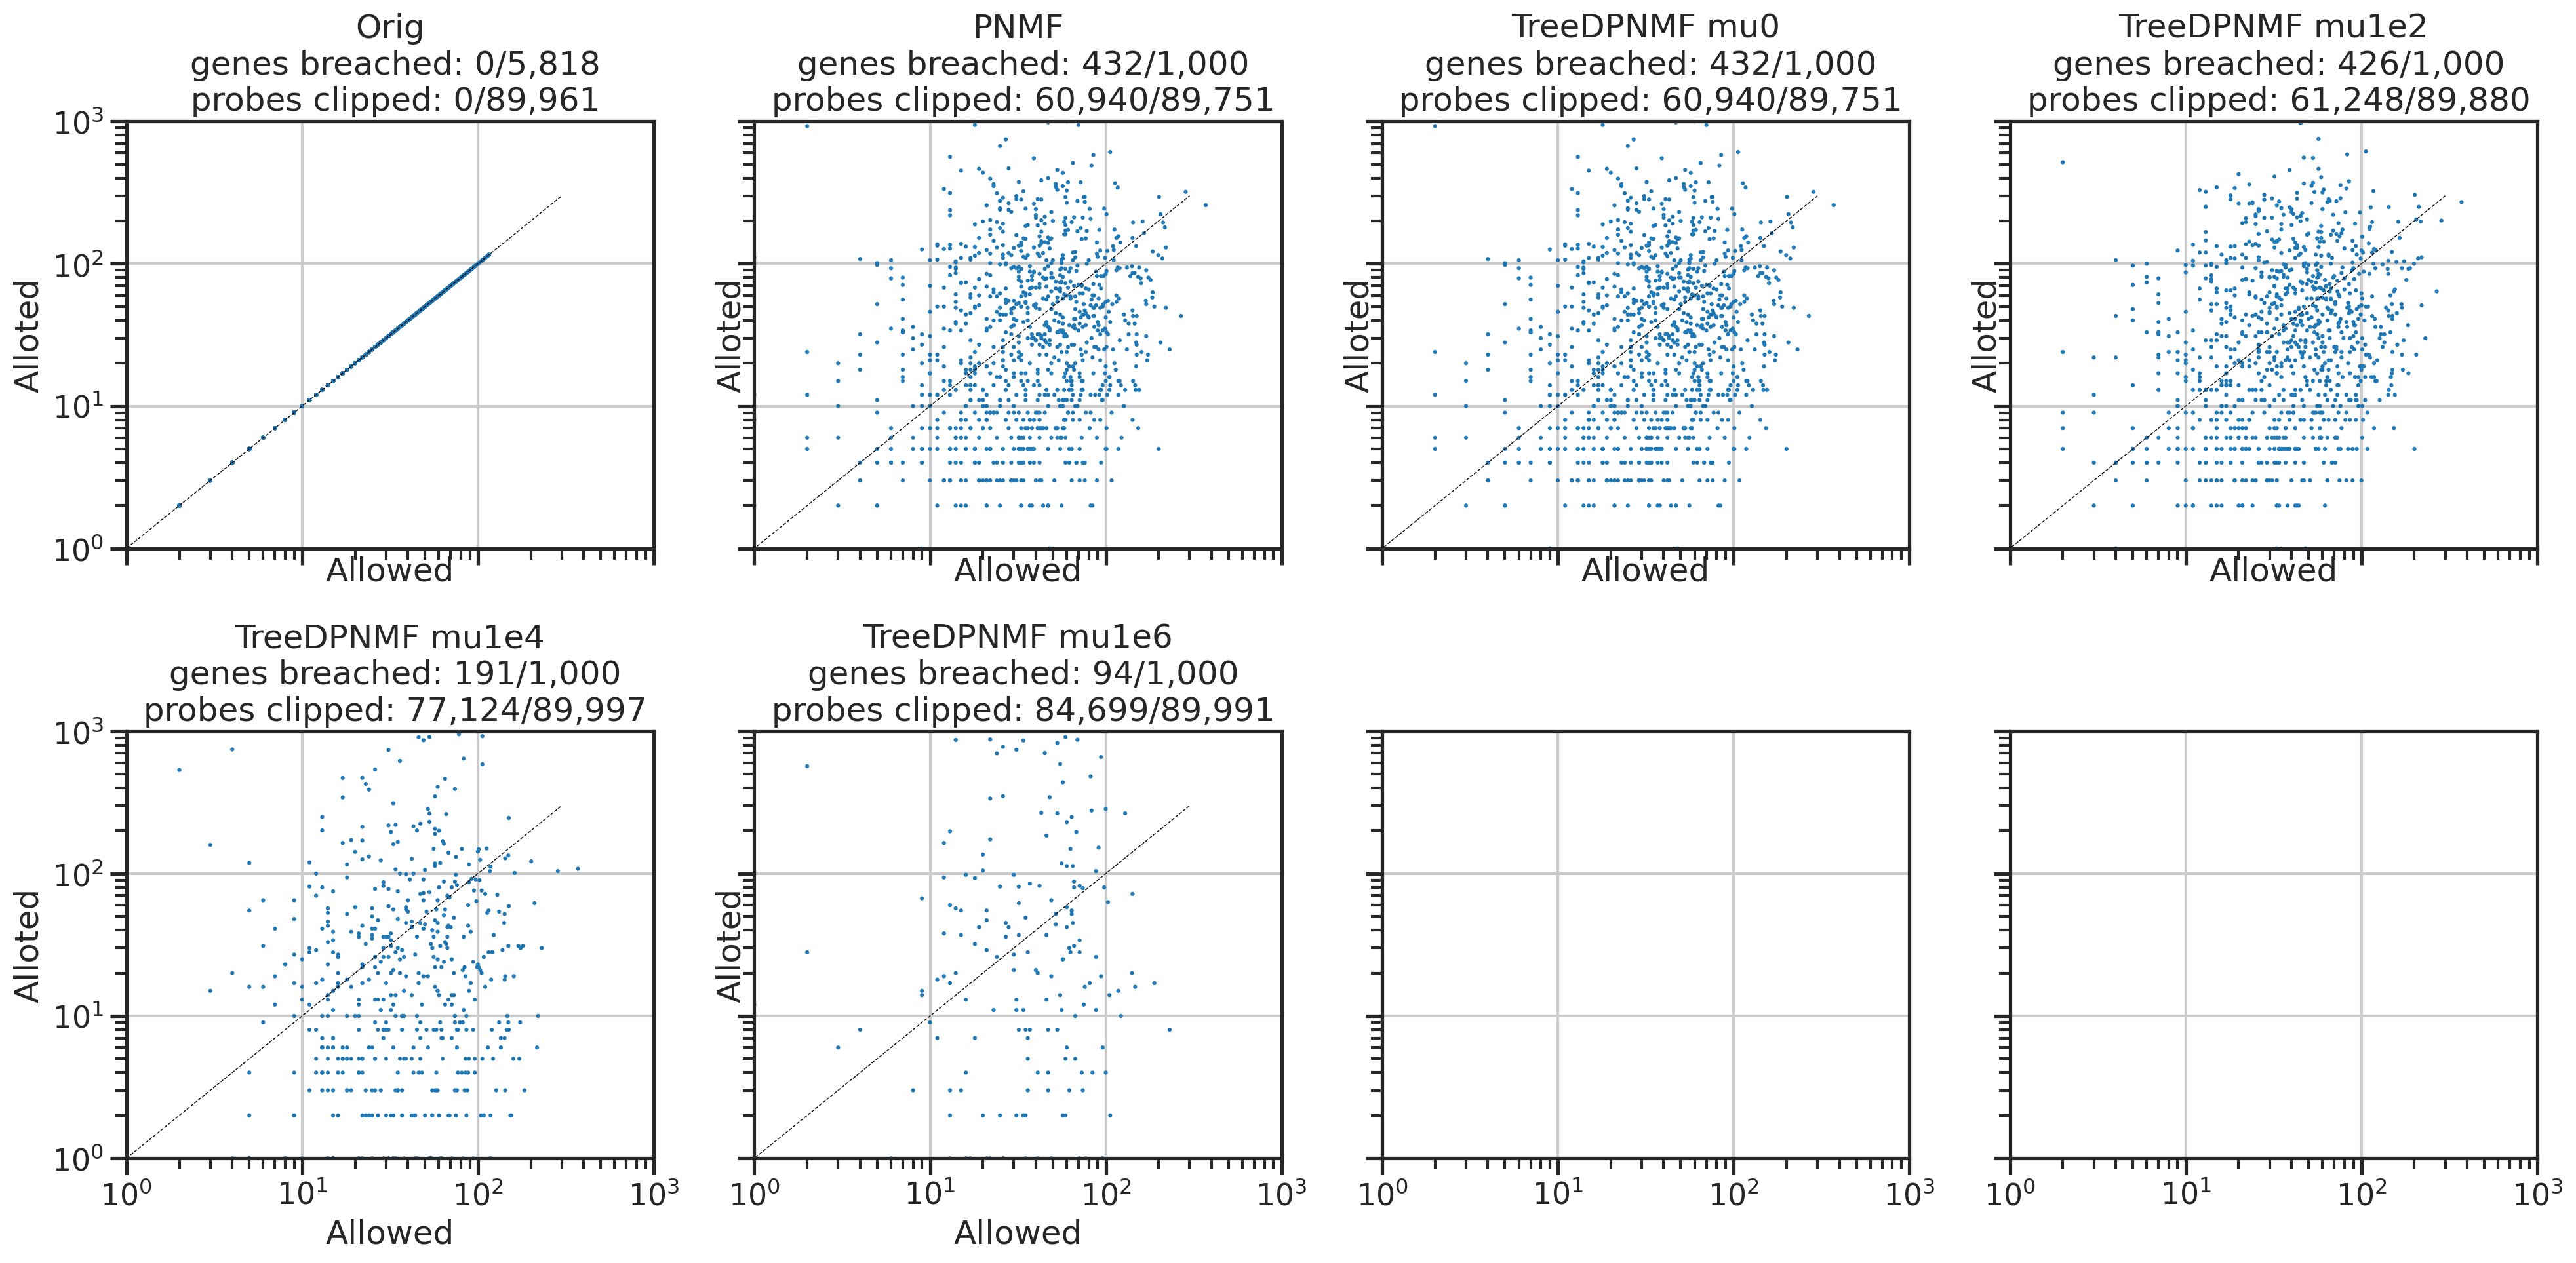

In [14]:
n = len(res_all)
nx = min(n, 4)
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*5,ny*5), sharex=True, sharey=True)
i = 0
for lbl, res_pnmf in res_all.items():
    ax = axs.flat[i]
    i += 1
    res_pnmf.plot_cnstrnts(ax=ax)
            
fig.tight_layout()
plt.show()

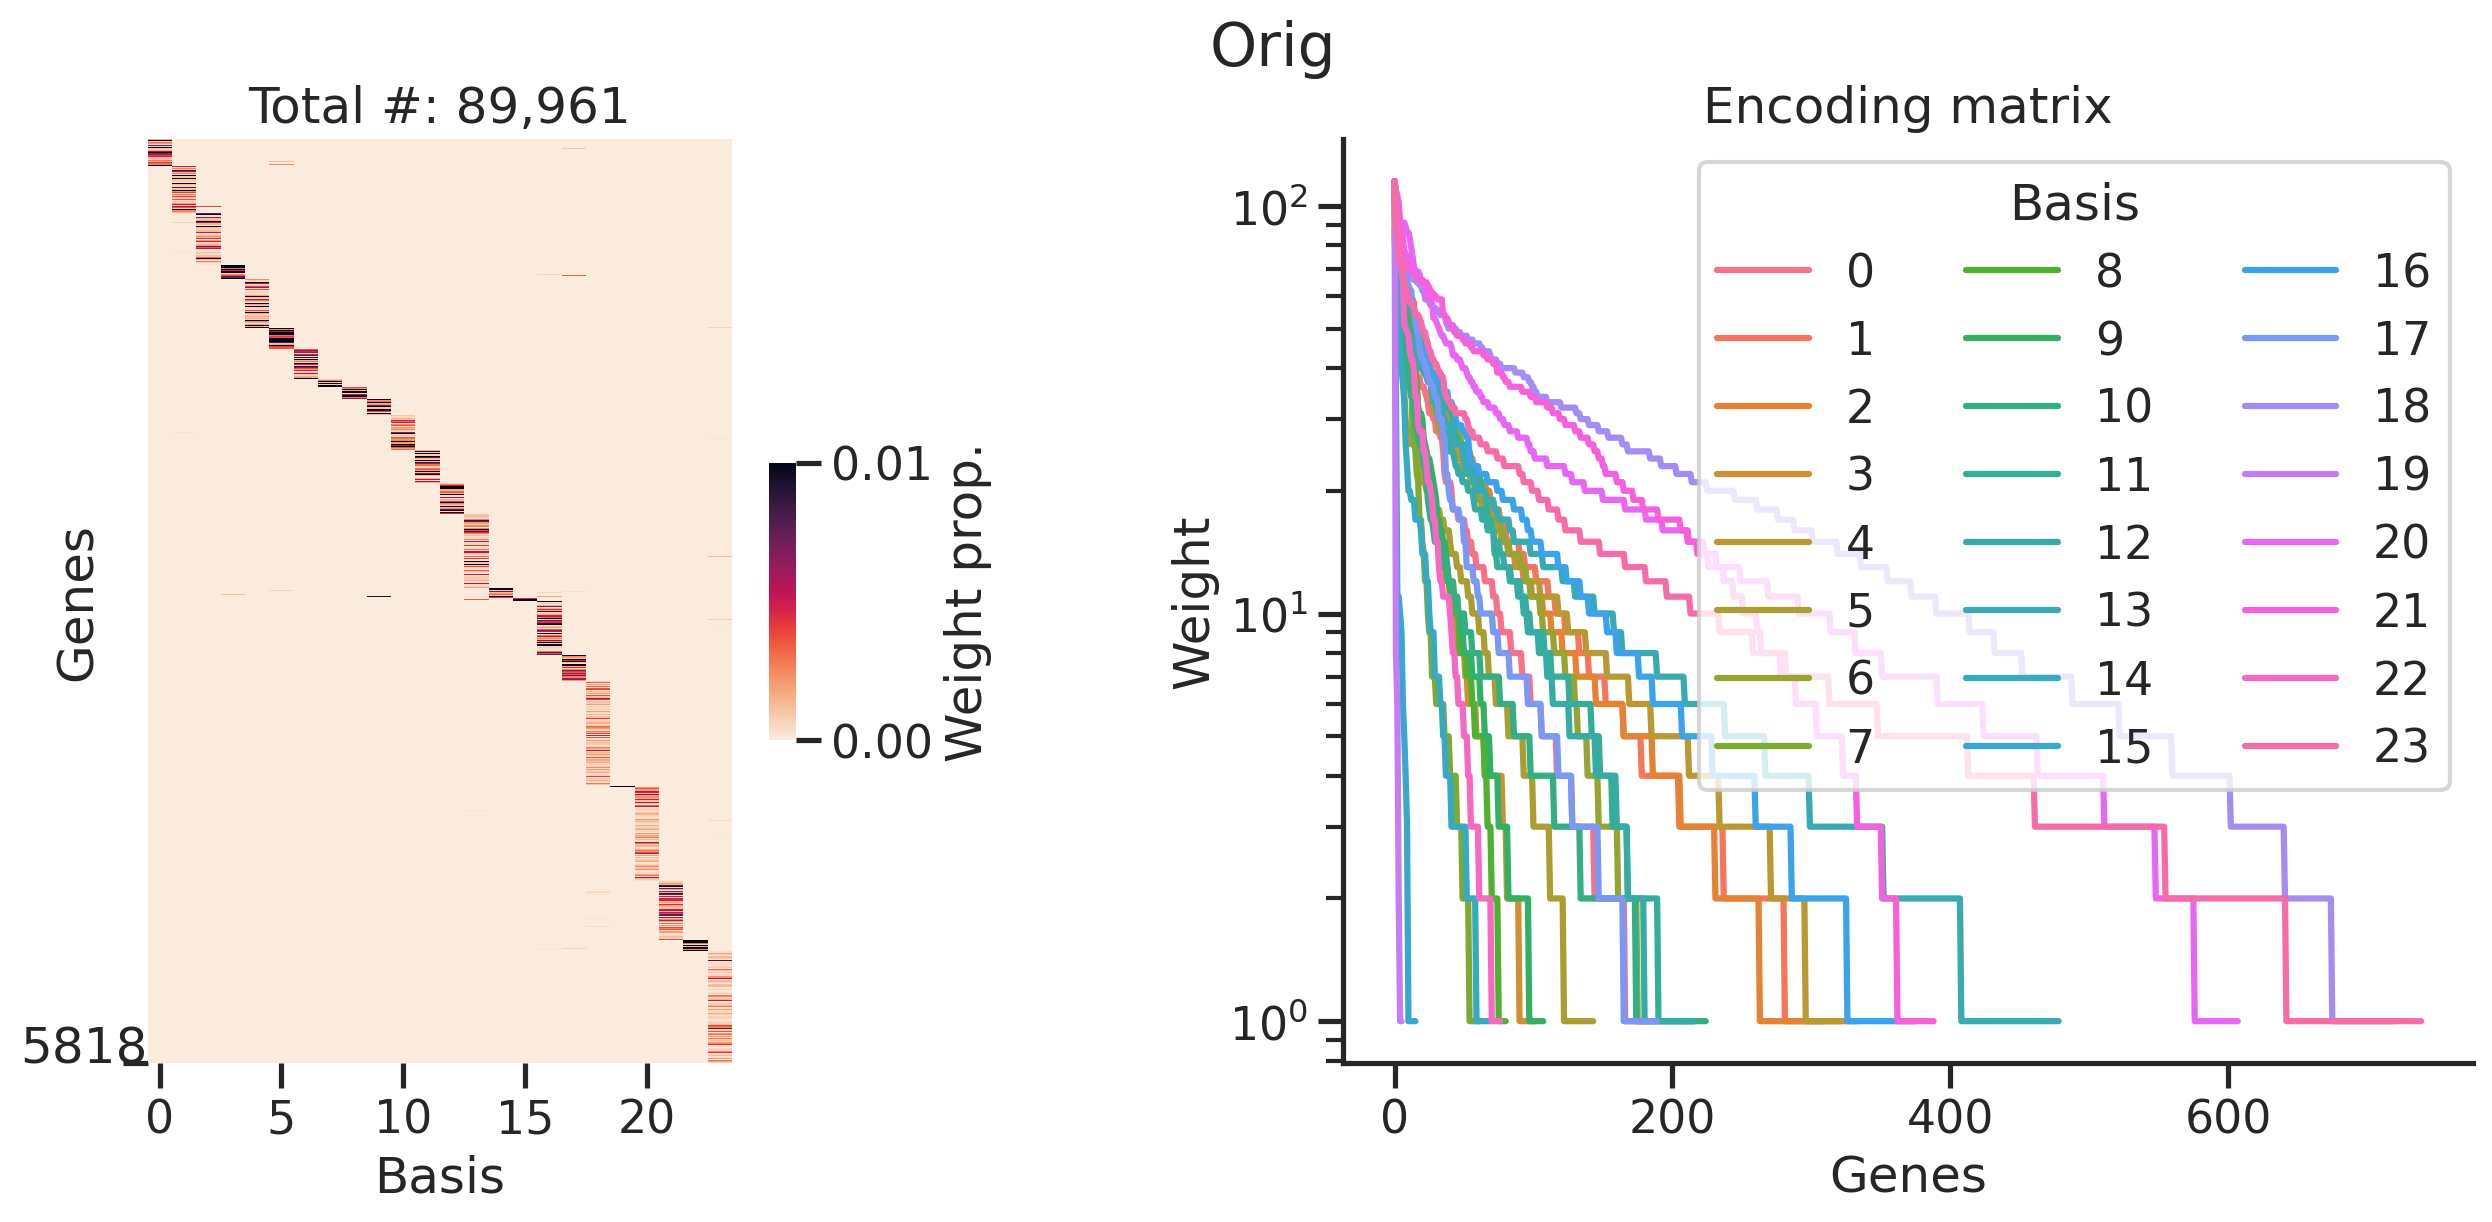

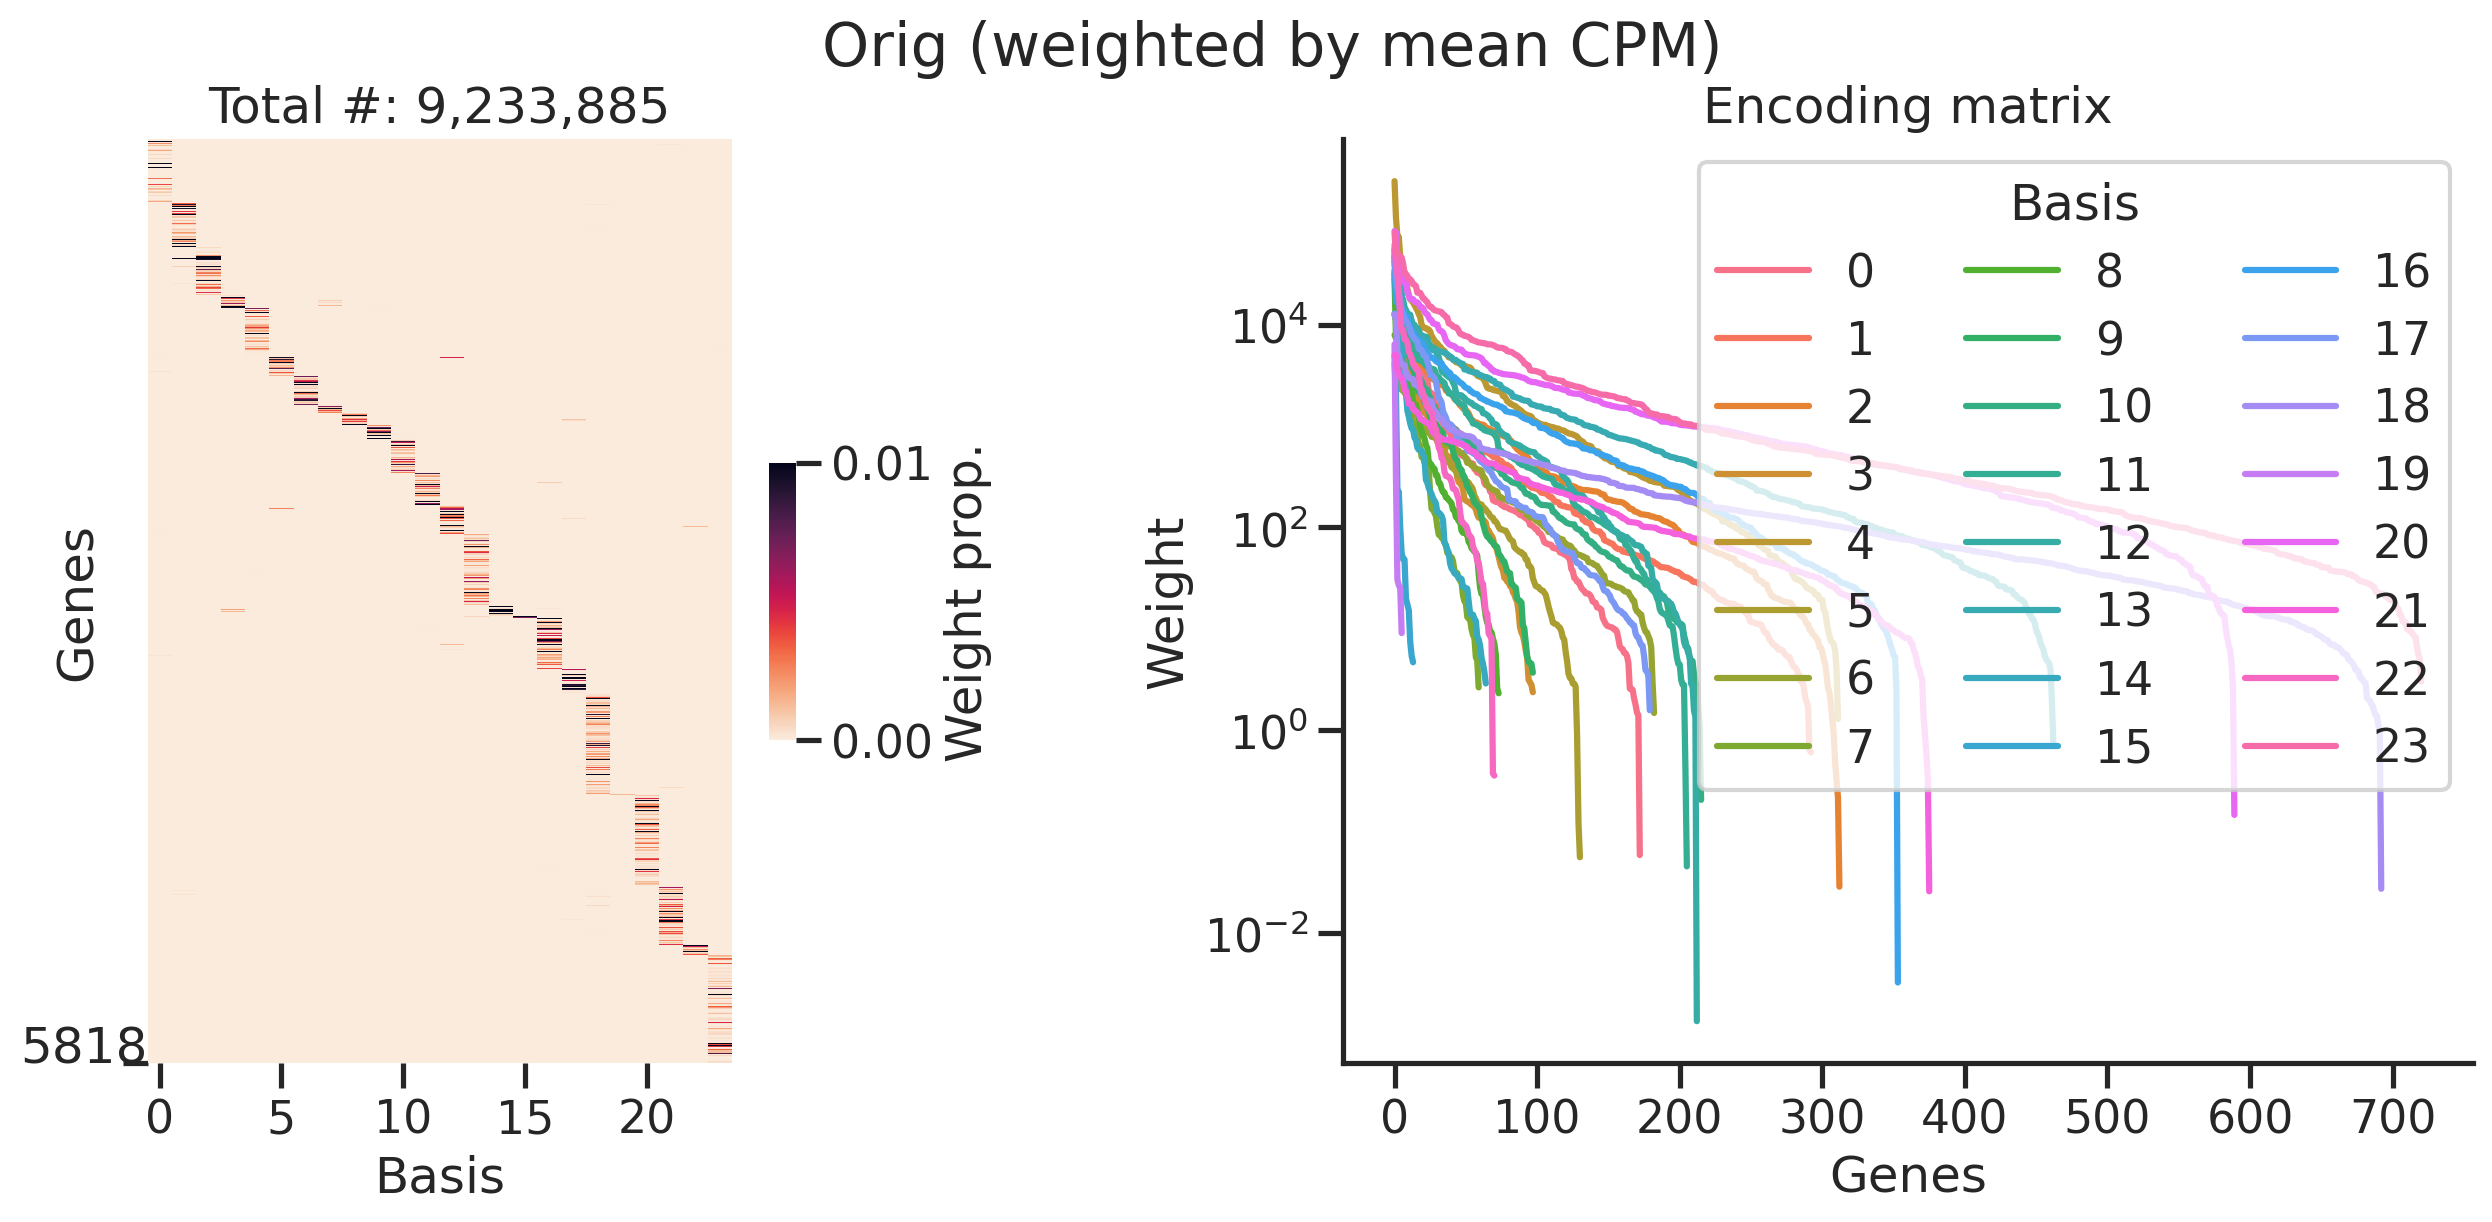

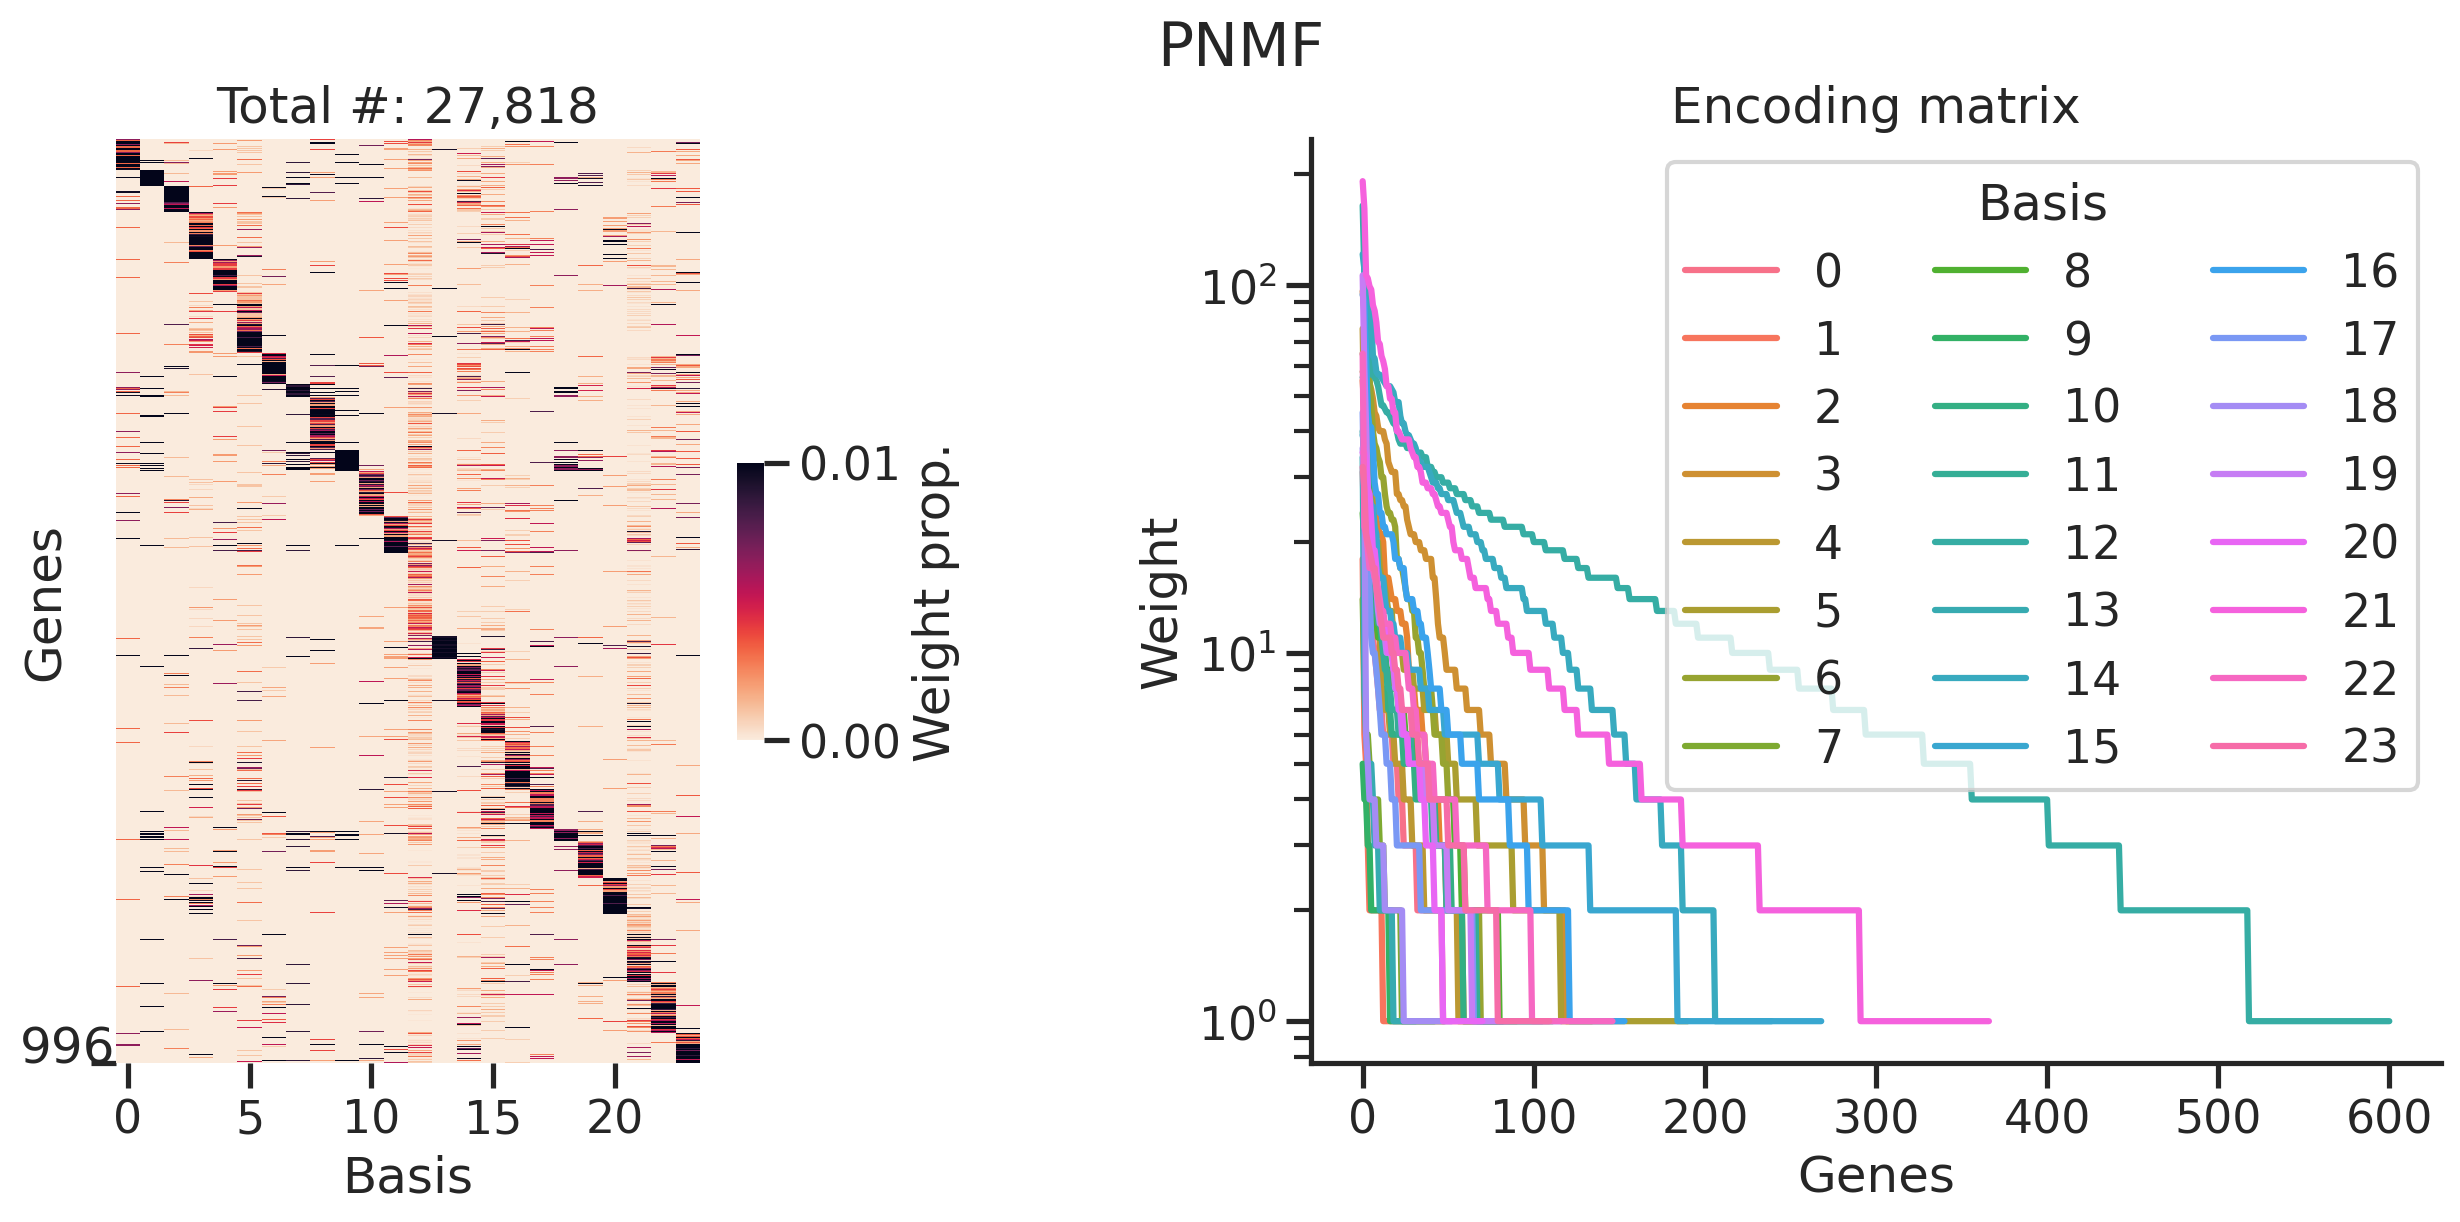

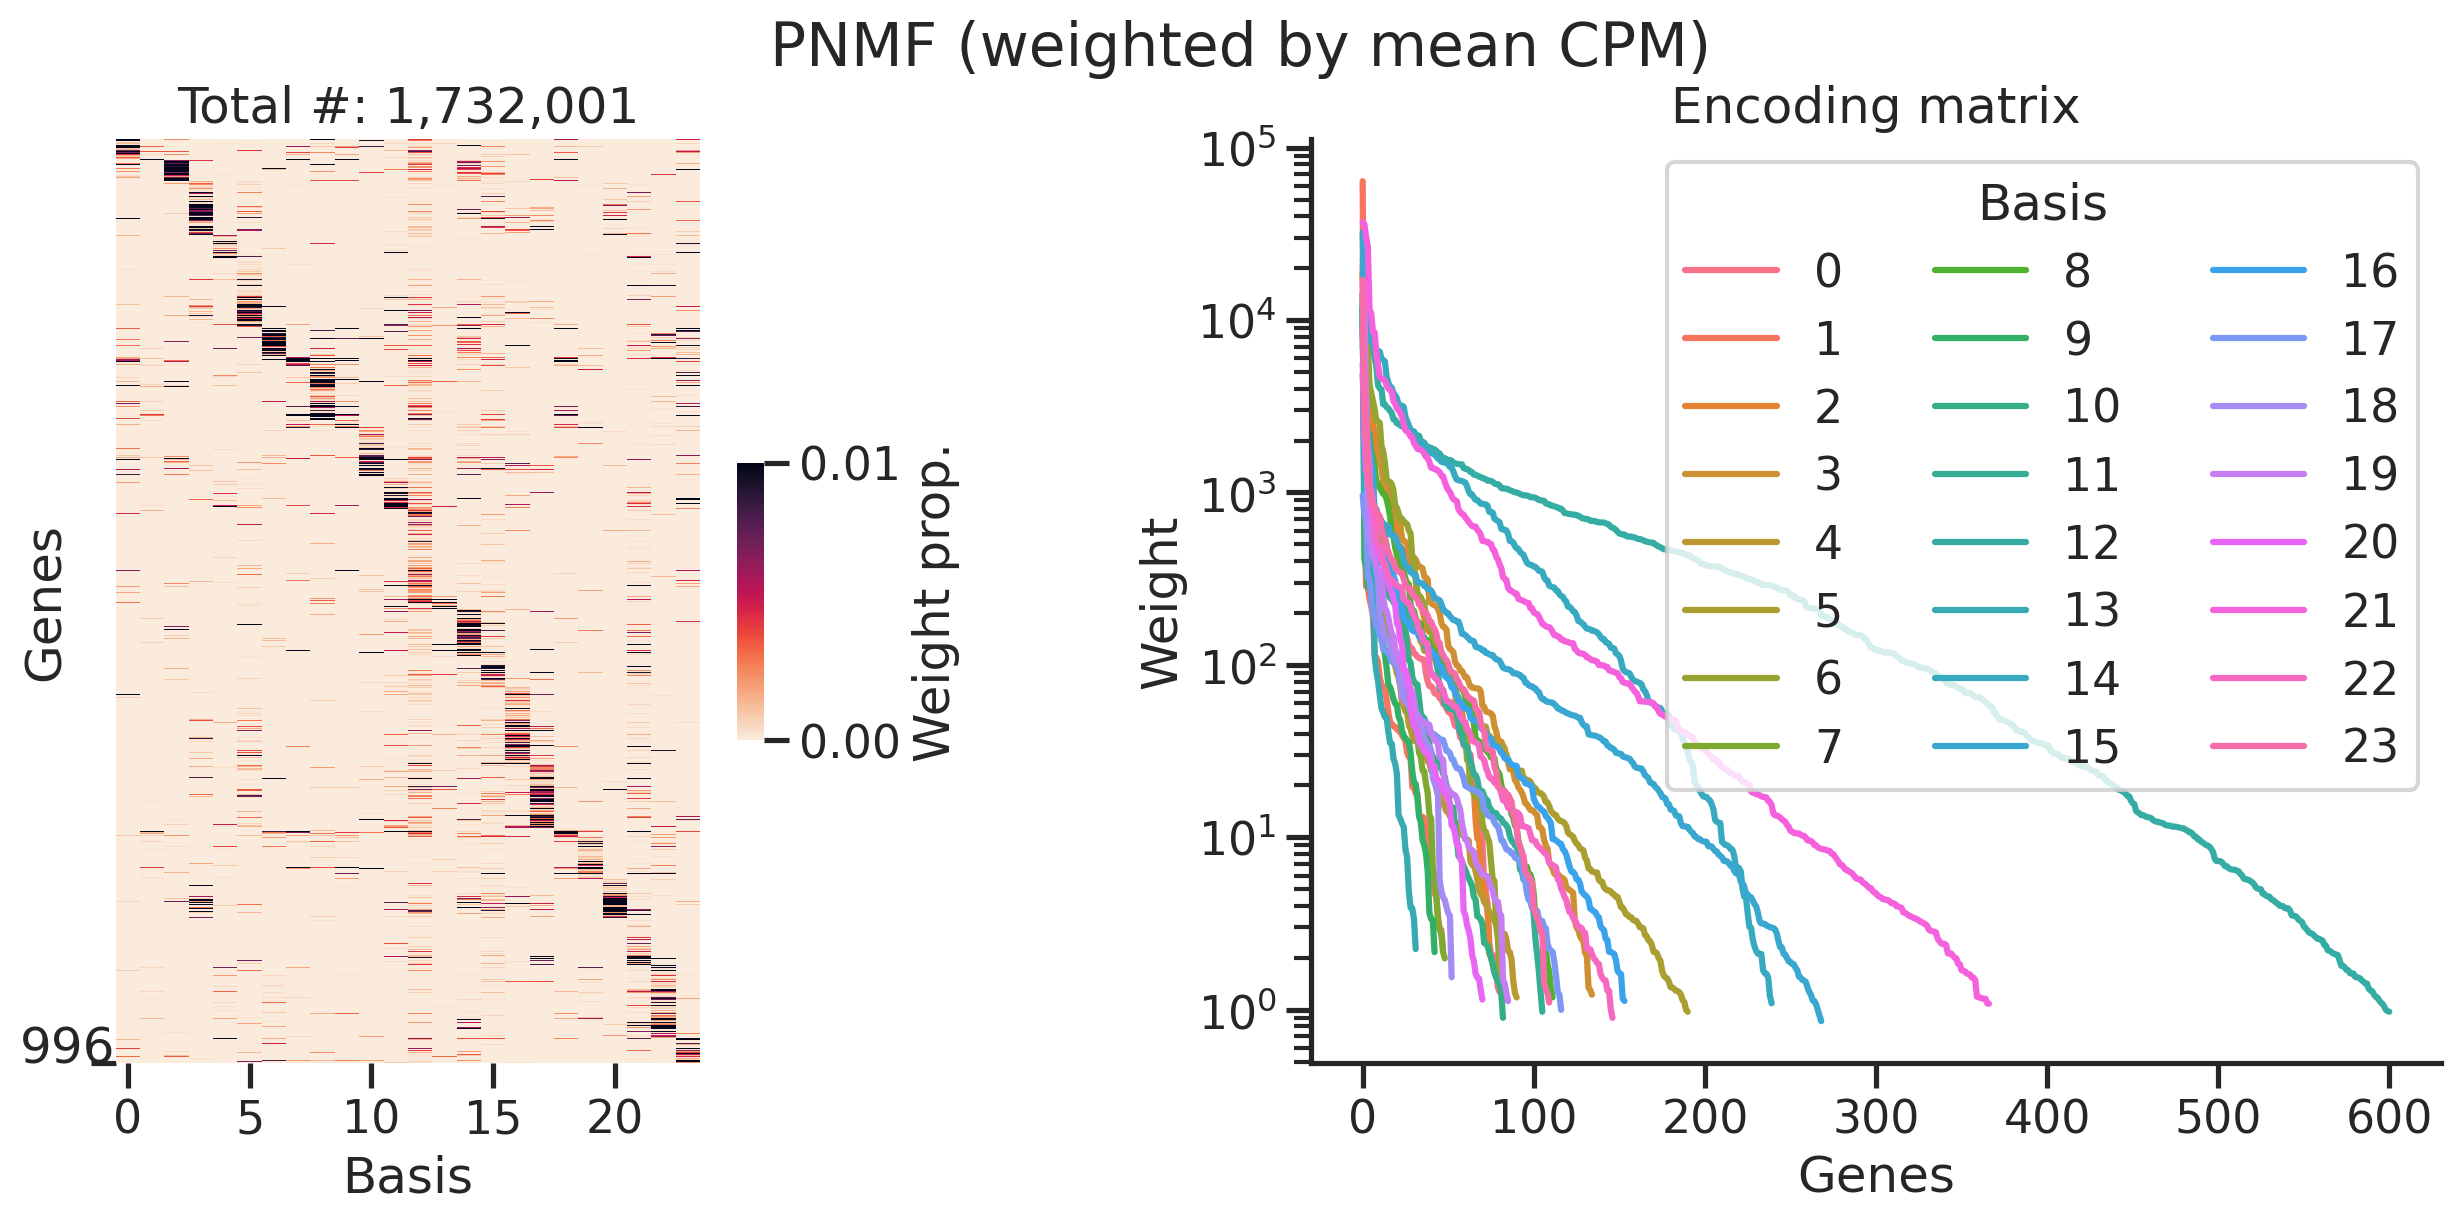

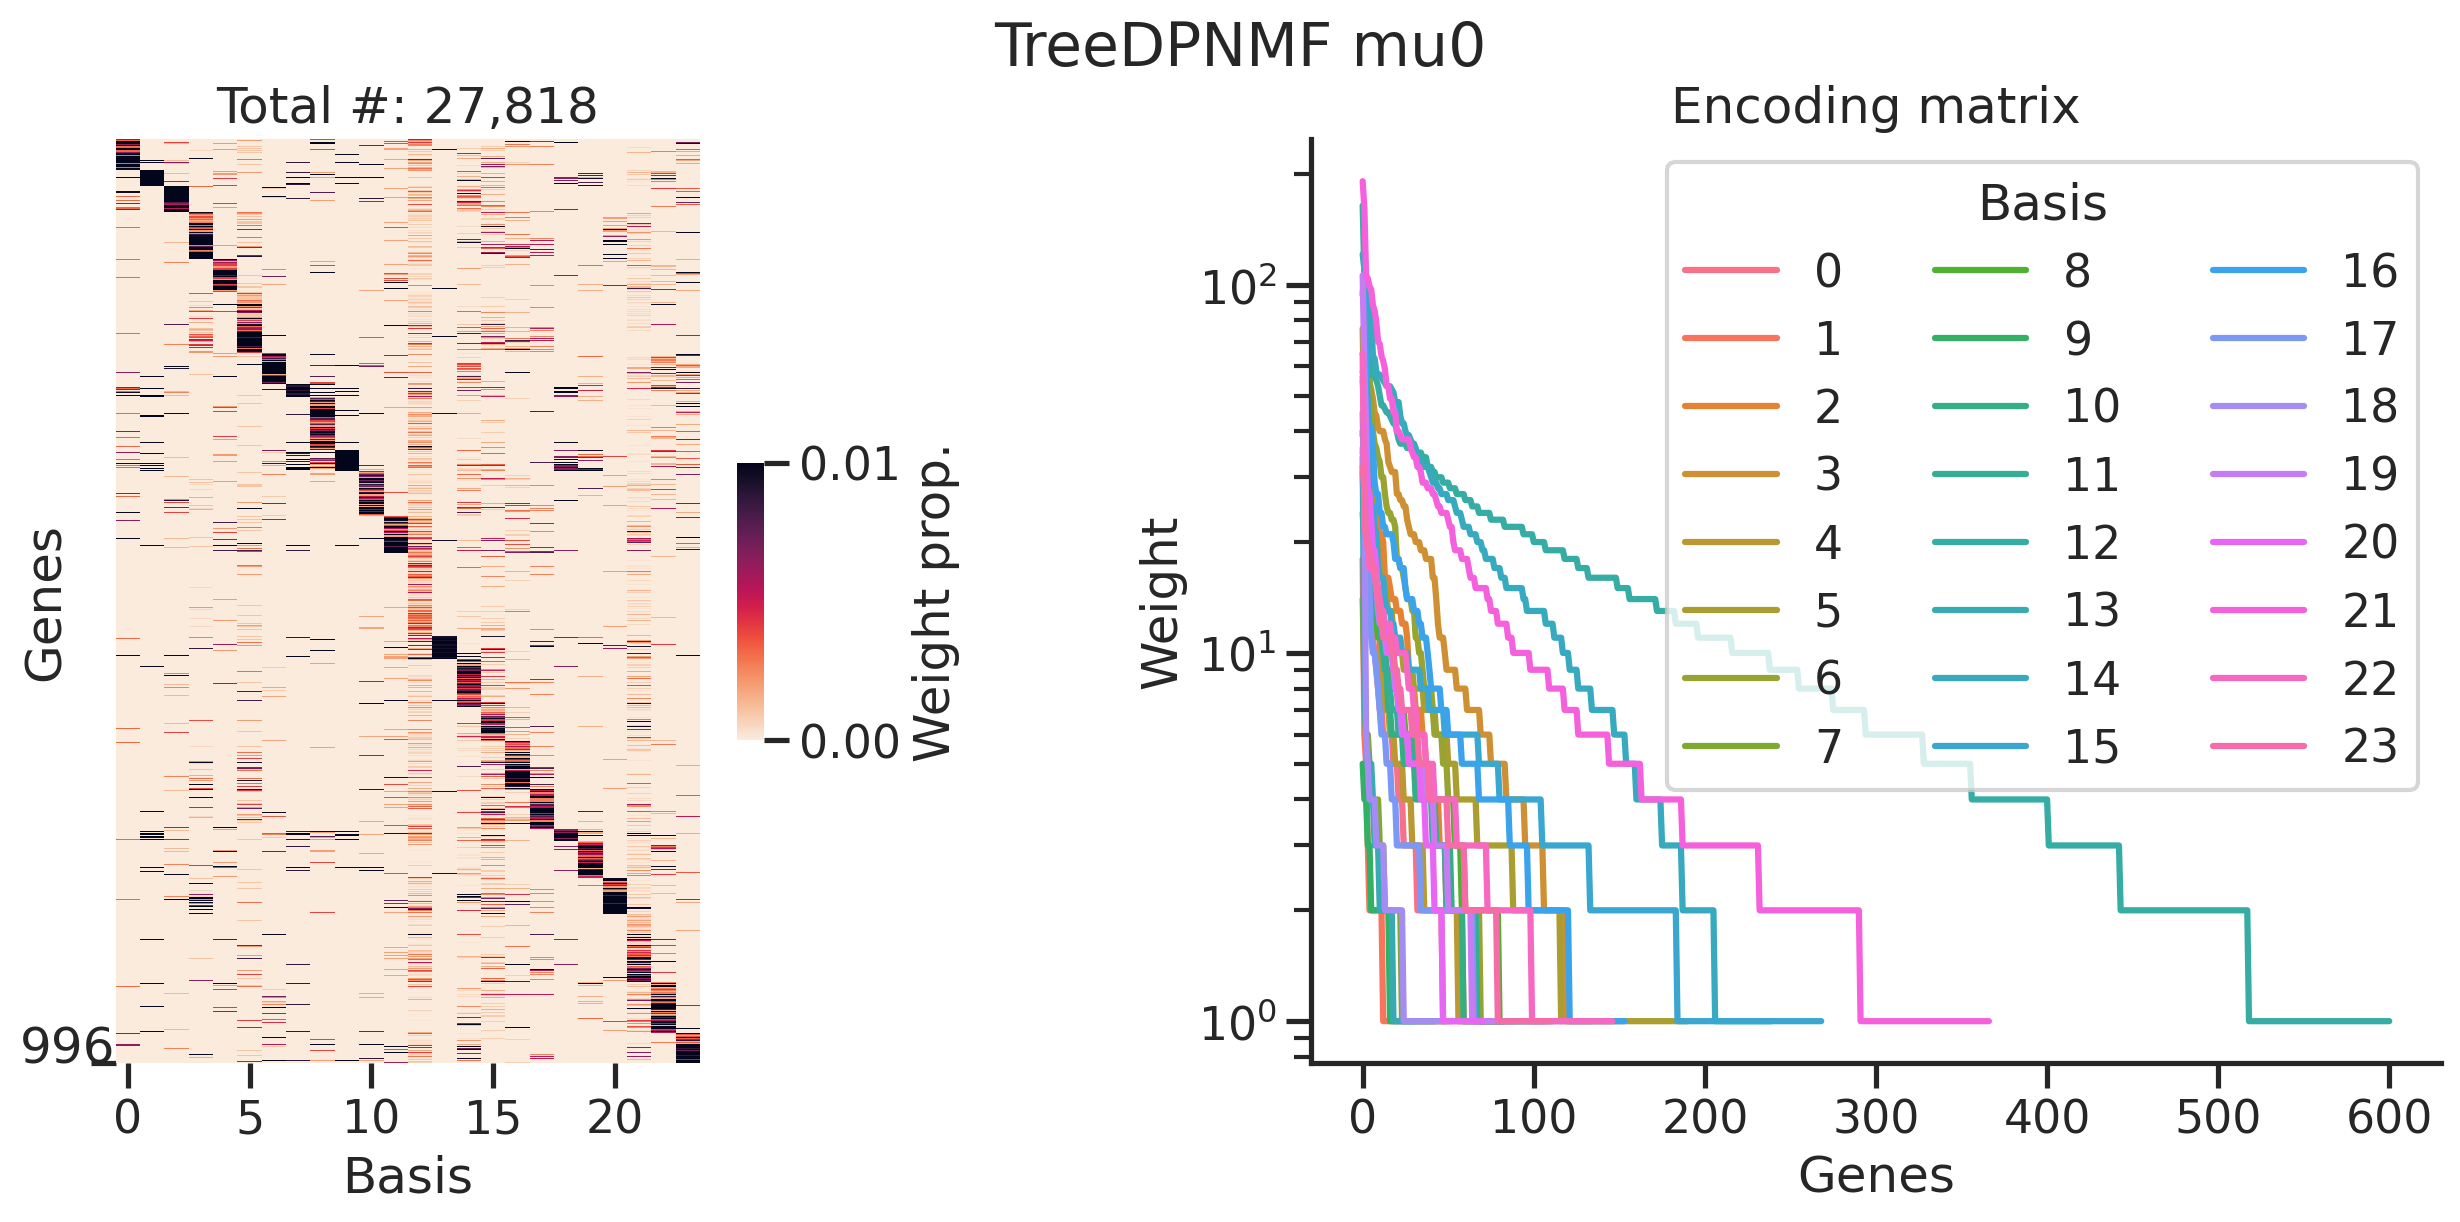

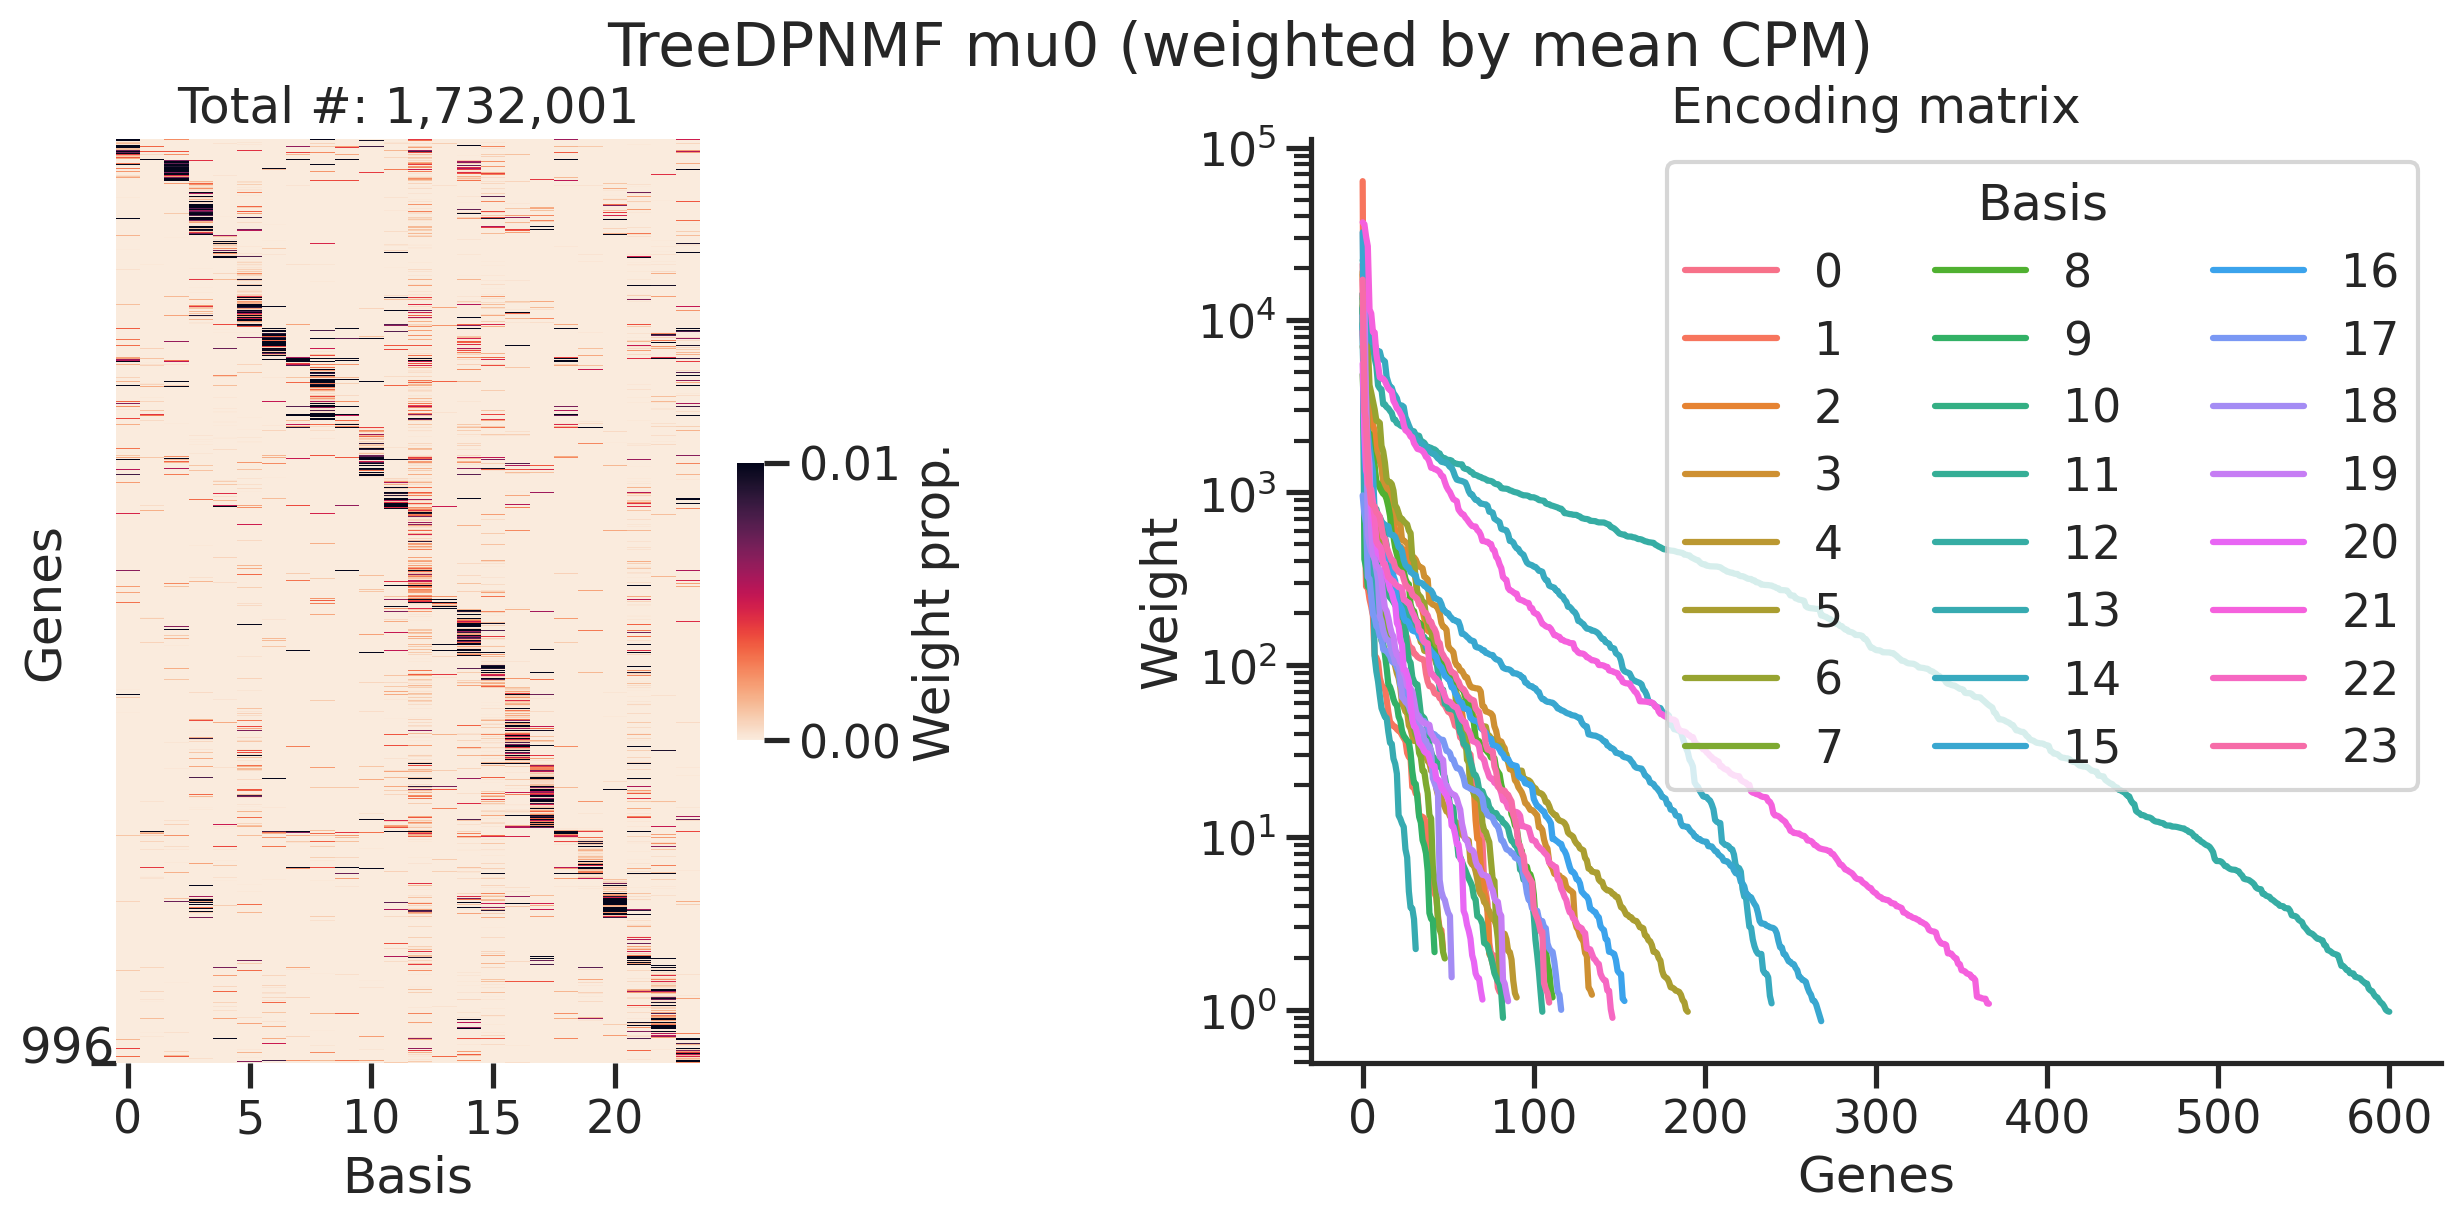

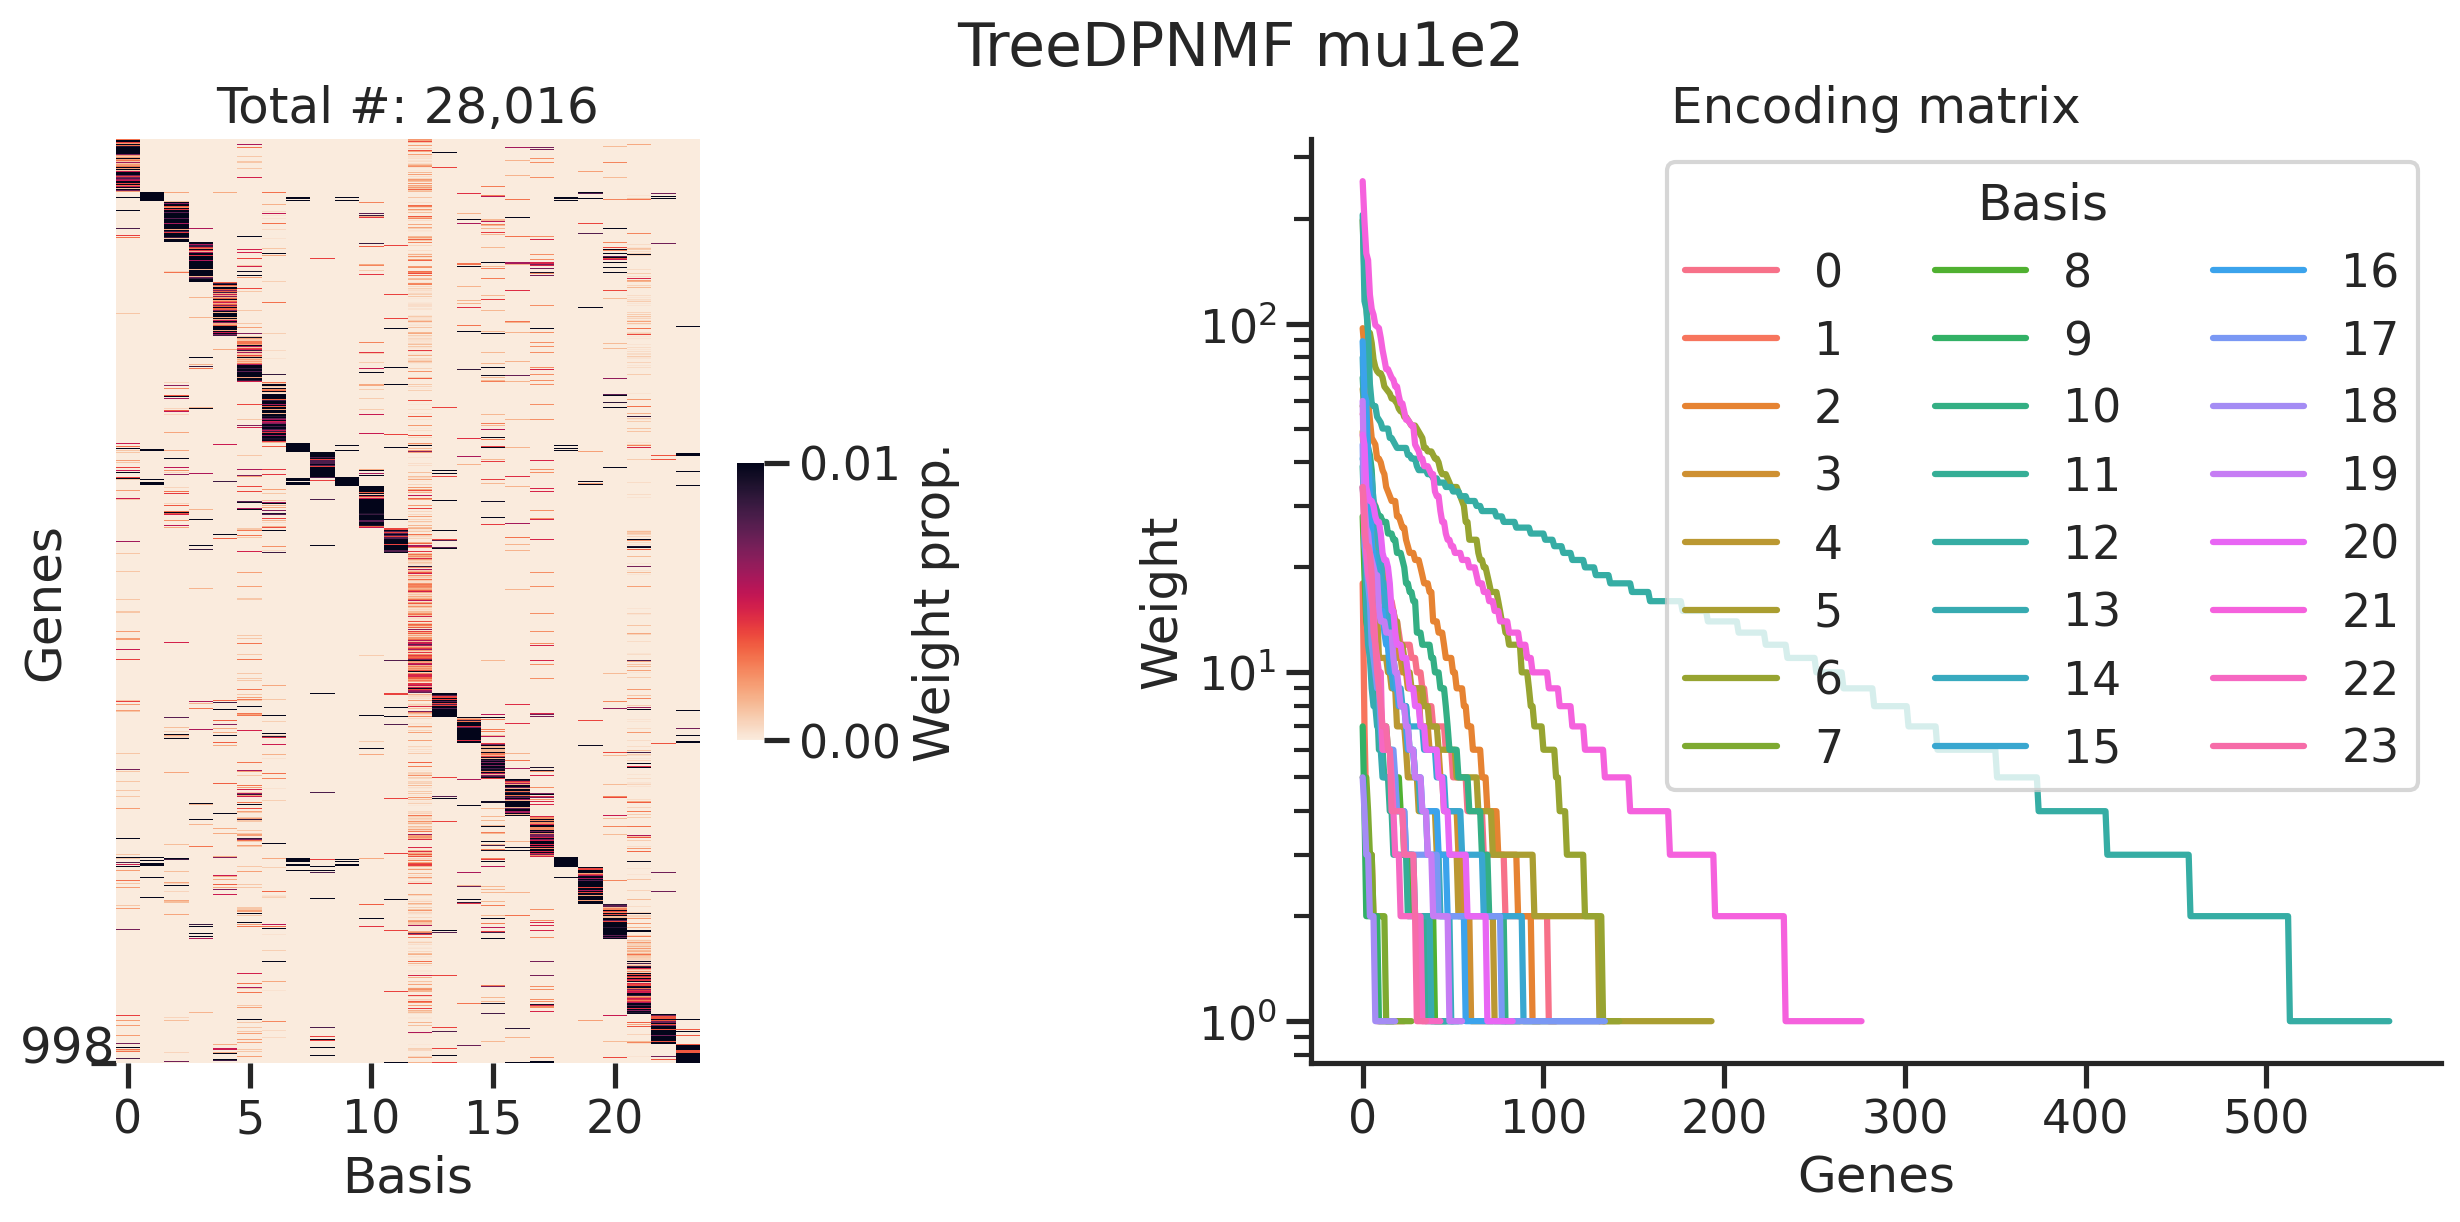

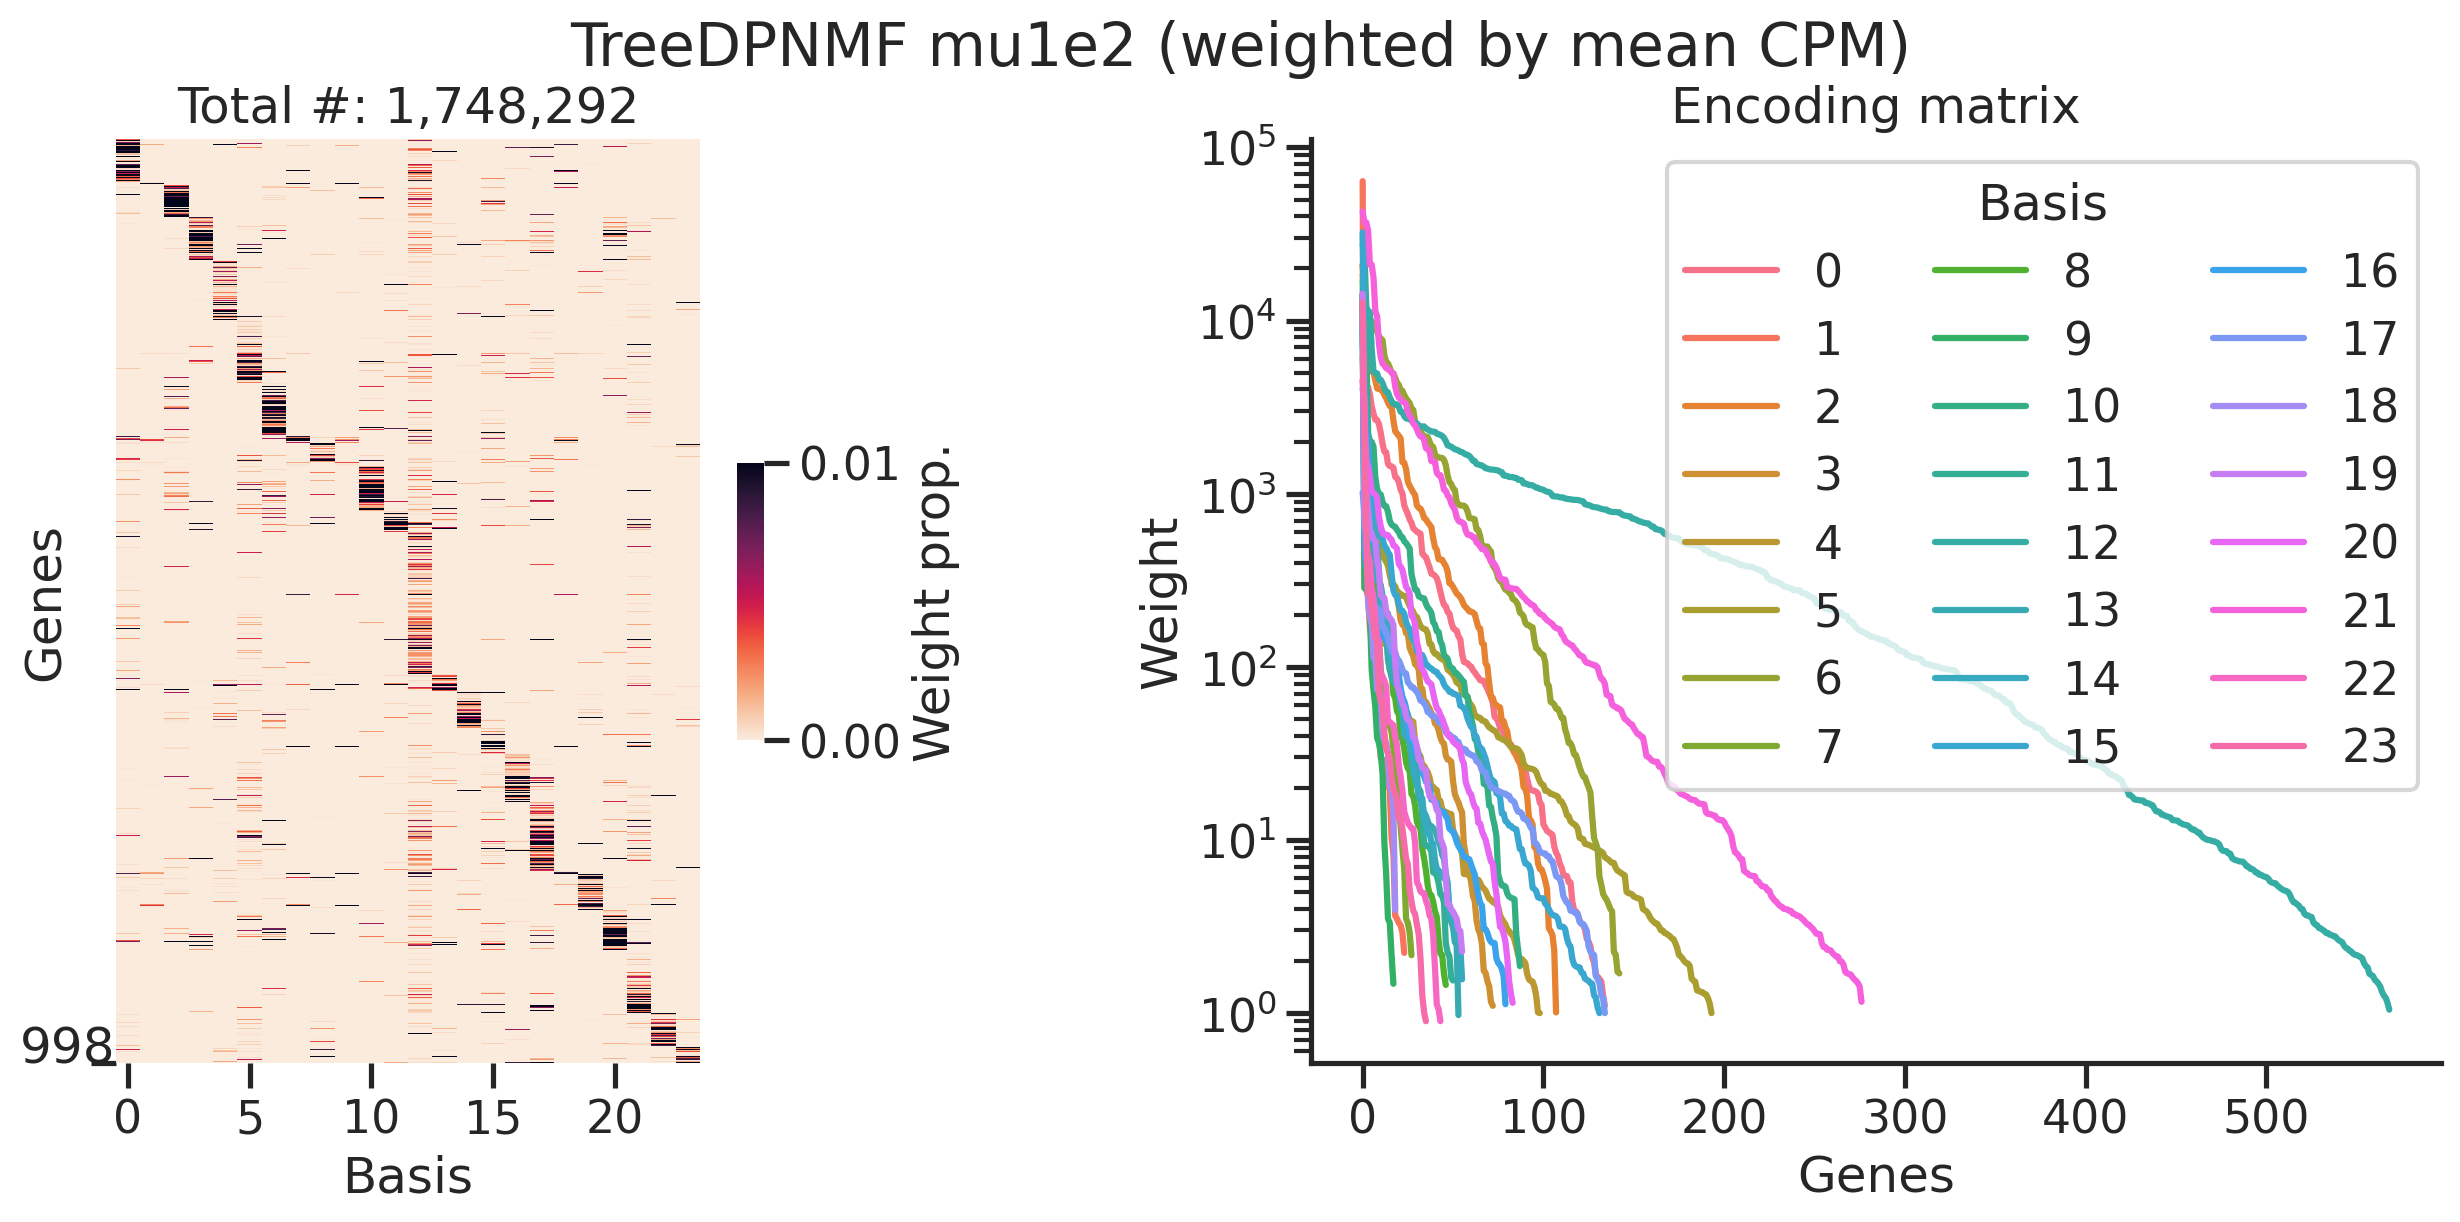

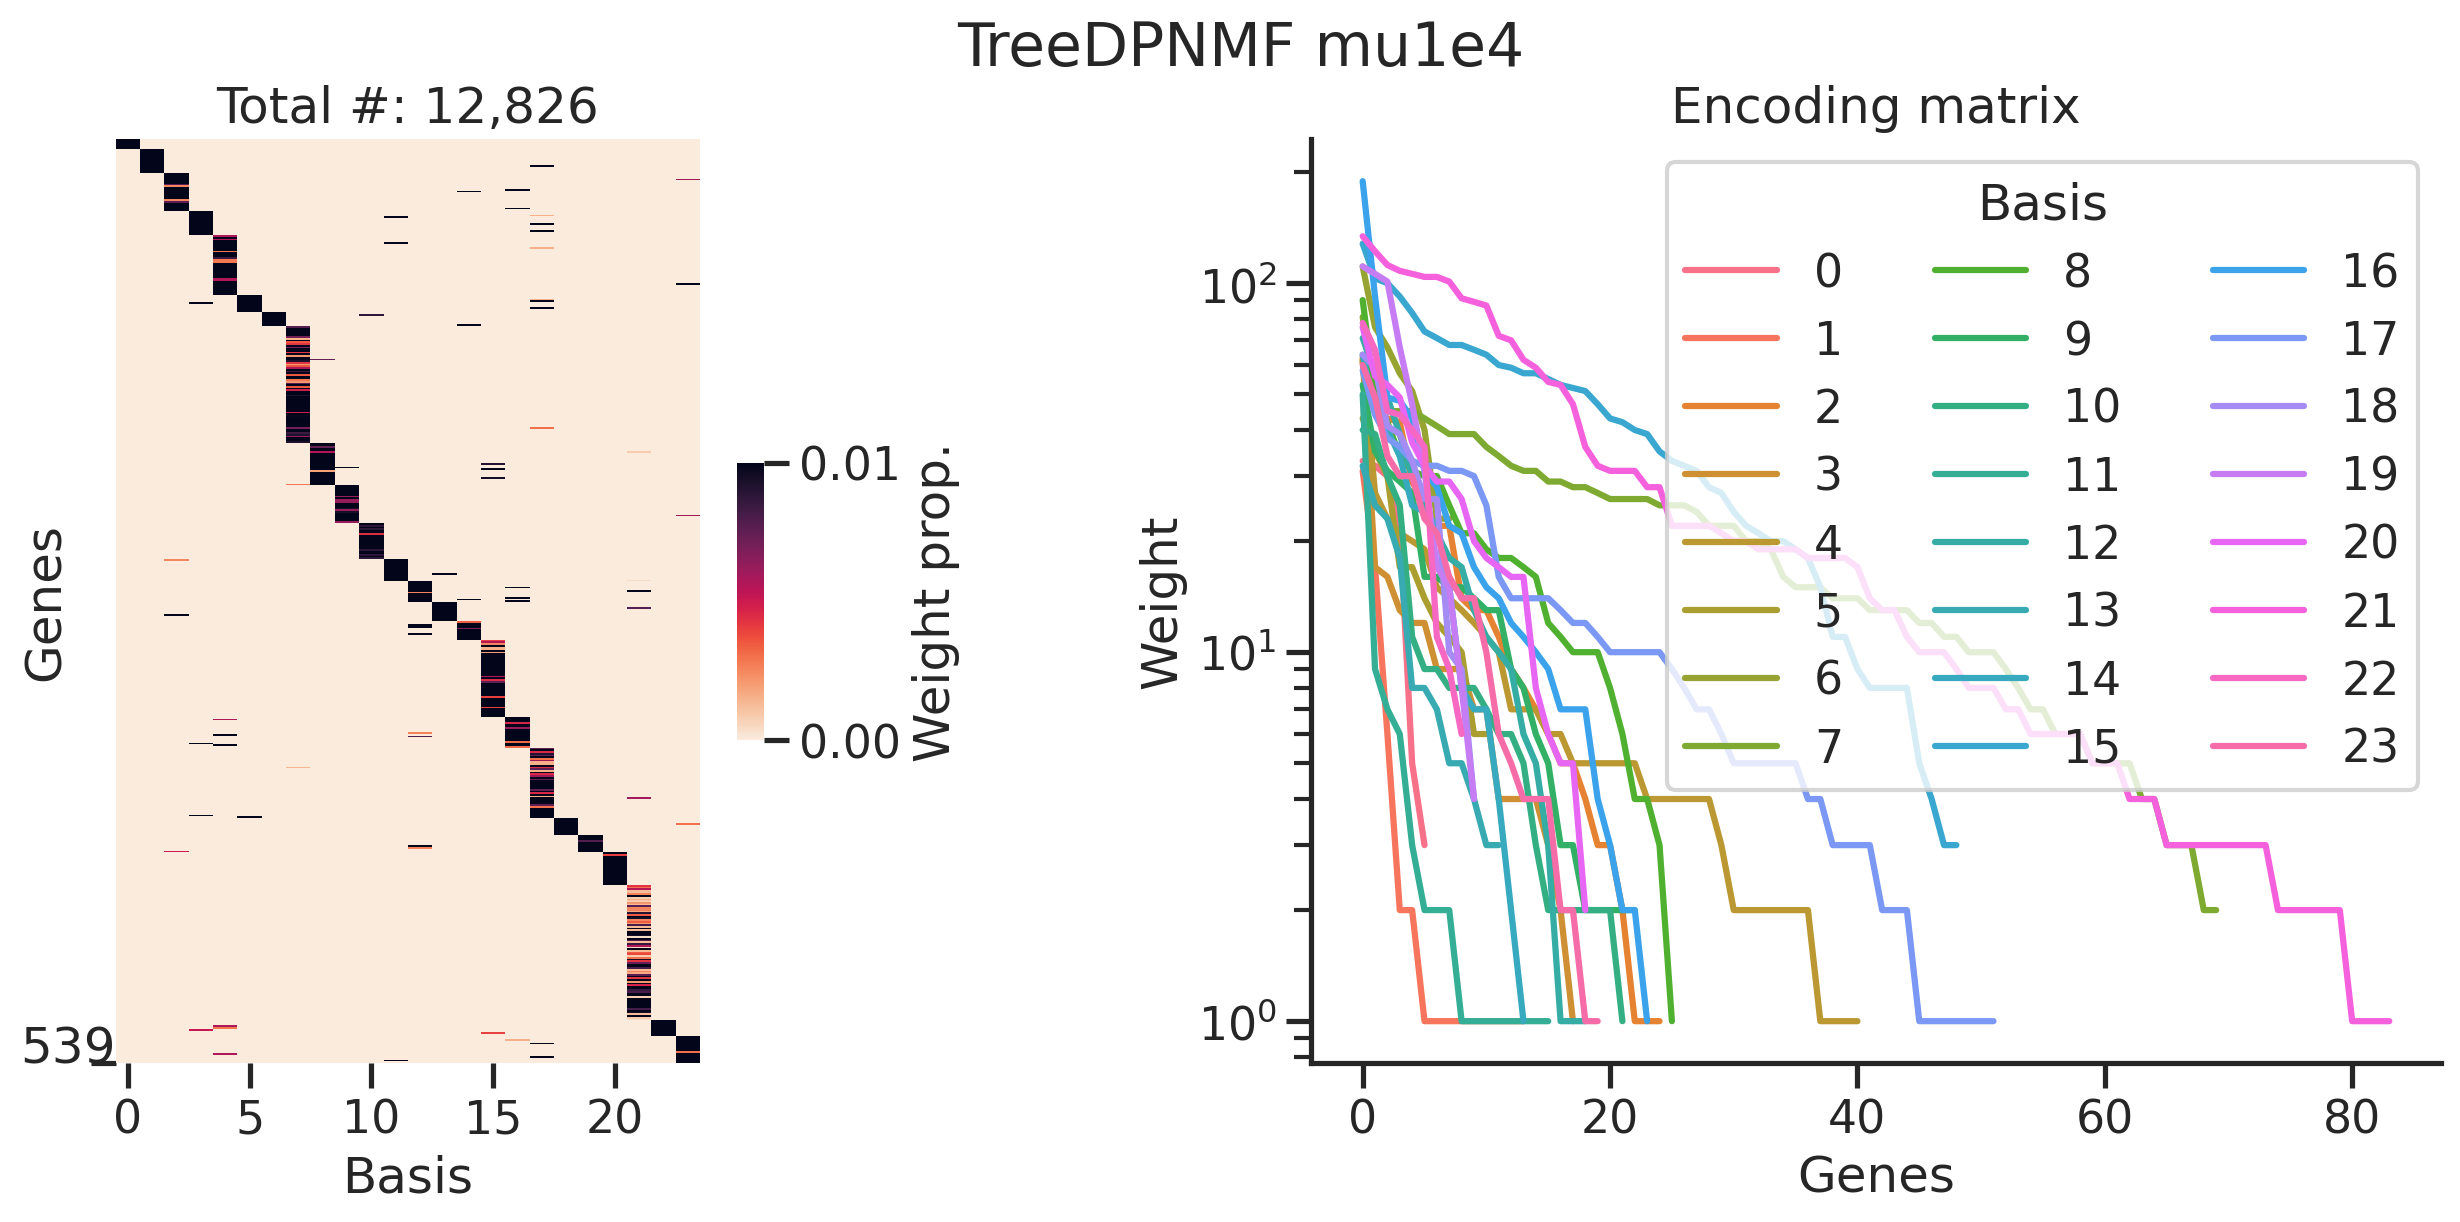

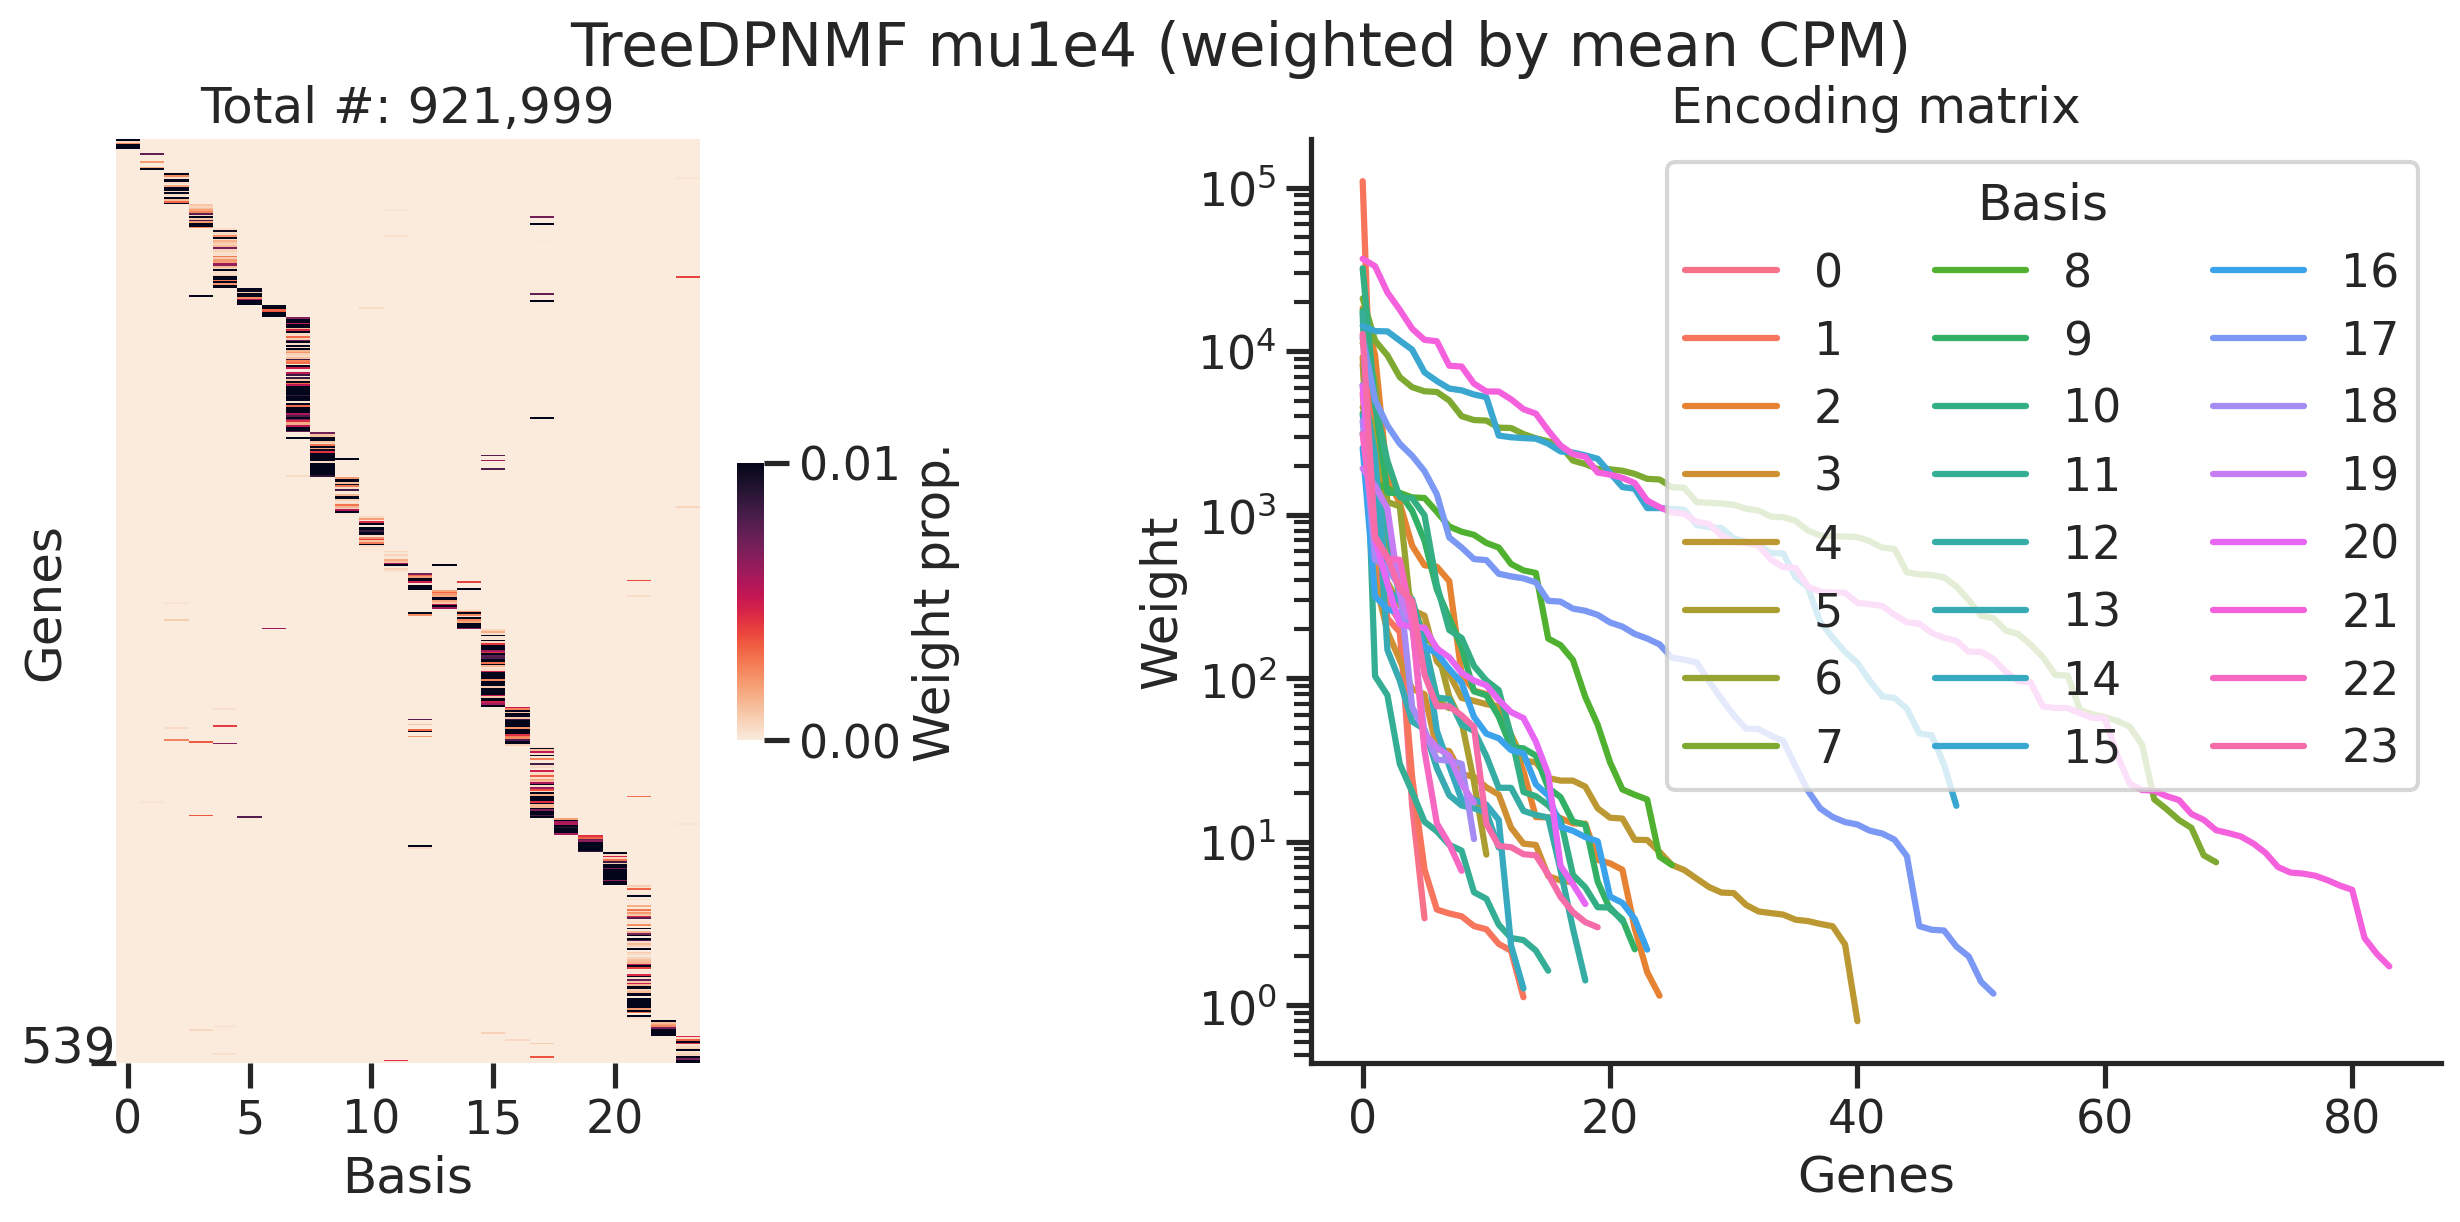

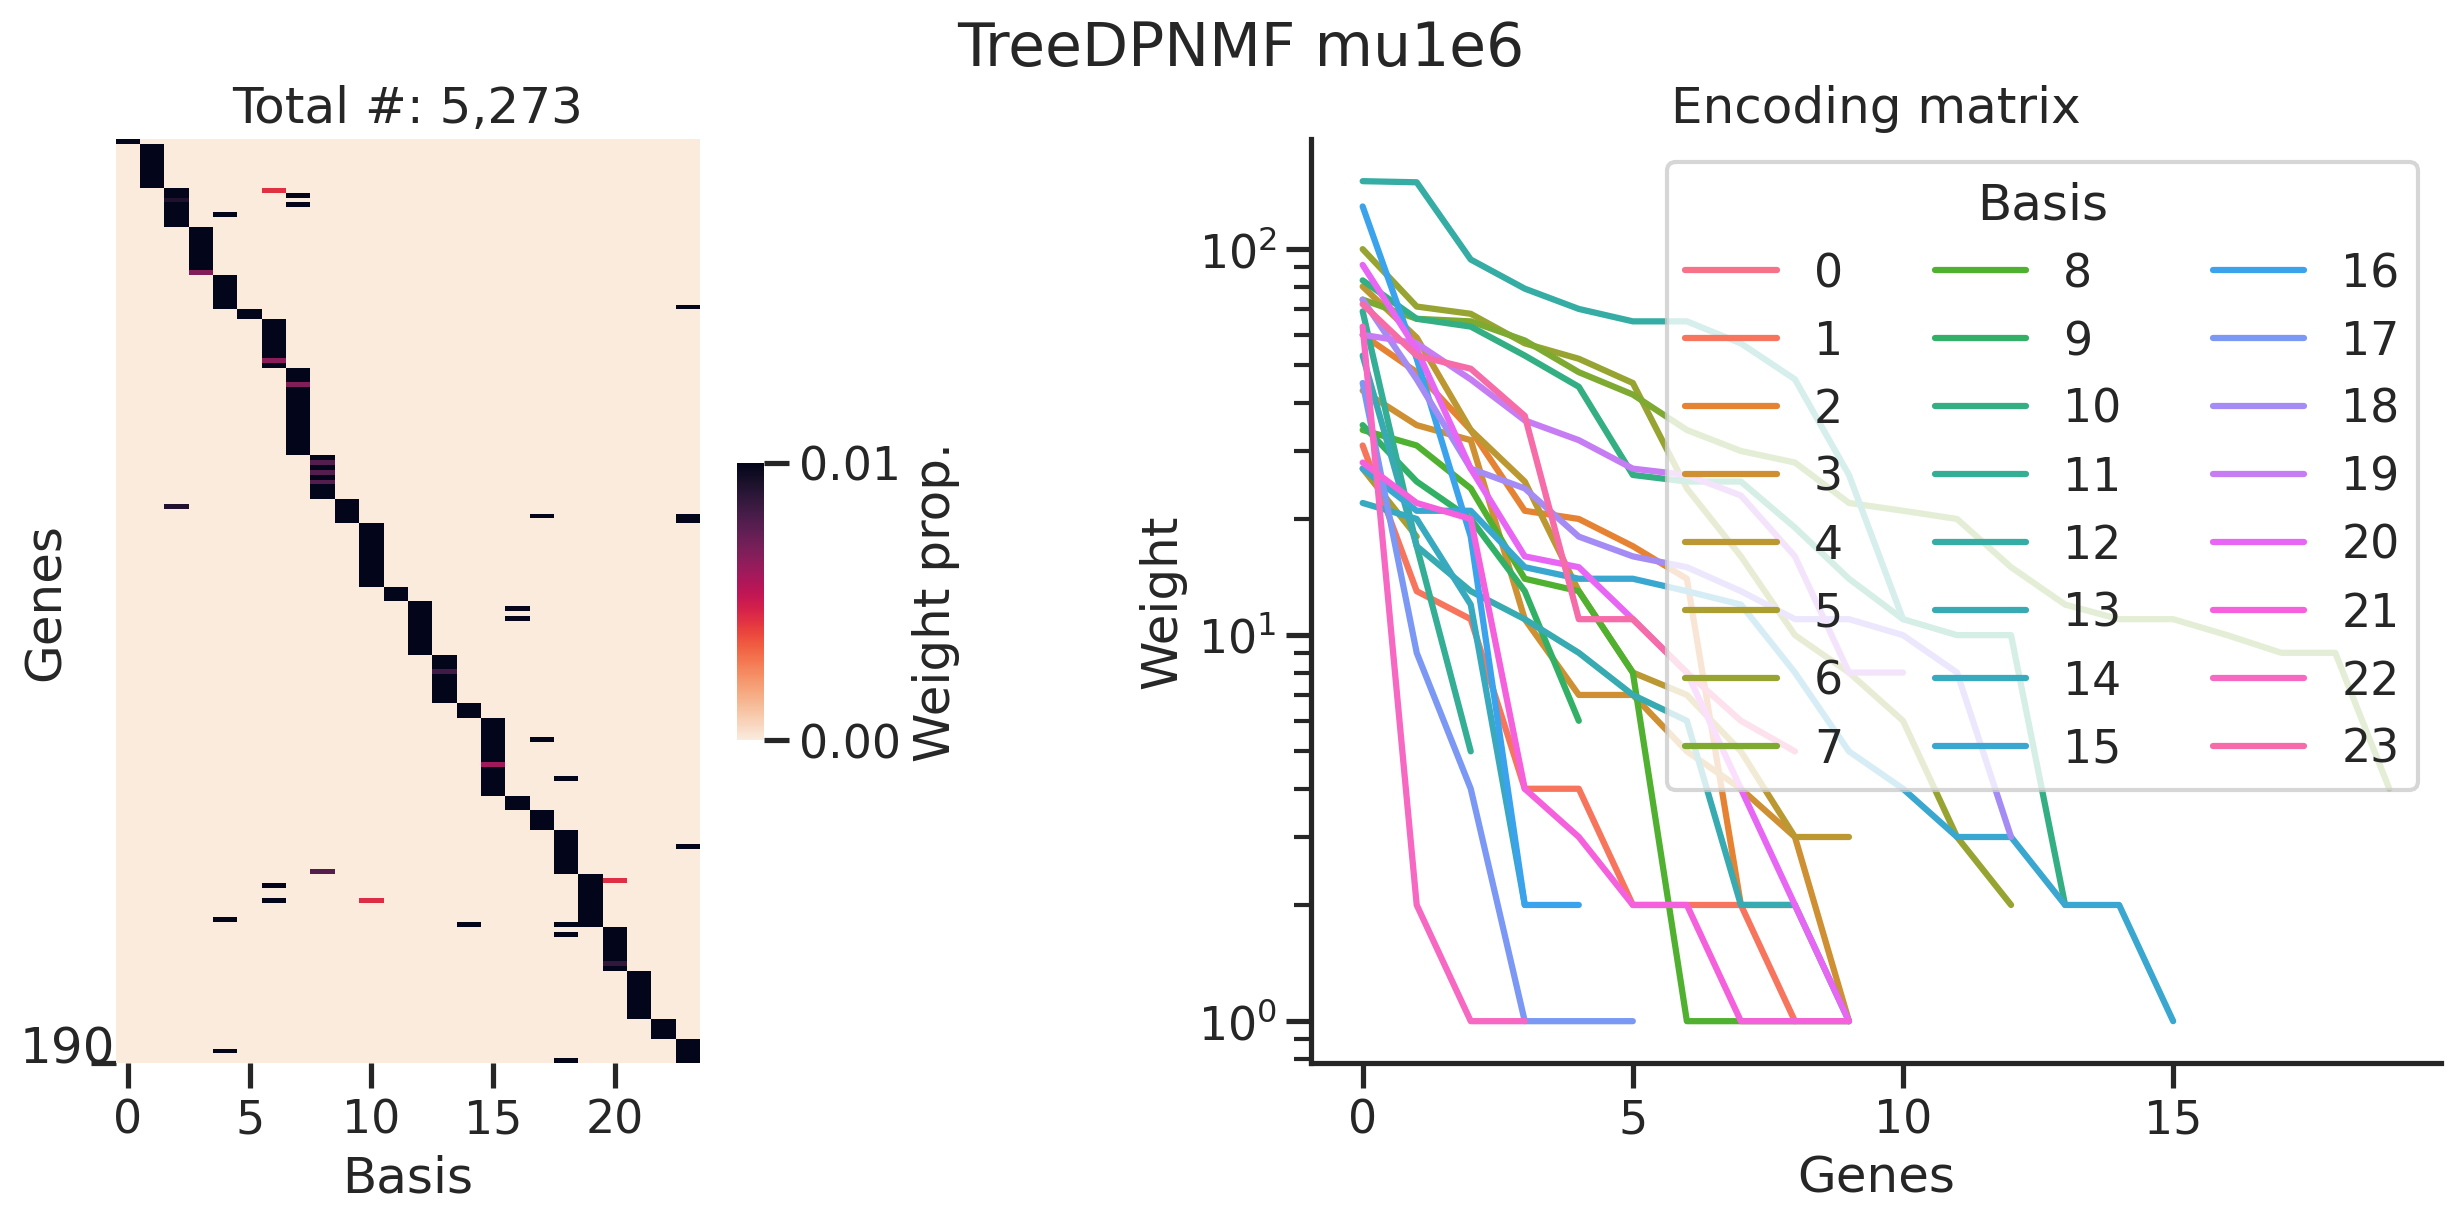

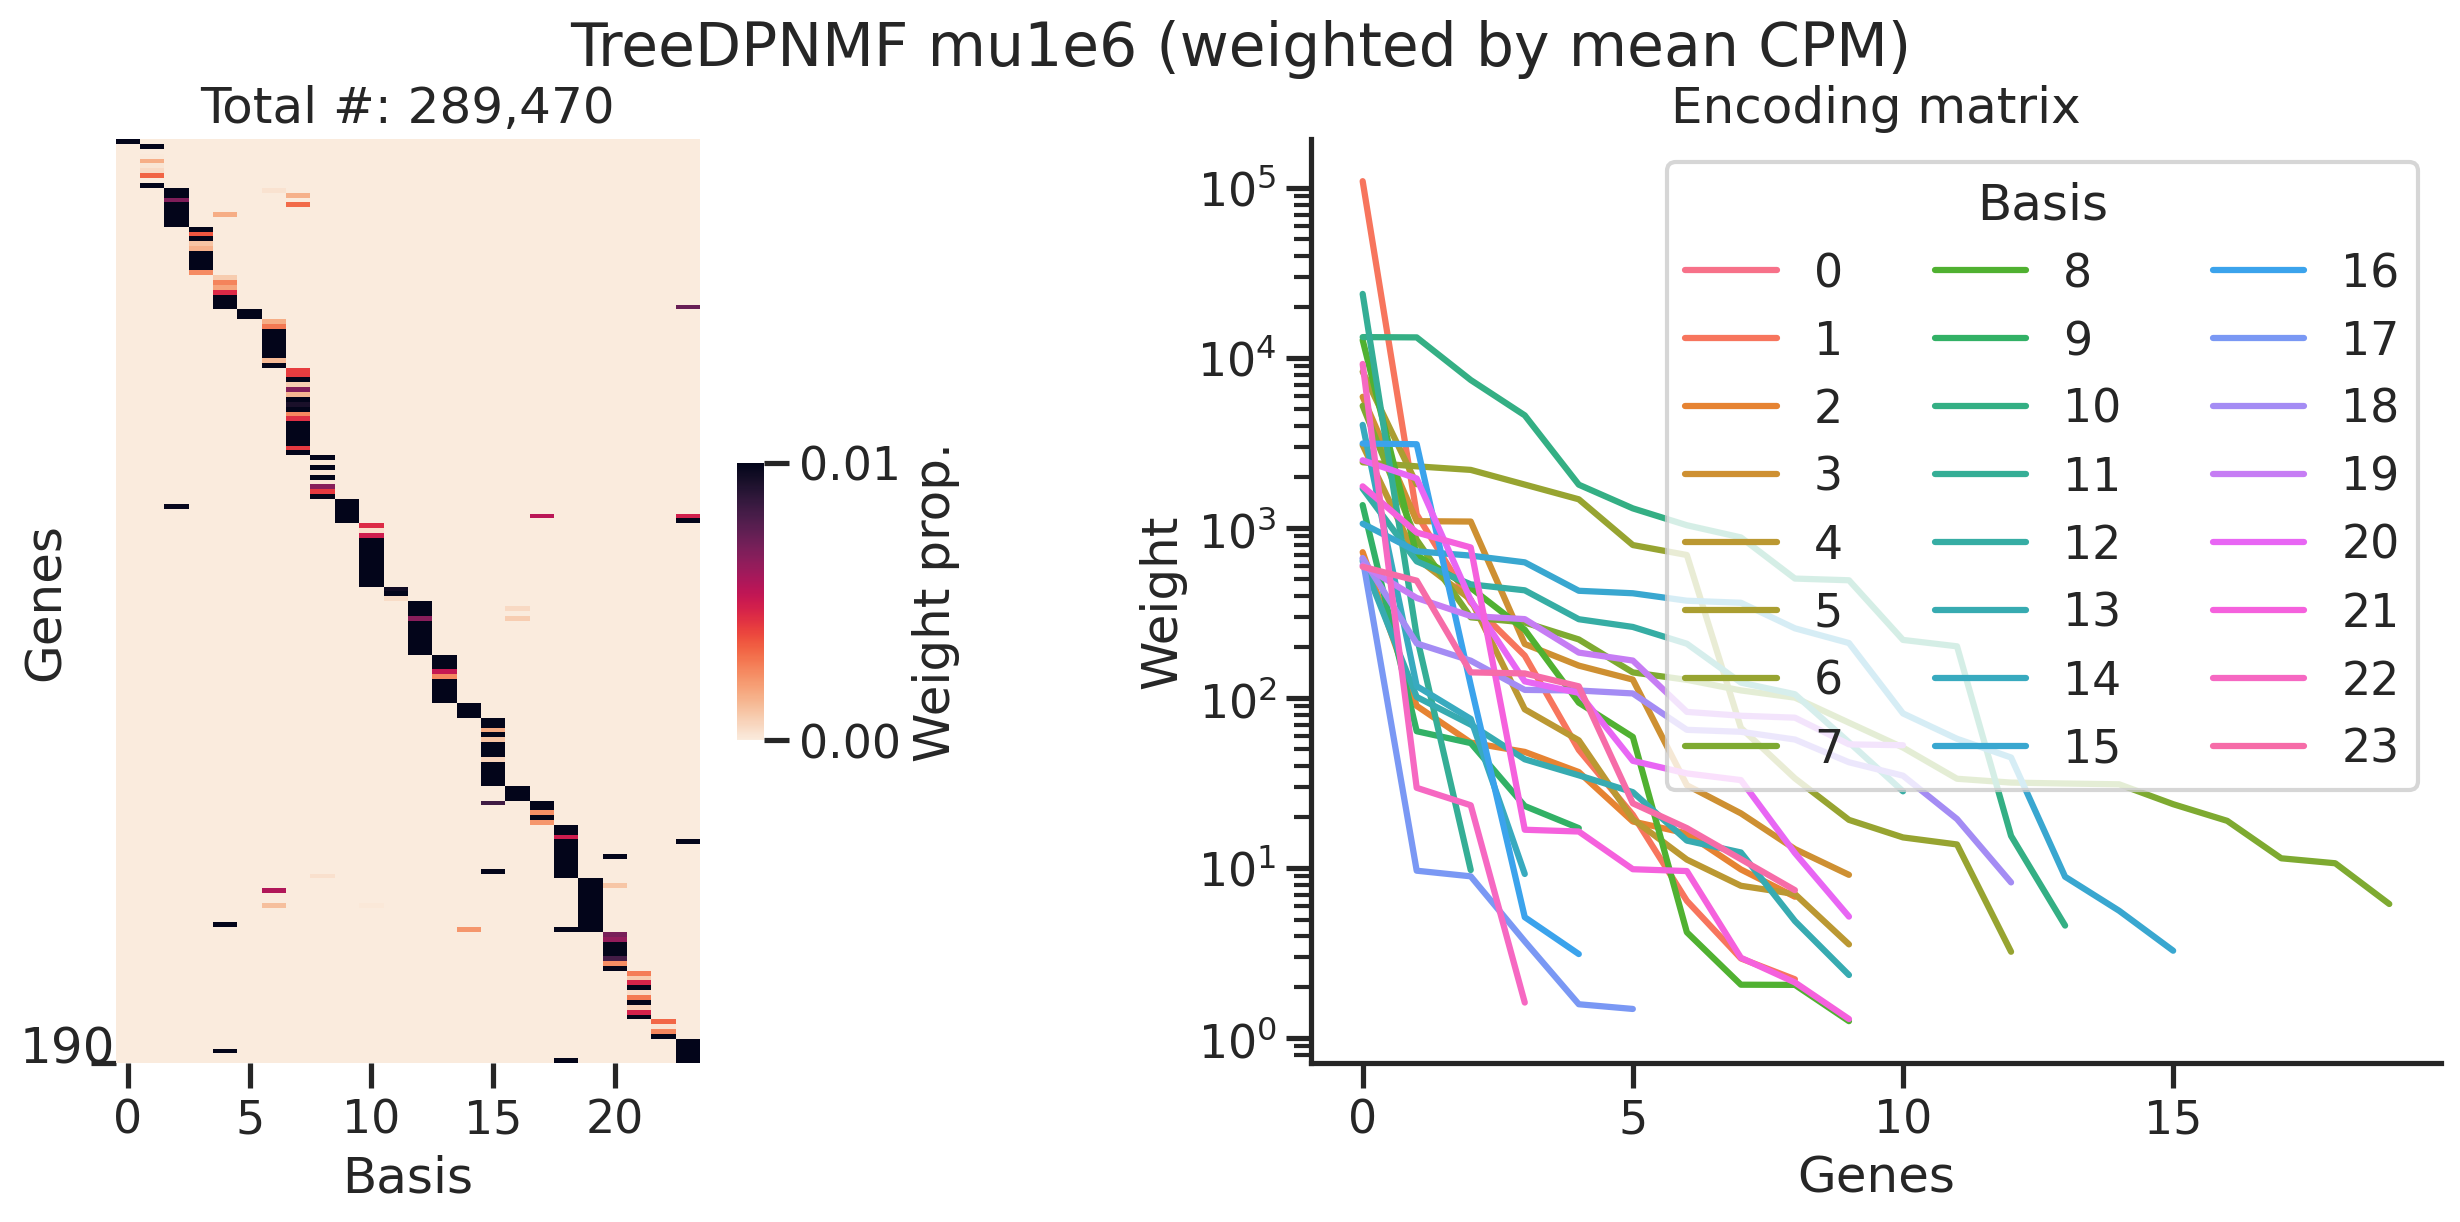

In [15]:
for meth, res_pnmf in res_all.items():
    genes_enc = res_pnmf.nzgenes
    gidx = basicu.get_index_from_array(genes_data, genes_enc) # query genes_enc from genes_data; -1 if not there
    weights_per_gene = np.hstack([ftrs_meancpm.numpy(), [0]])[gidx] # assign 0 weights if not in data
    
    res_pnmf.plot_enc()
    res_pnmf.plot_enc_weighted(weights_per_gene, tag='(weighted by mean CPM)')

Orig
PNMF
TreeDPNMF mu0
TreeDPNMF mu1e2
TreeDPNMF mu1e4
TreeDPNMF mu1e6


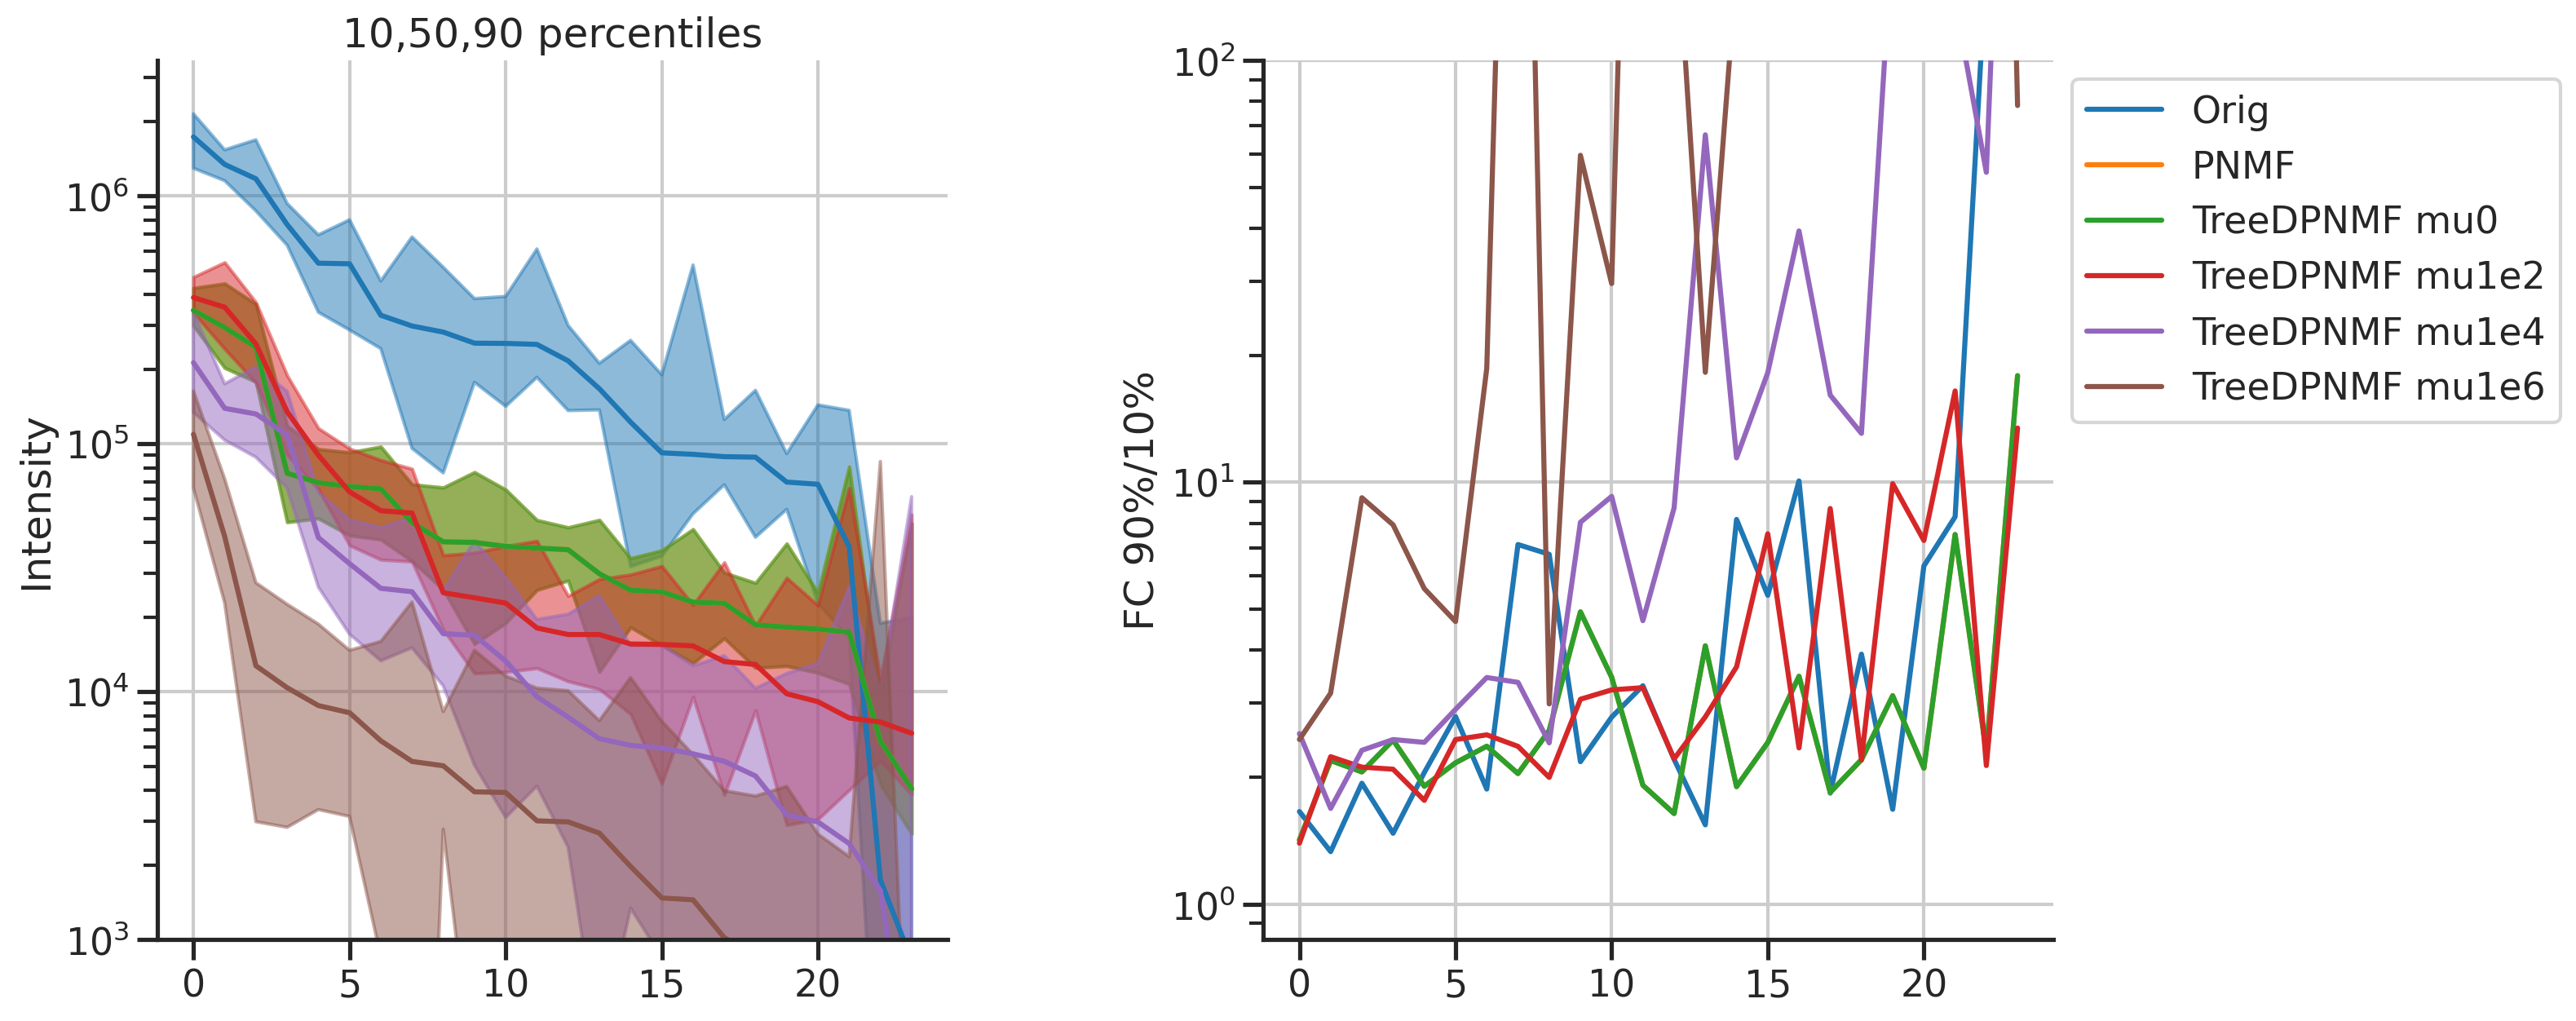

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax1, ax2 = axs
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    print(meth)
    prjx = res_pnmf.prjx
    color = res_pnmf.color
    plot_intn_v2(prjx, meth, color, ax1, ax2, ylim=[1e3, None])
fig.subplots_adjust(wspace=0.4)
plt.show()

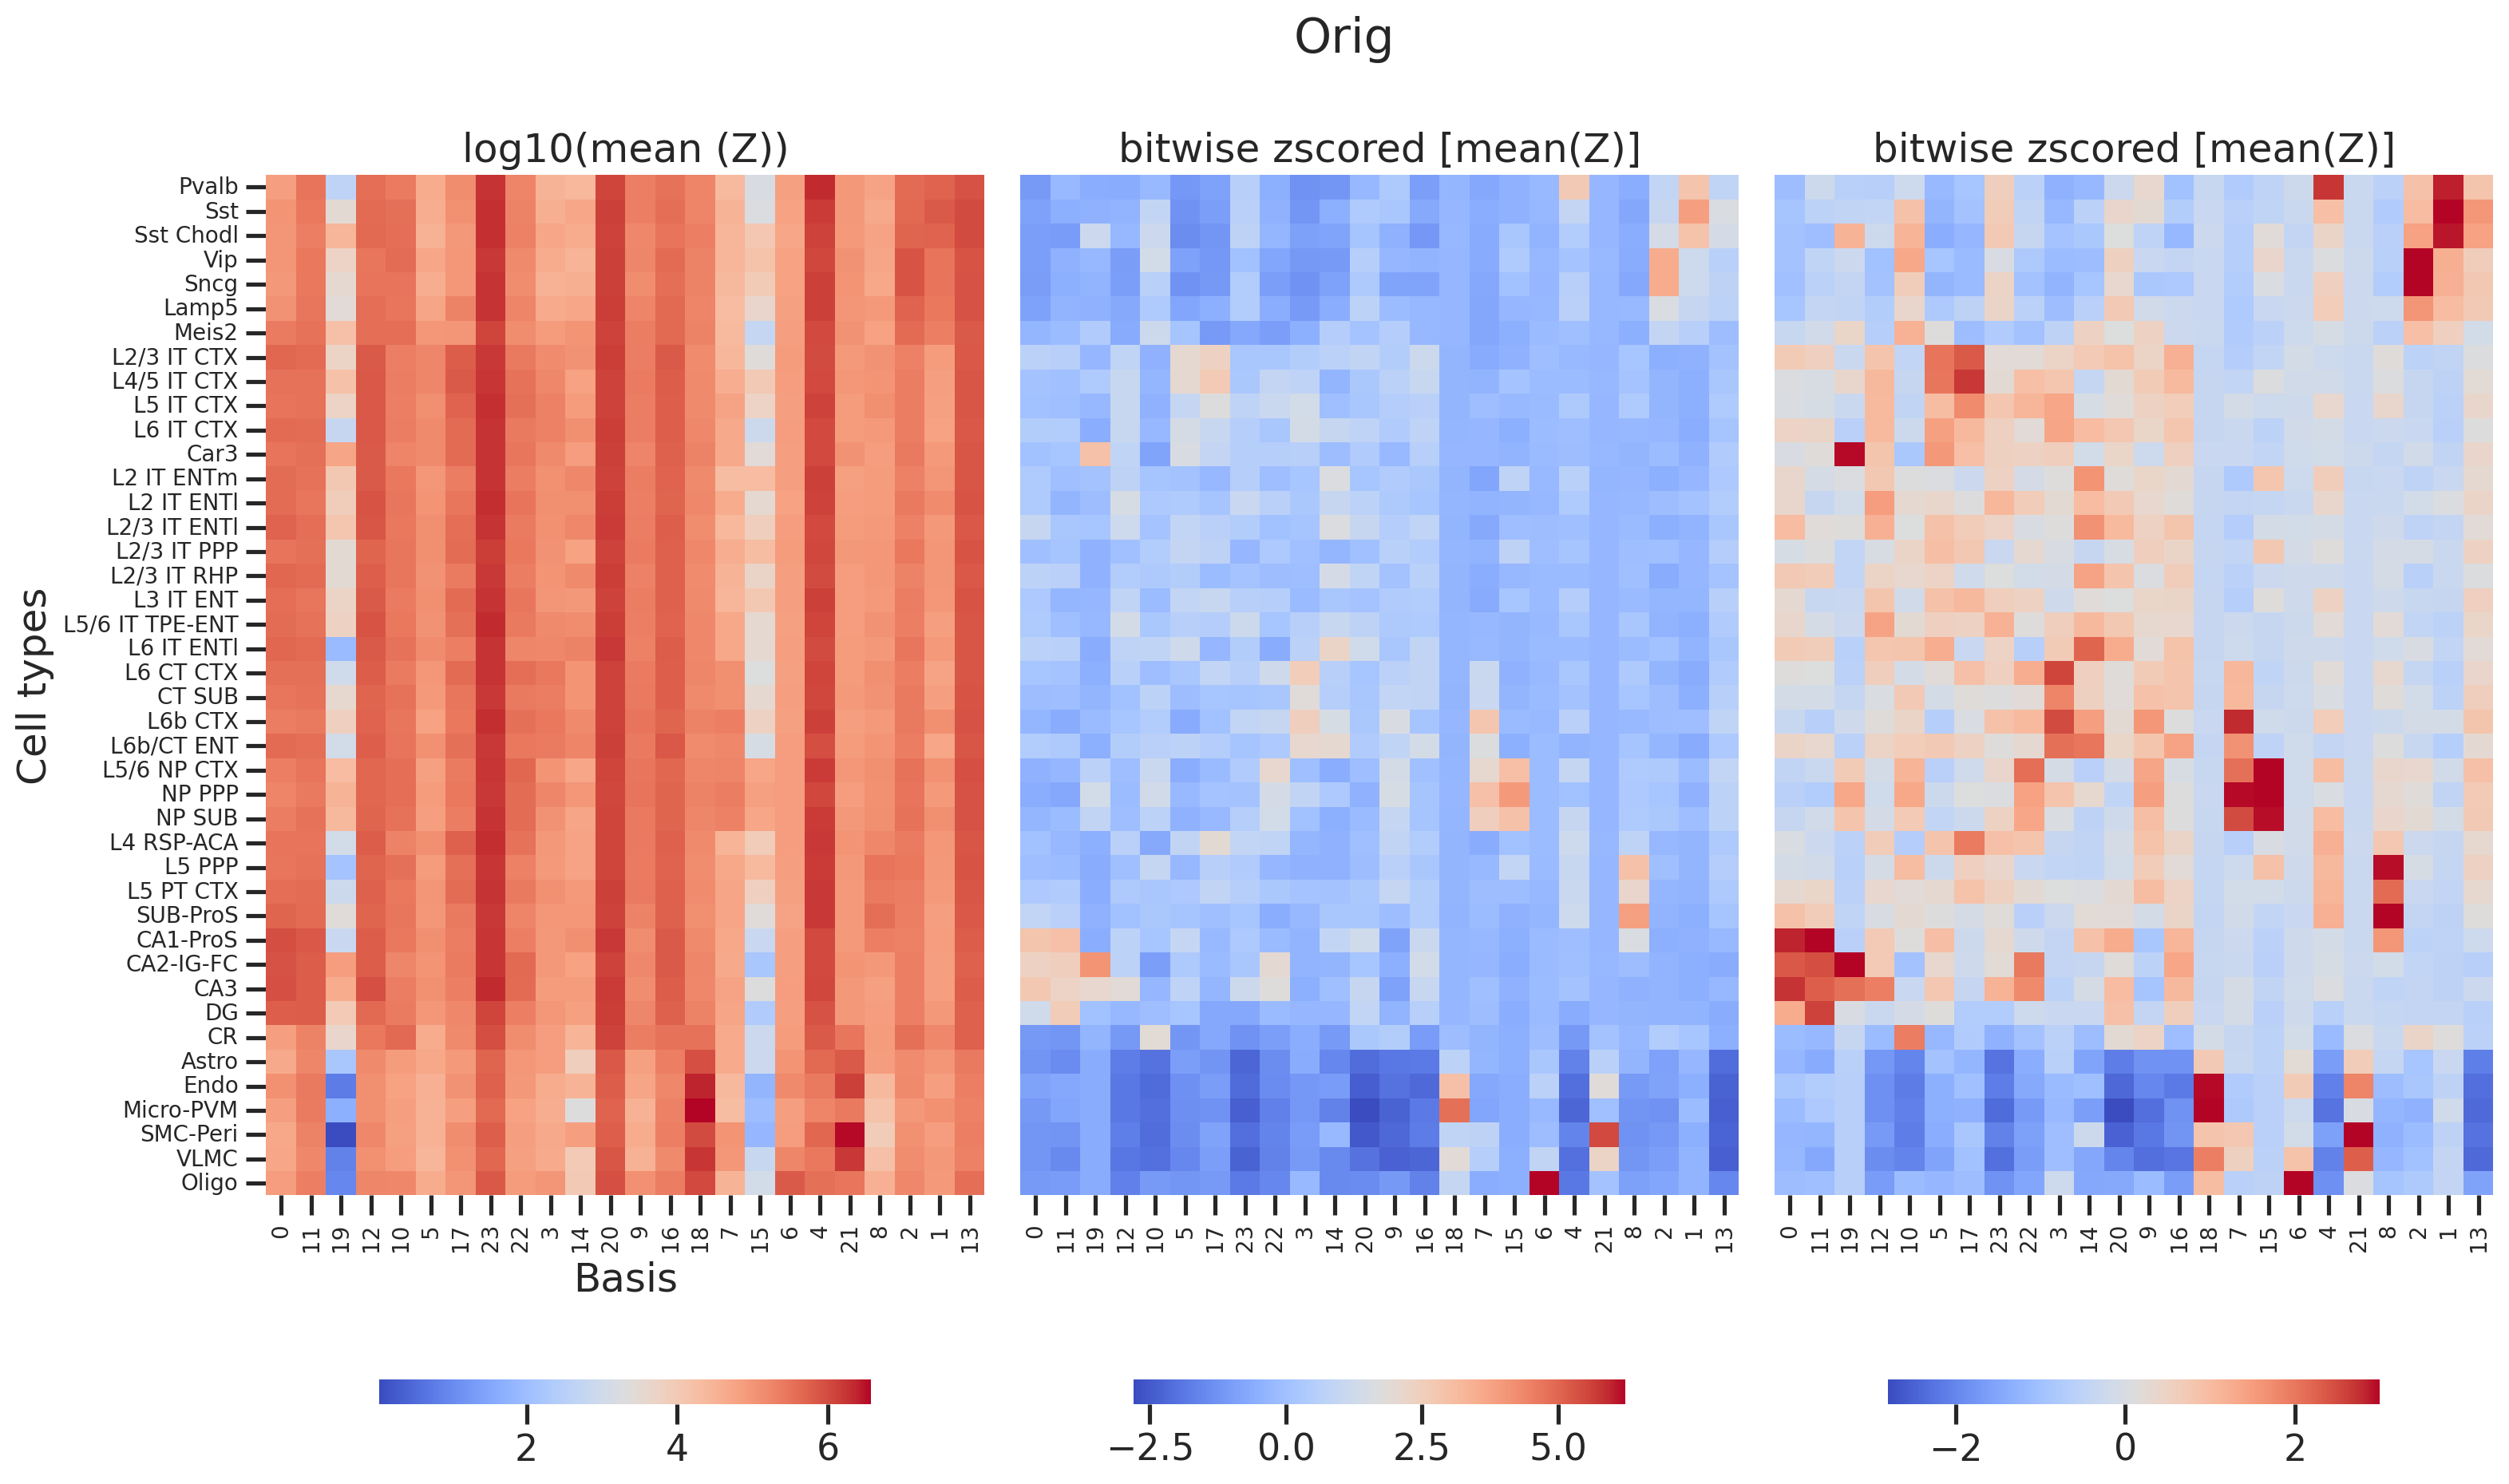

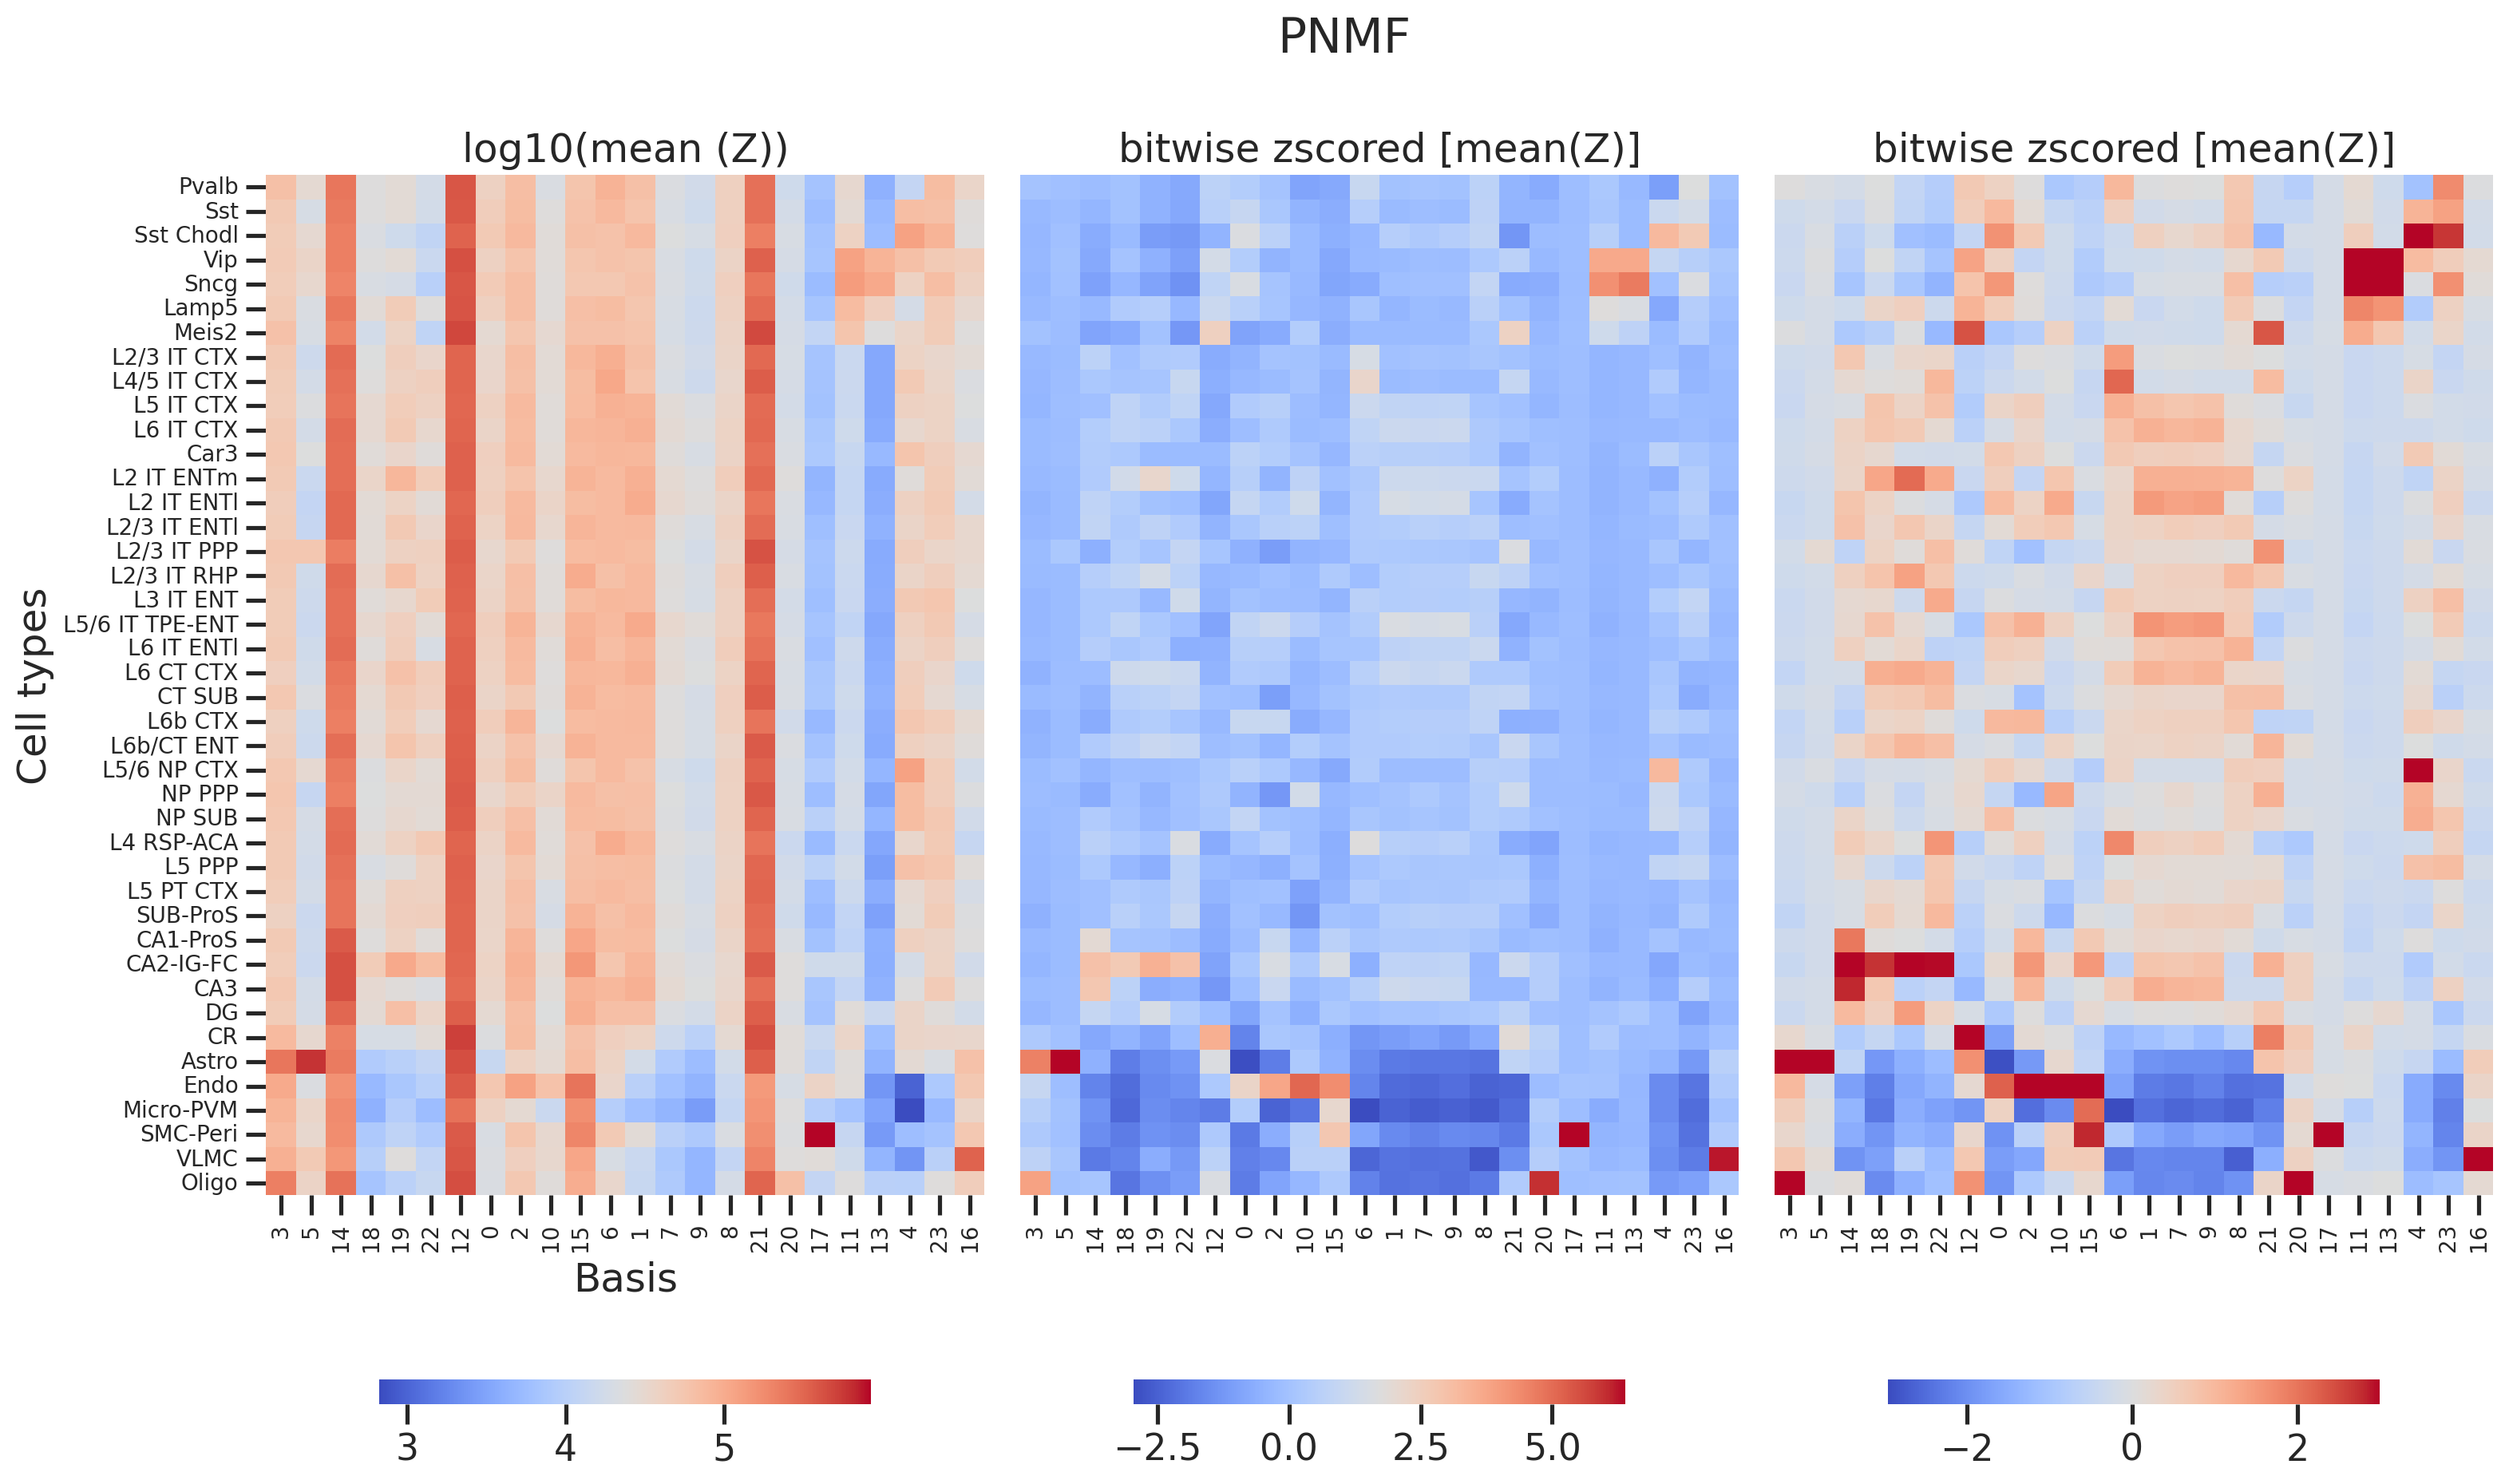

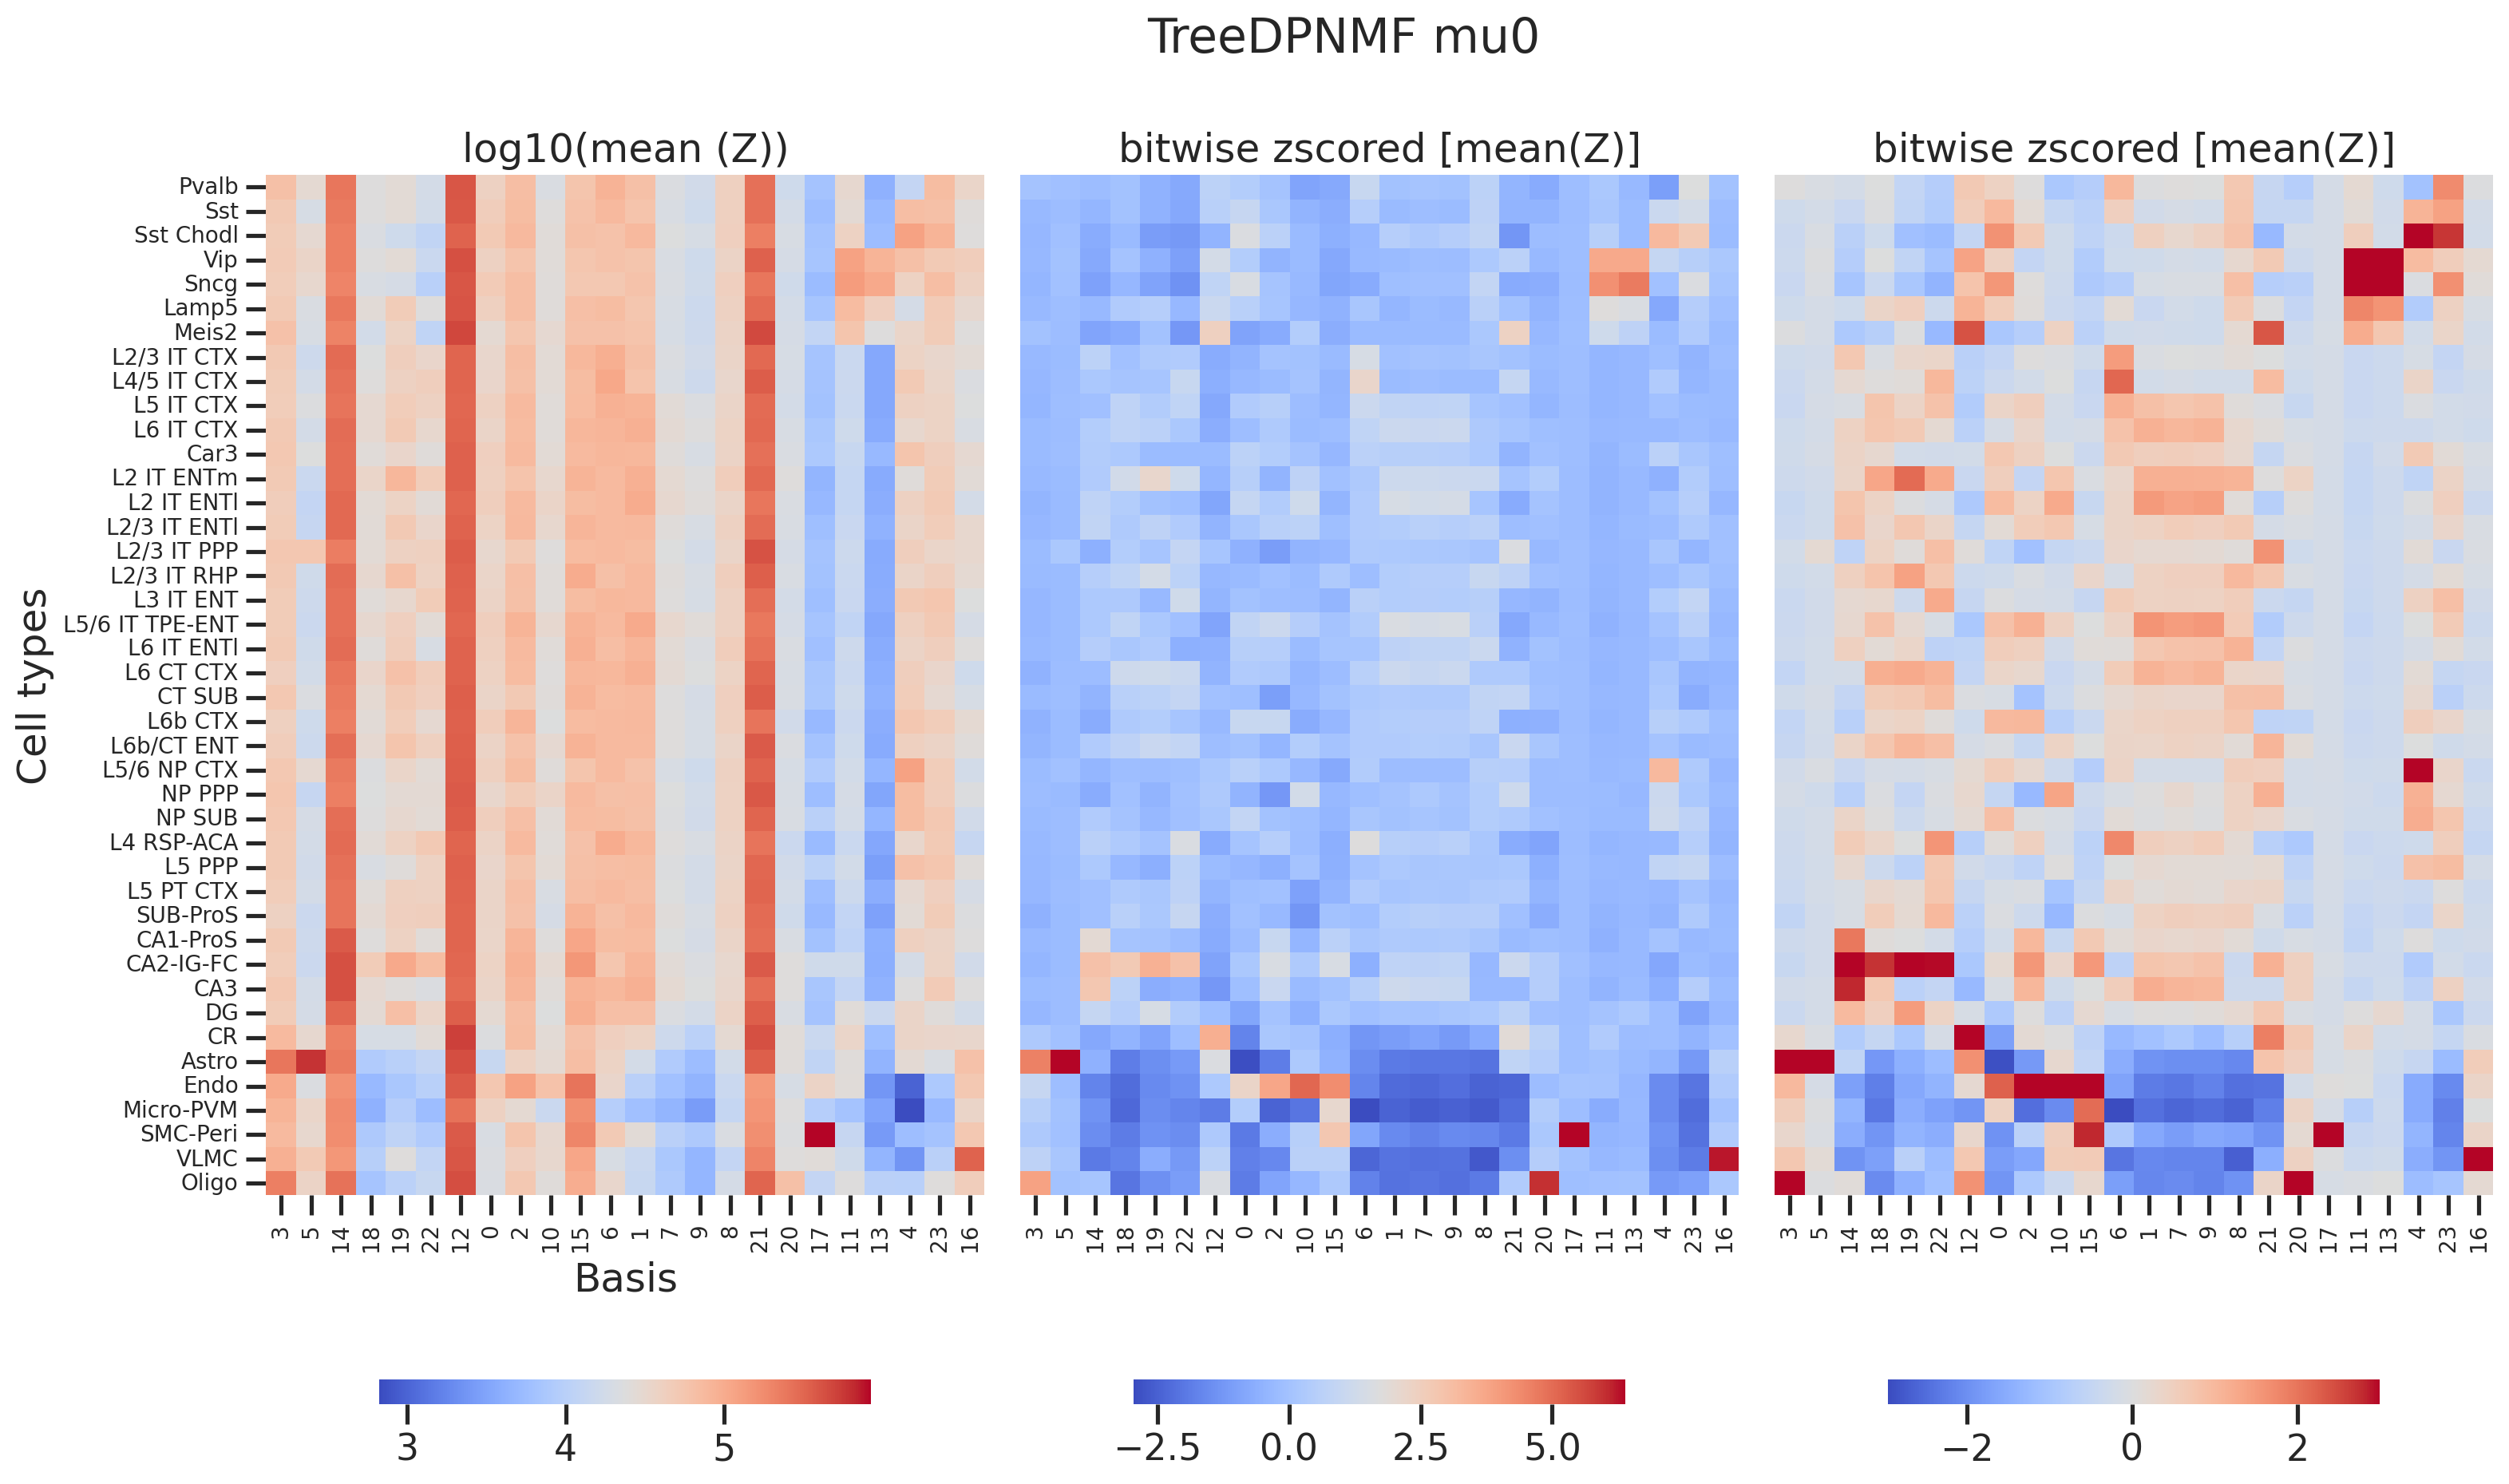

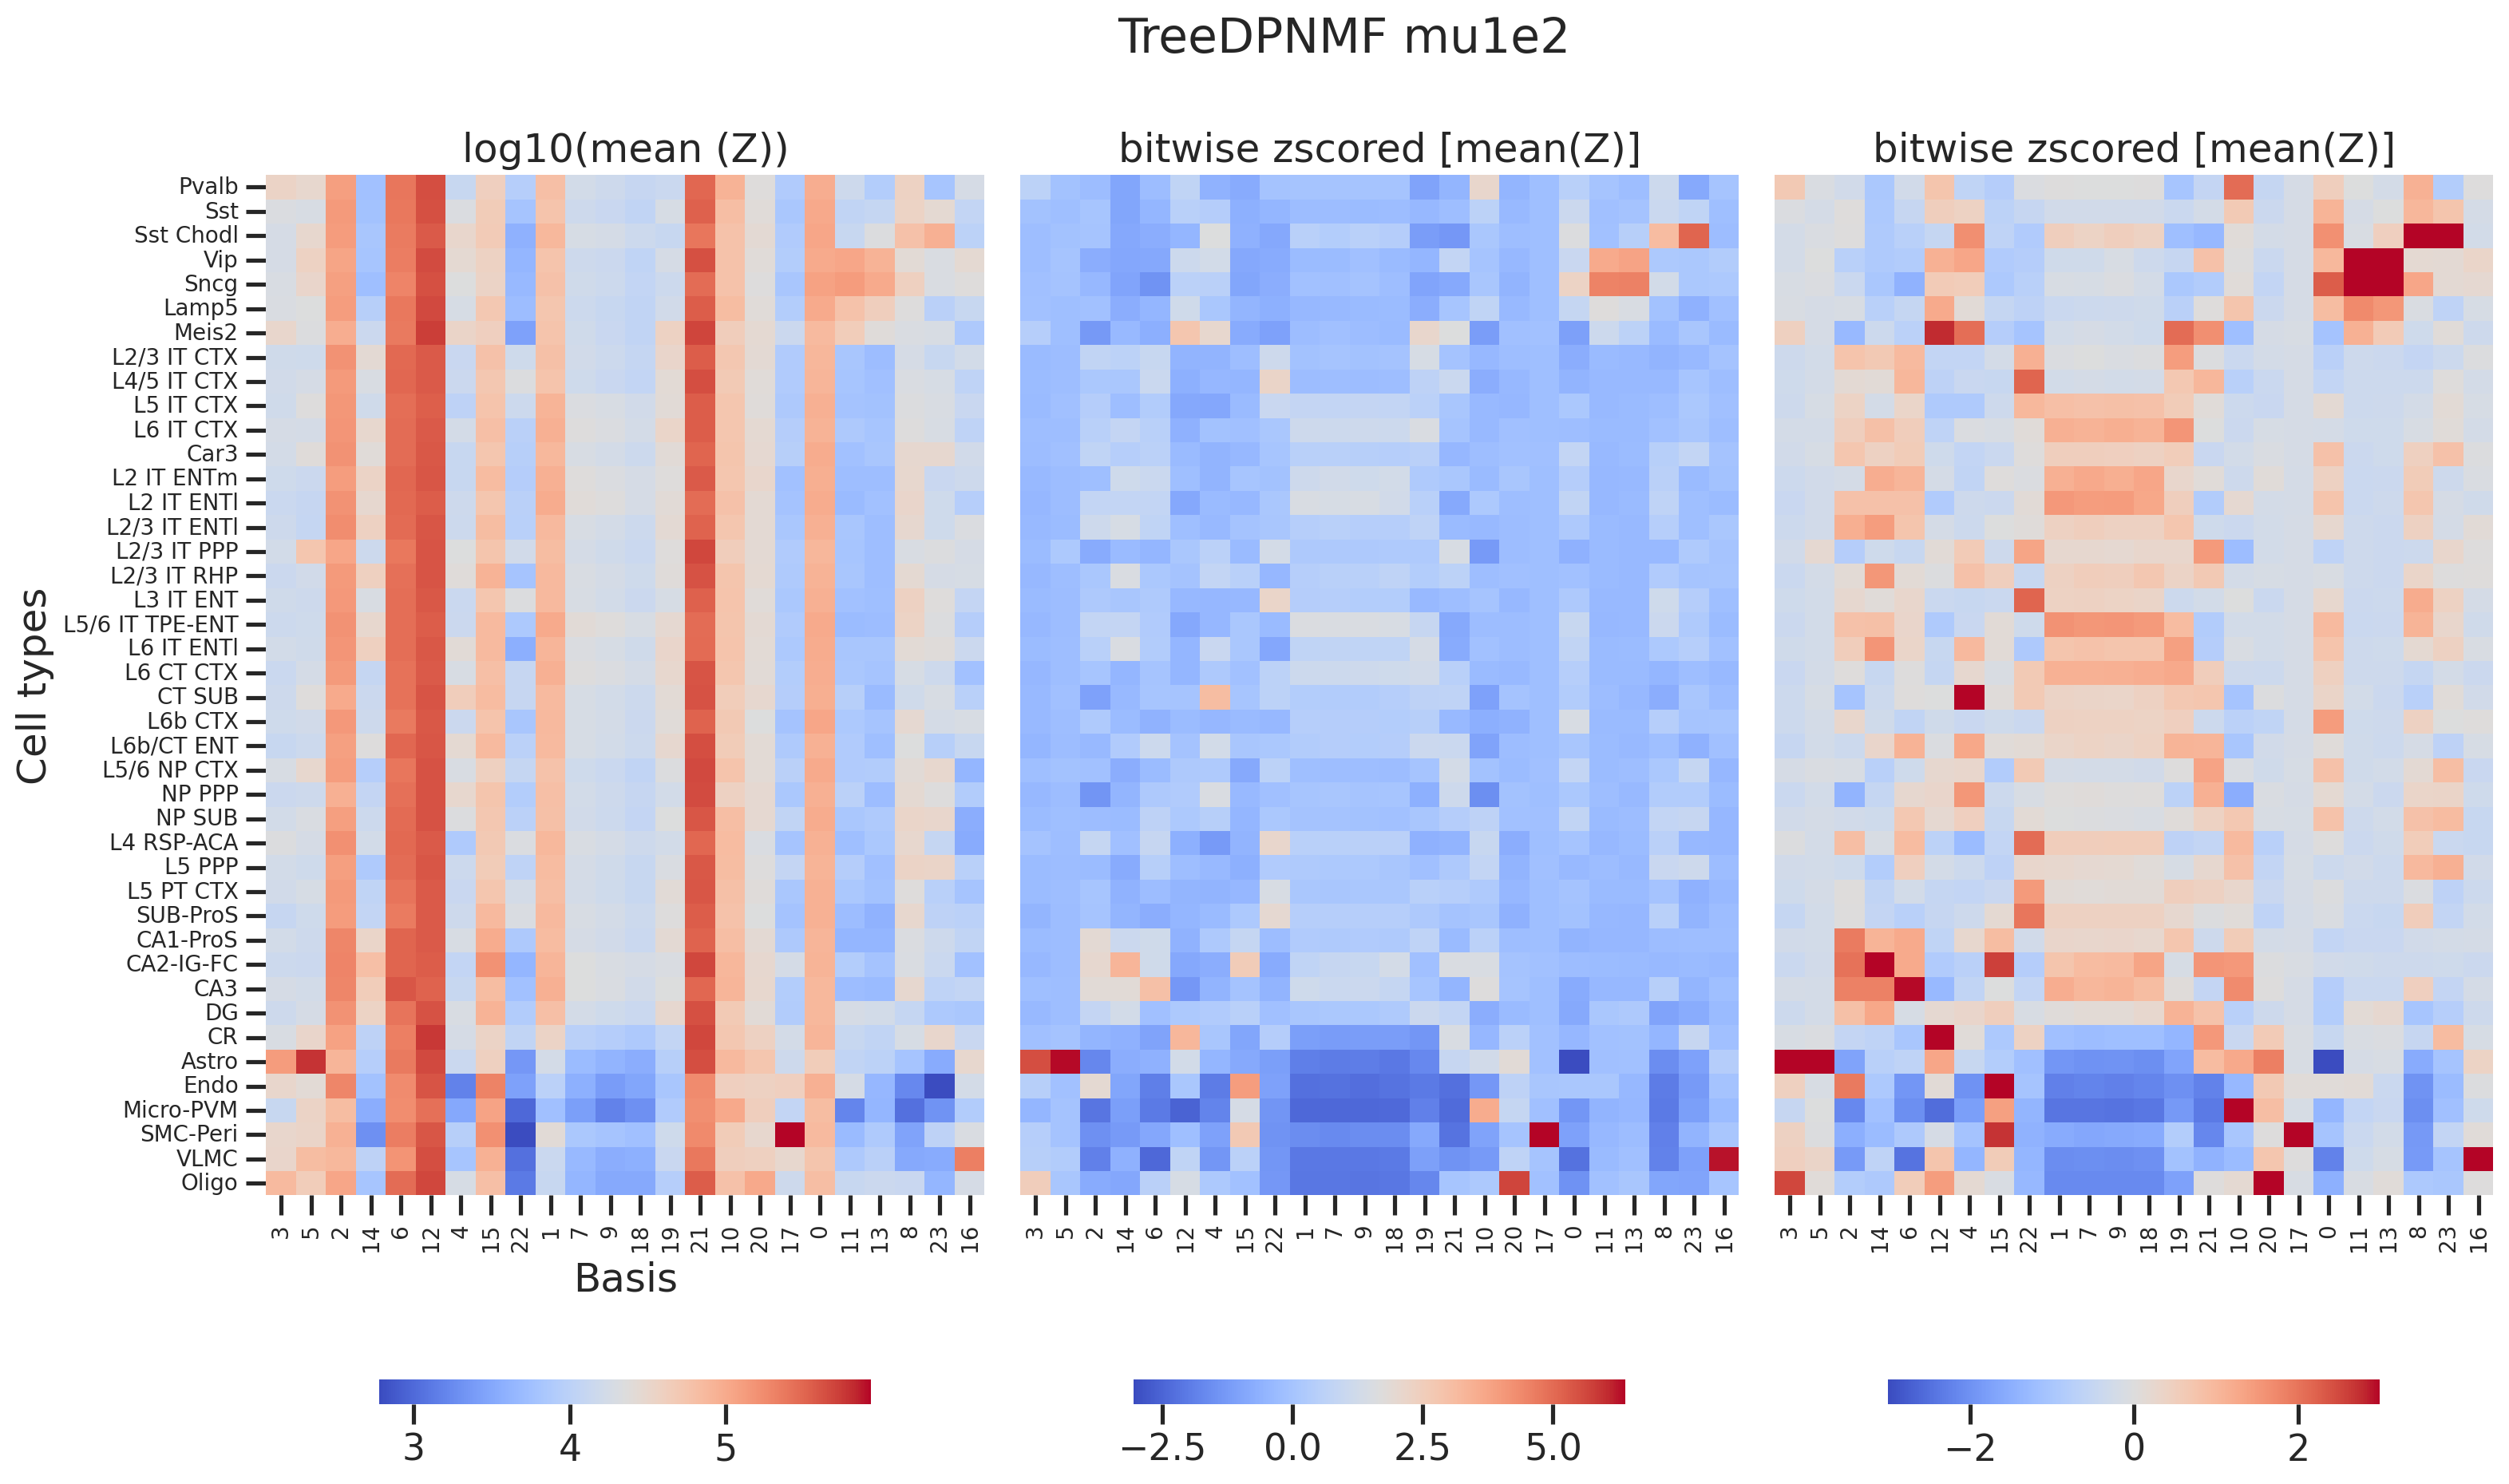

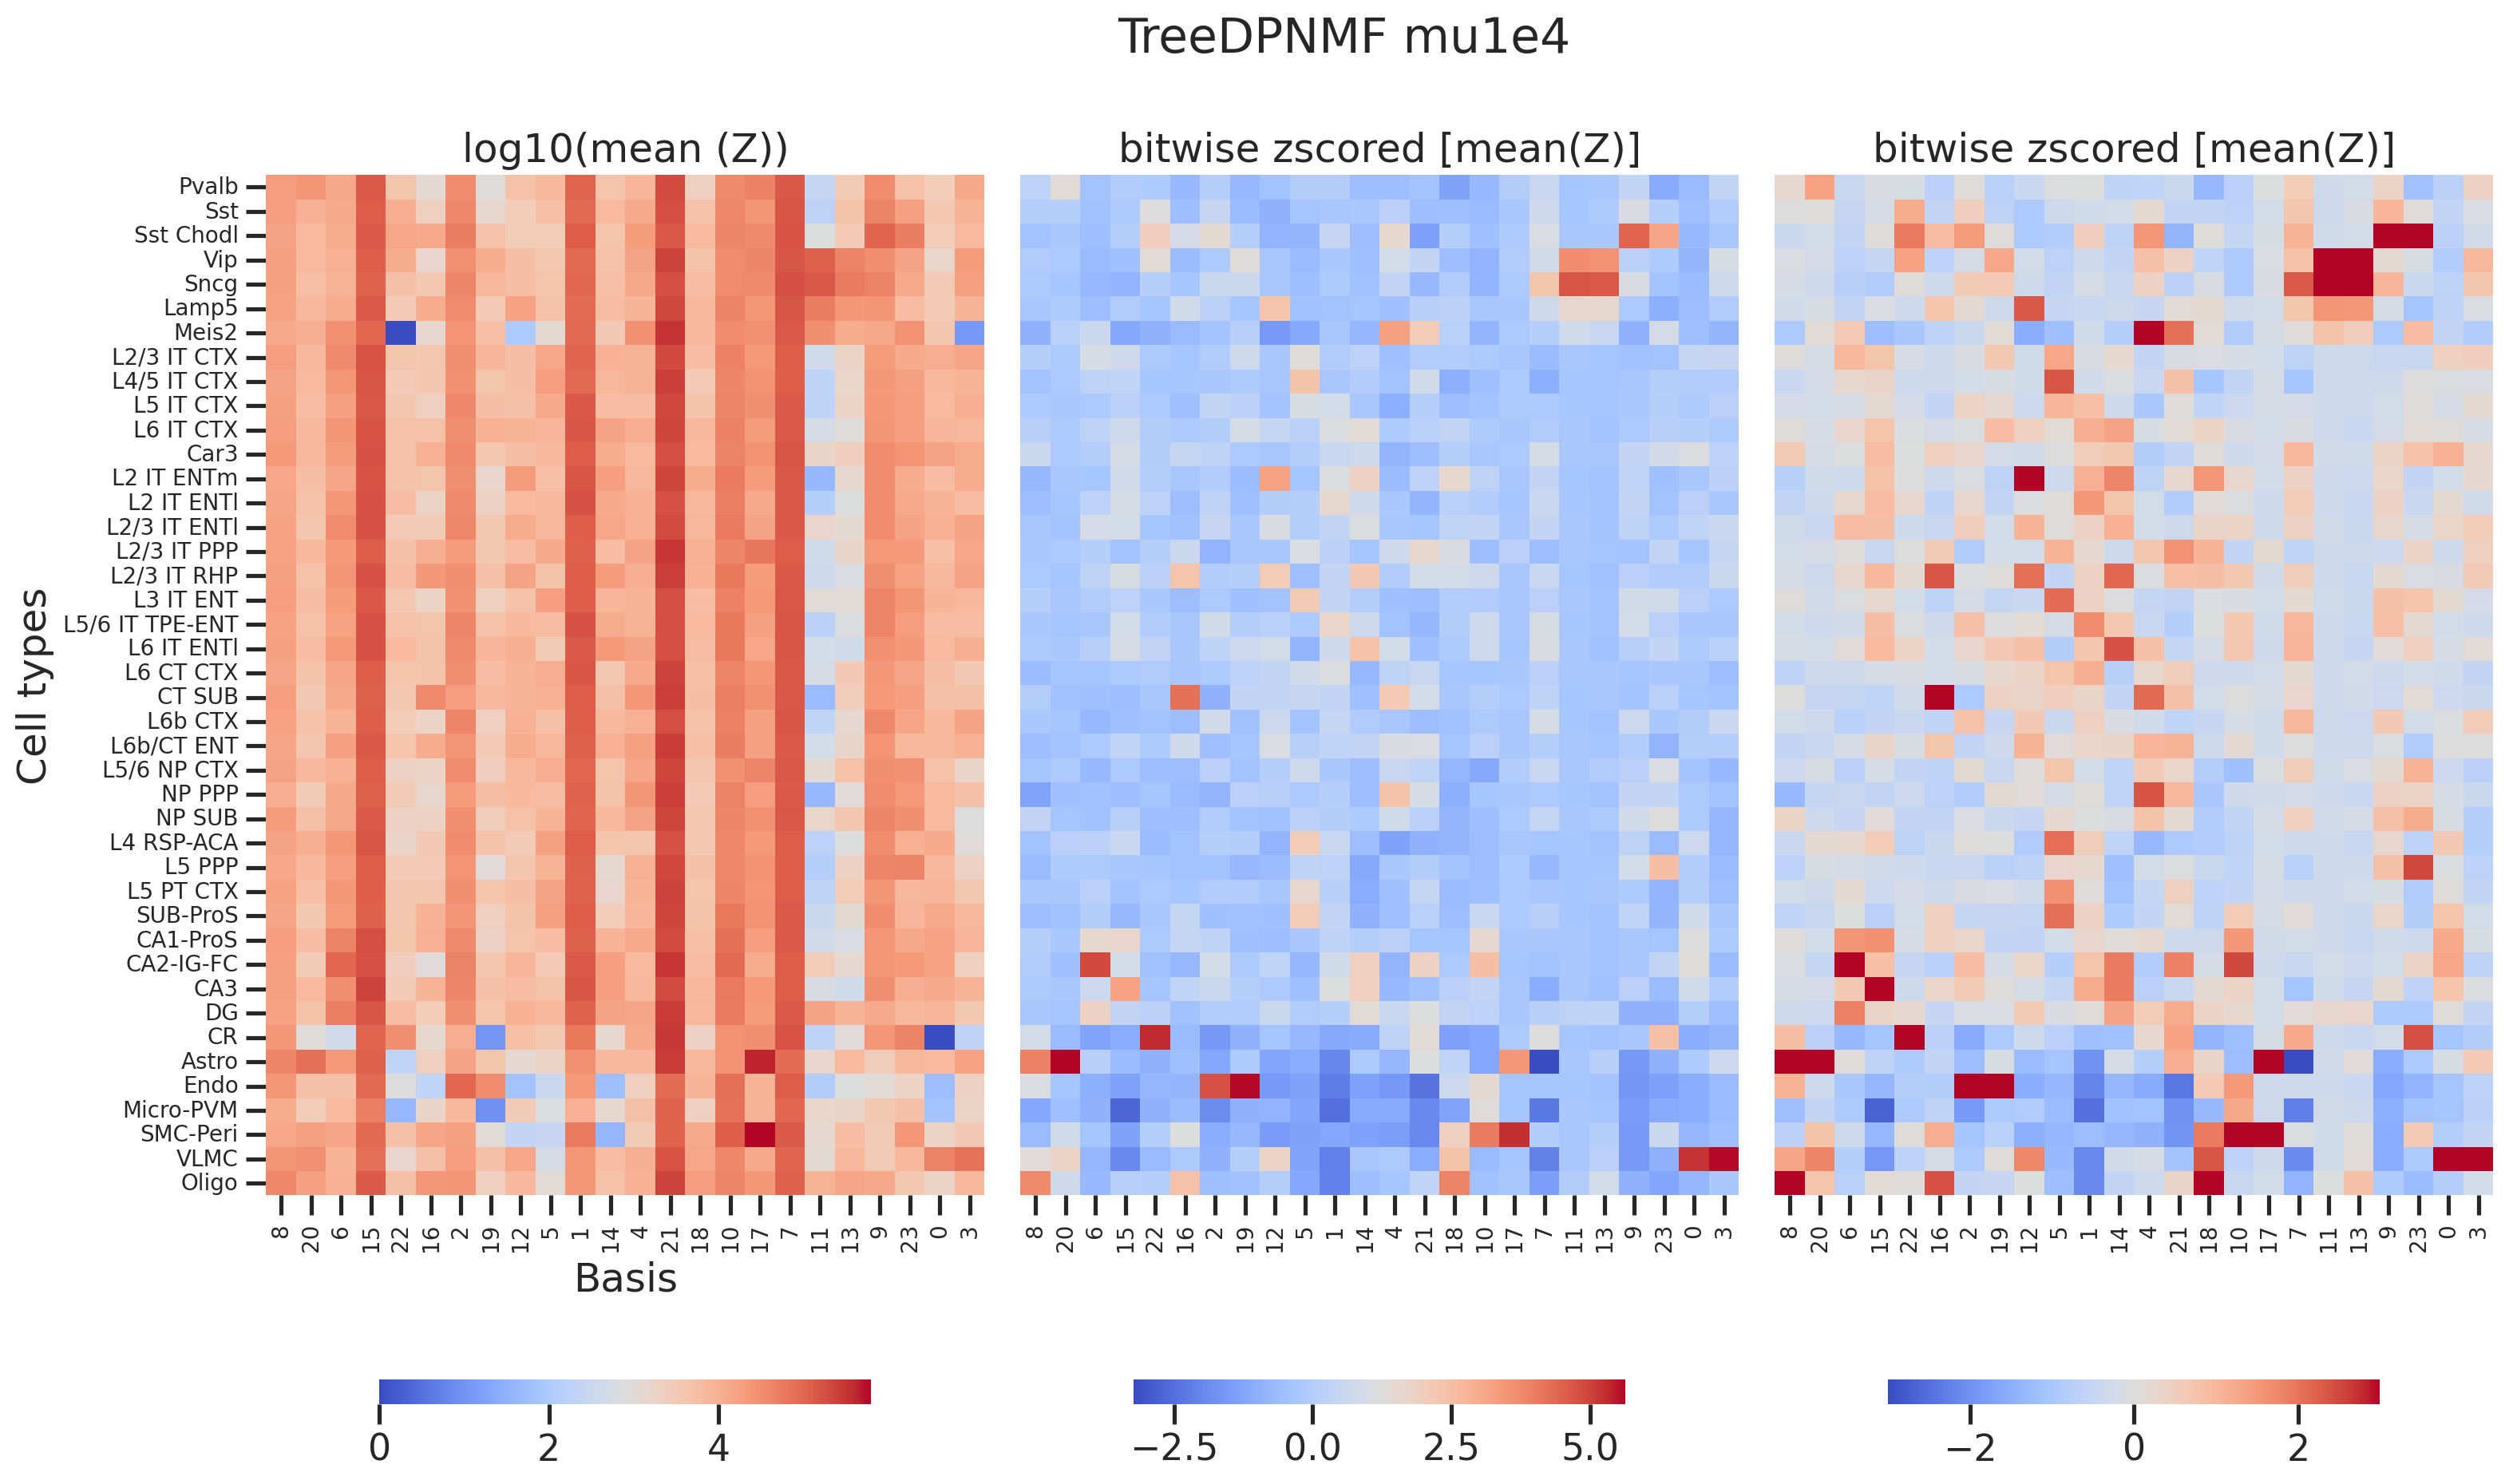

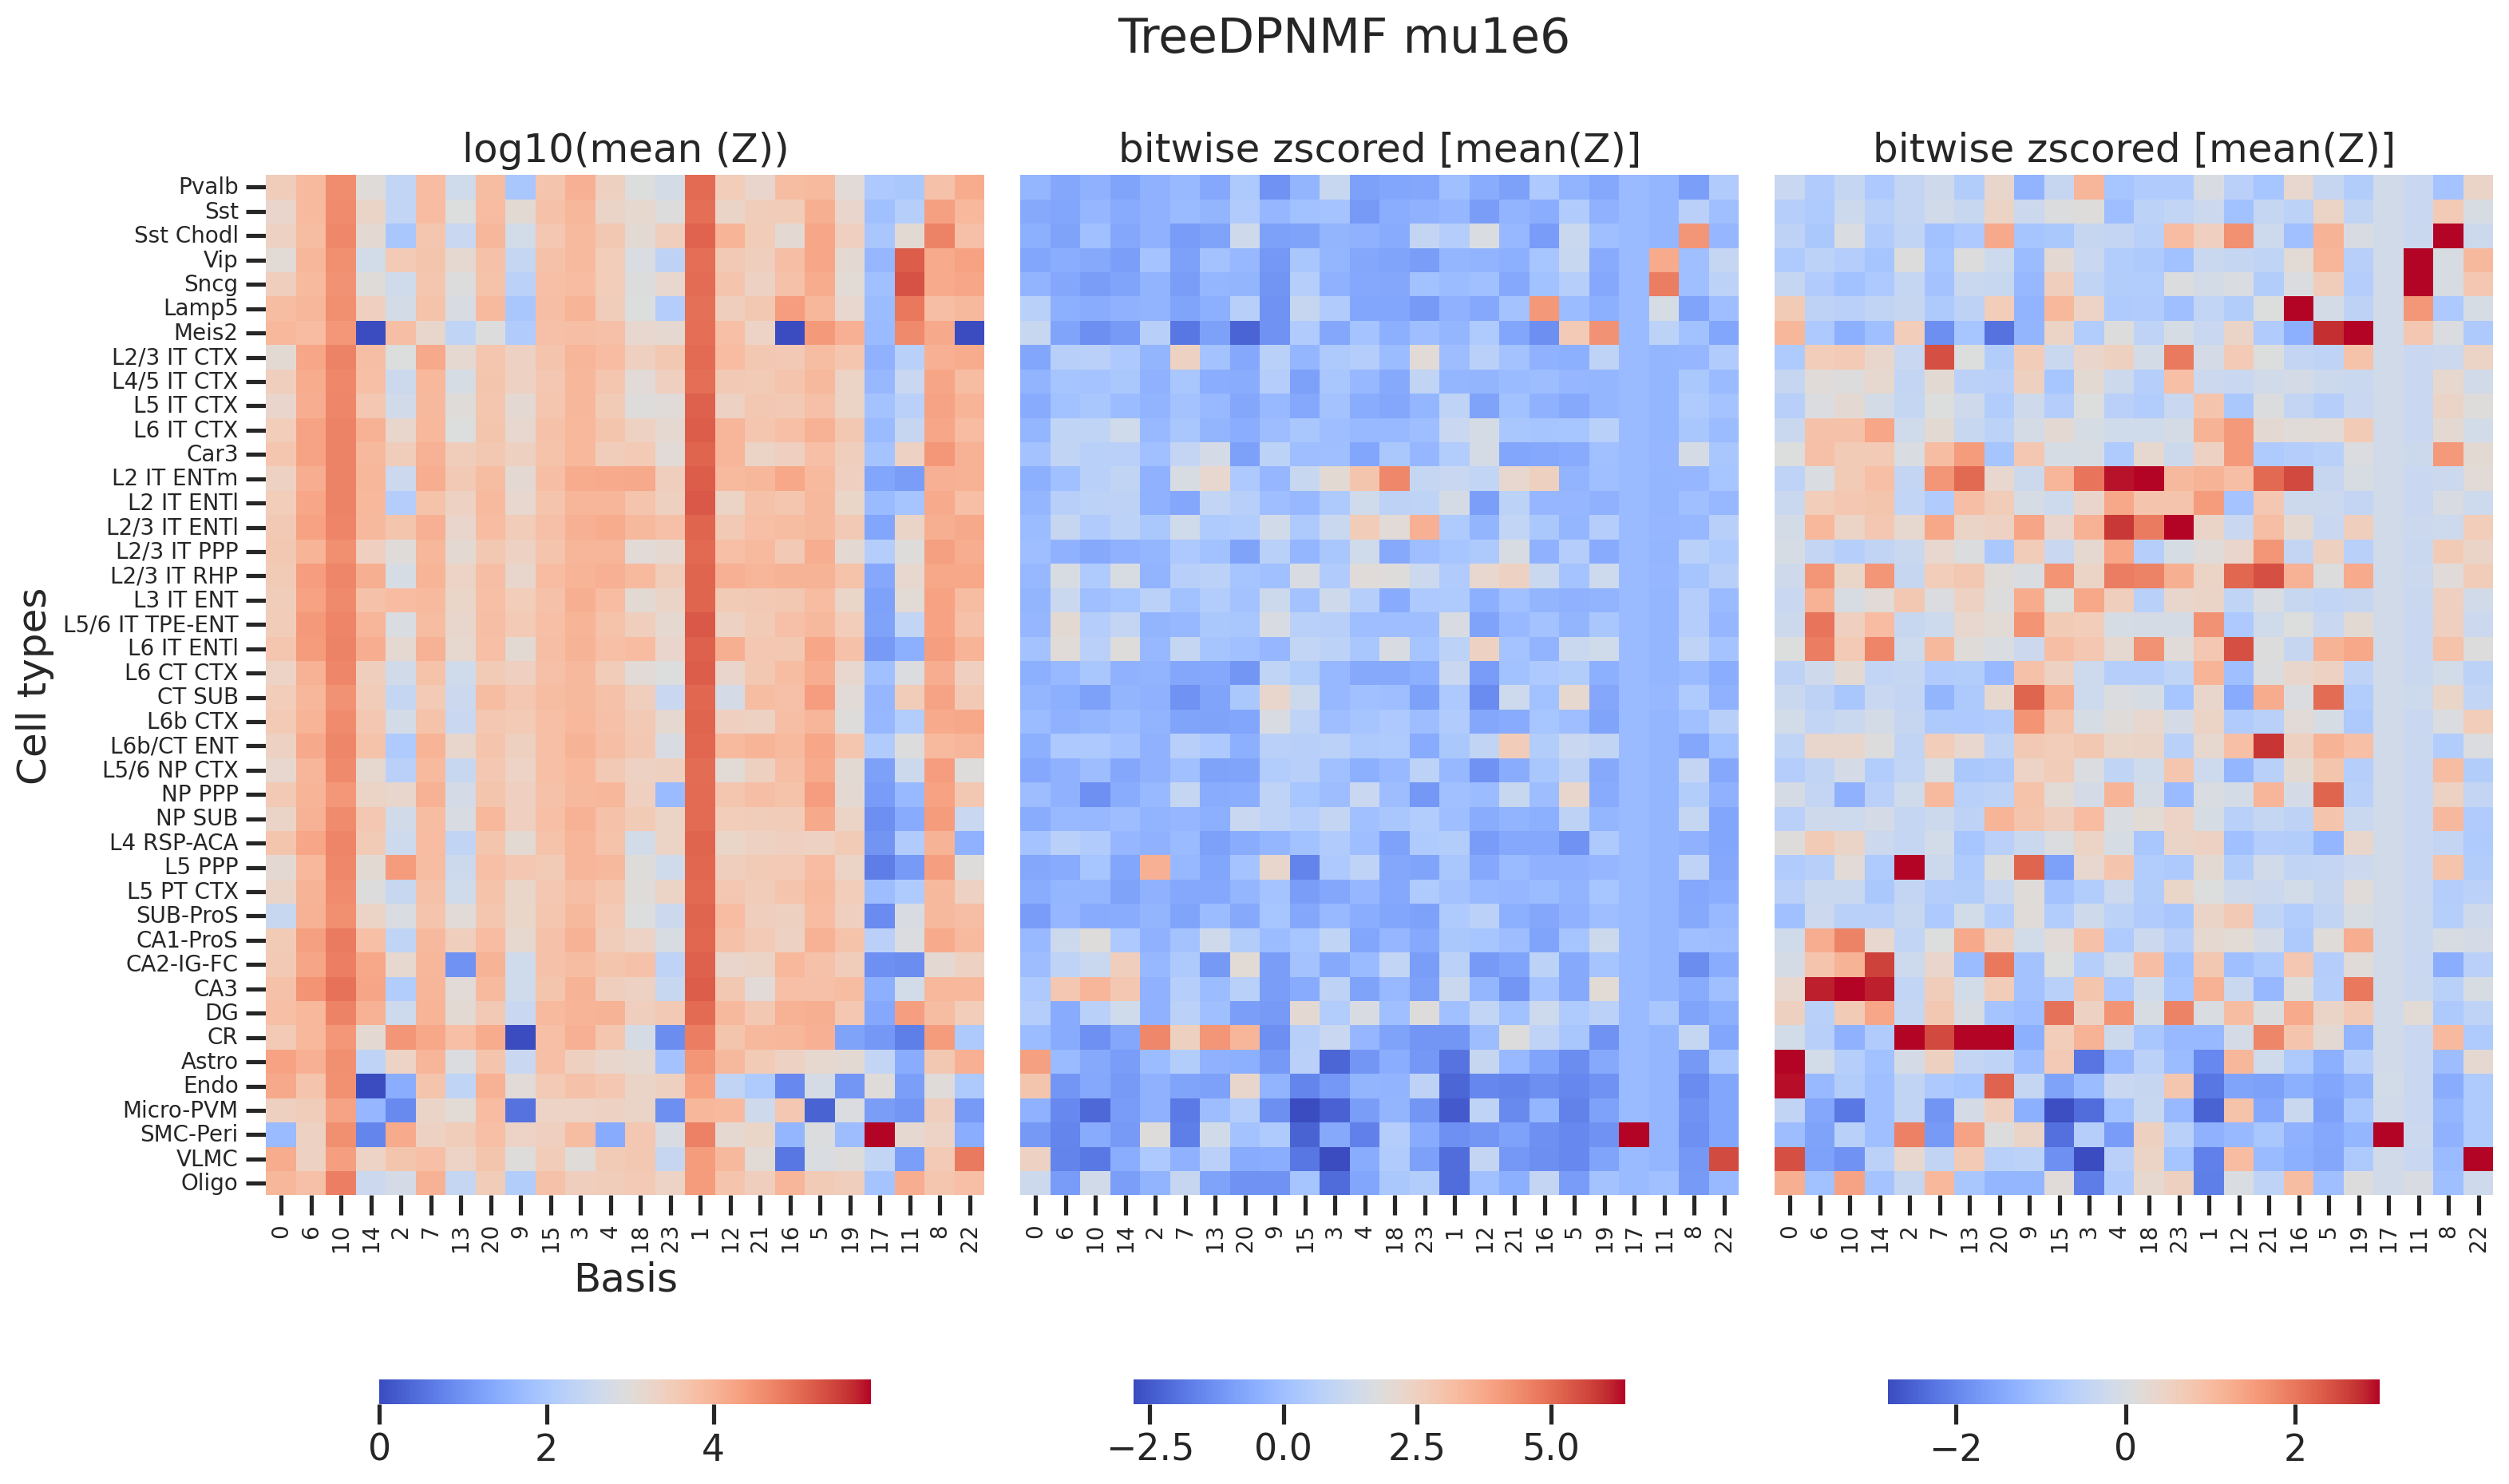

In [17]:
# diagnal ordering
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    designu.plot_embx_clsts(
                            res_pnmf.embx_clsts,
                            res_pnmf.embx_clsts_z,
                            res_pnmf.embx_clsts_z,
                            rownames=type_orders, # before rearange 
                            colnames=np.arange(24), # before rearange
                            _rows=_rows_l3clsts, # how to rearange
                            _cols=res_pnmf._dcols, #_dcols, #None, 
                            title=meth,
                            figsize=(3*6, 1*10),
                            title2='bitwise zscored [mean(Z)]',
                            title3='bitwise zscored [mean(Z)]',
                           )

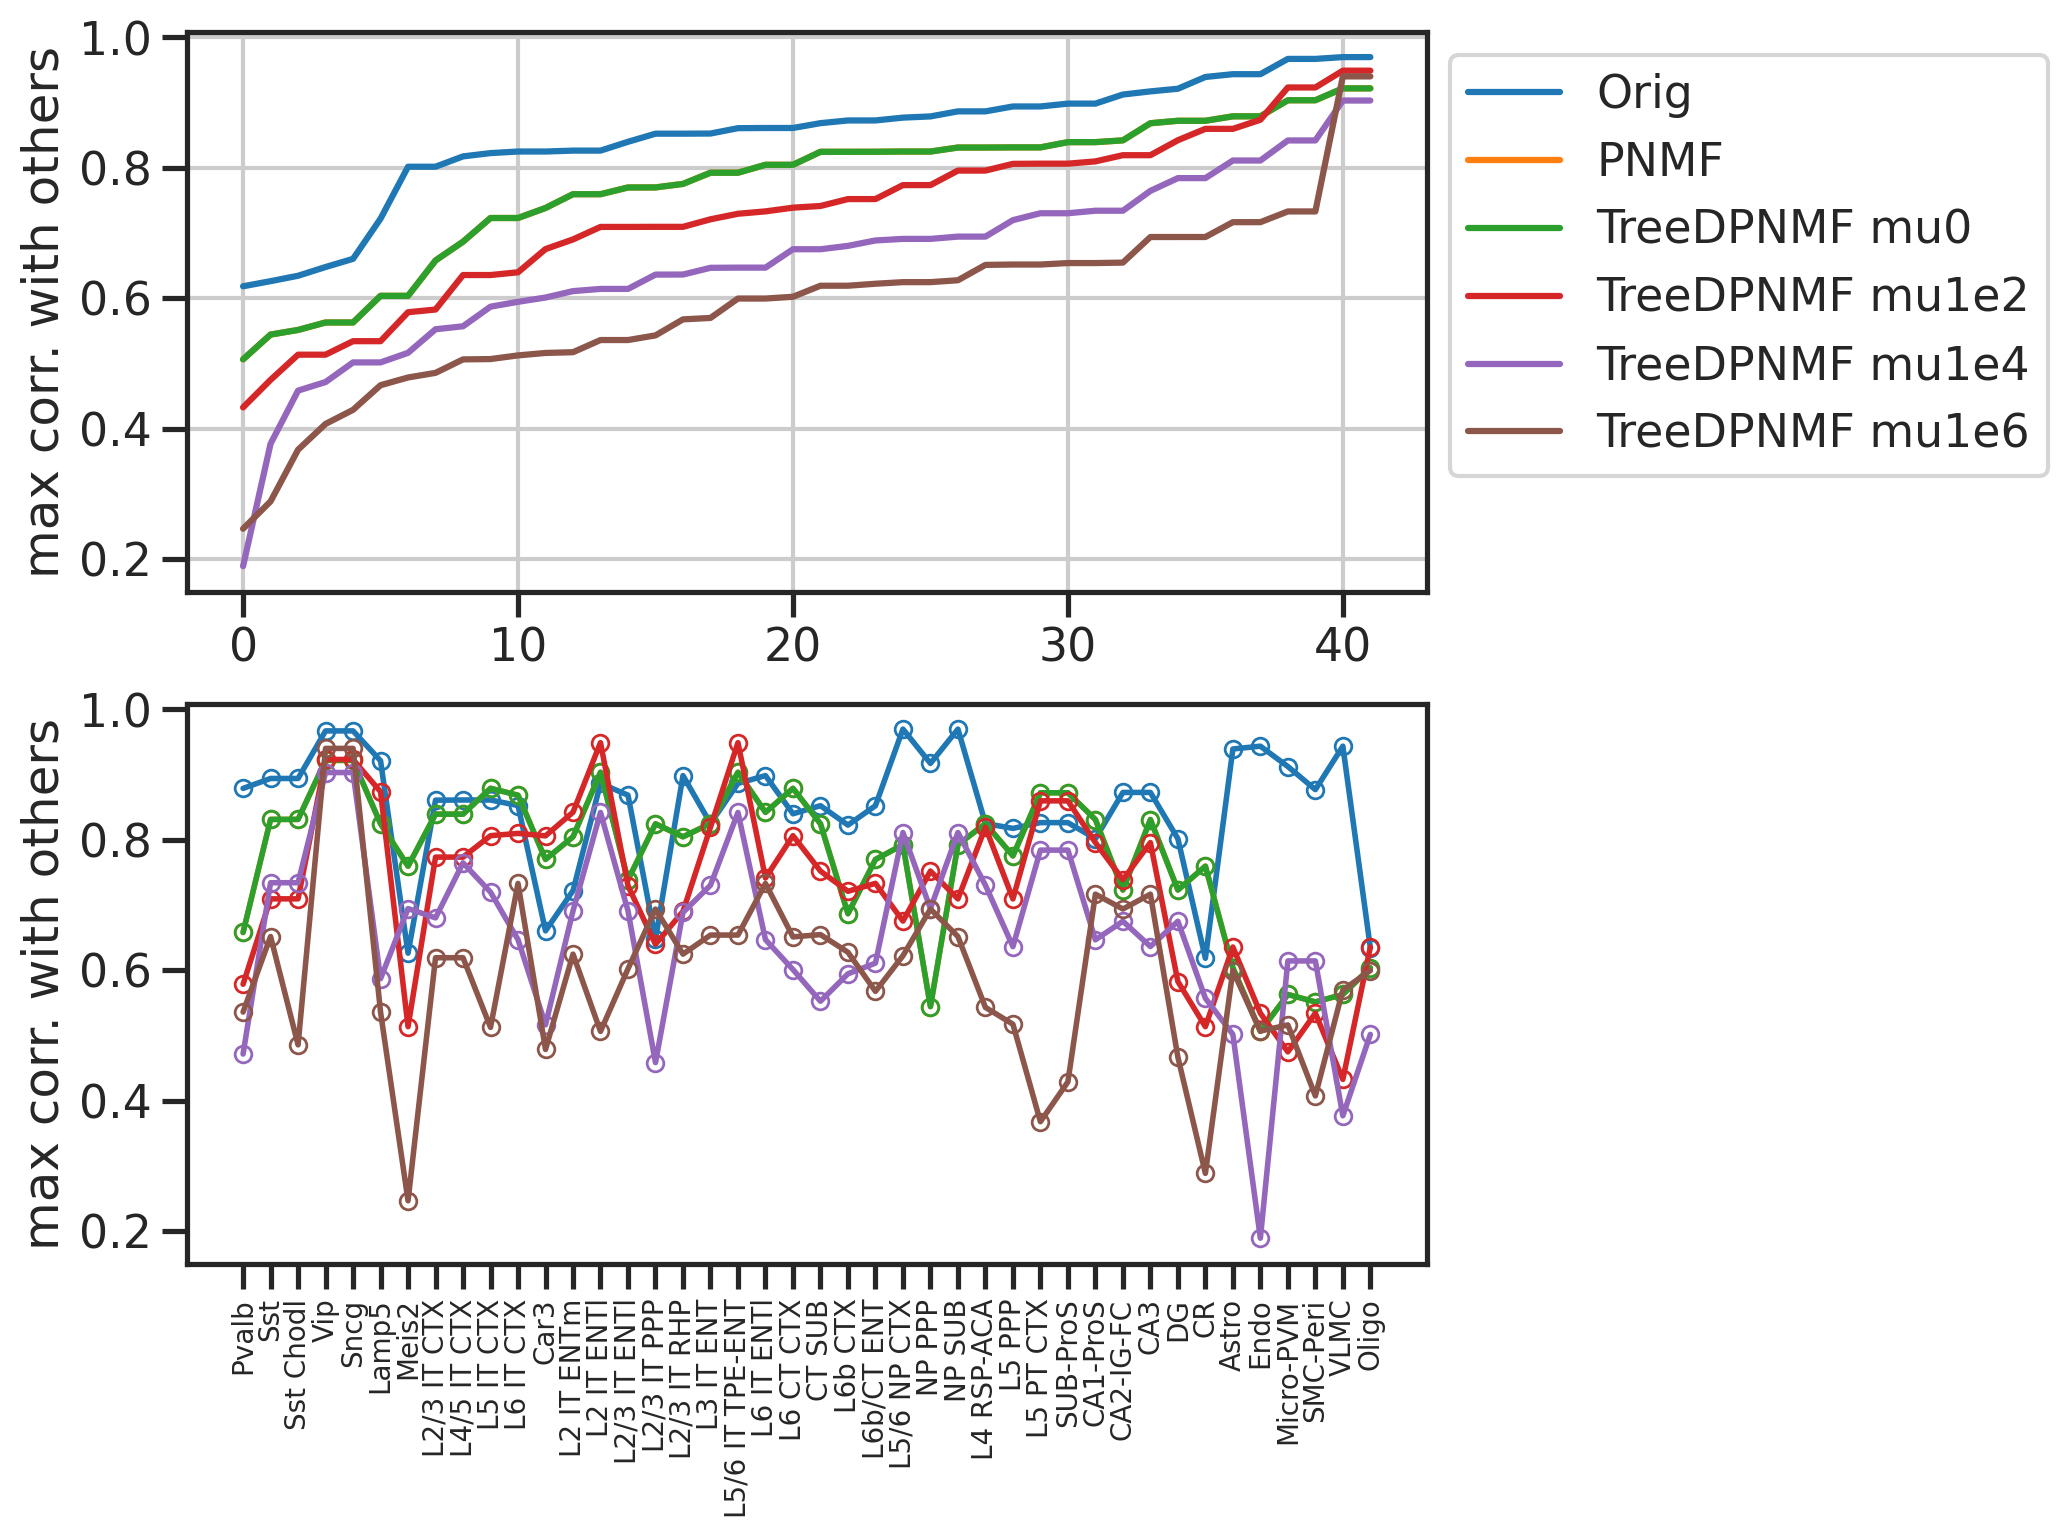

In [18]:
fig, axs = plt.subplots(2,1,figsize=(1*8,2*4))
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    corrmat = res_pnmf.embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts]
    color = res_pnmf.color
    
    # corr mat
    ax = axs[0]
    ax.plot(np.sort(np.sort(corrmat, axis=0)[-2]), label=meth, color=color)
    
    ax = axs[1]
    ax.plot(np.sort(corrmat, axis=0)[-2], '-o', label=meth, markersize=6, linewidth=2, fillstyle='none', color=color)
    ax.set_xticks(np.arange(len(corrmat)))
    ax.set_xticklabels(l3clst_order, rotation=90, fontsize=10)
    ax.grid(False)
    
axs[0].legend(bbox_to_anchor=(1,1))
axs[0].set_ylabel('max corr. with others')
axs[1].set_ylabel('max corr. with others')
plt.show()

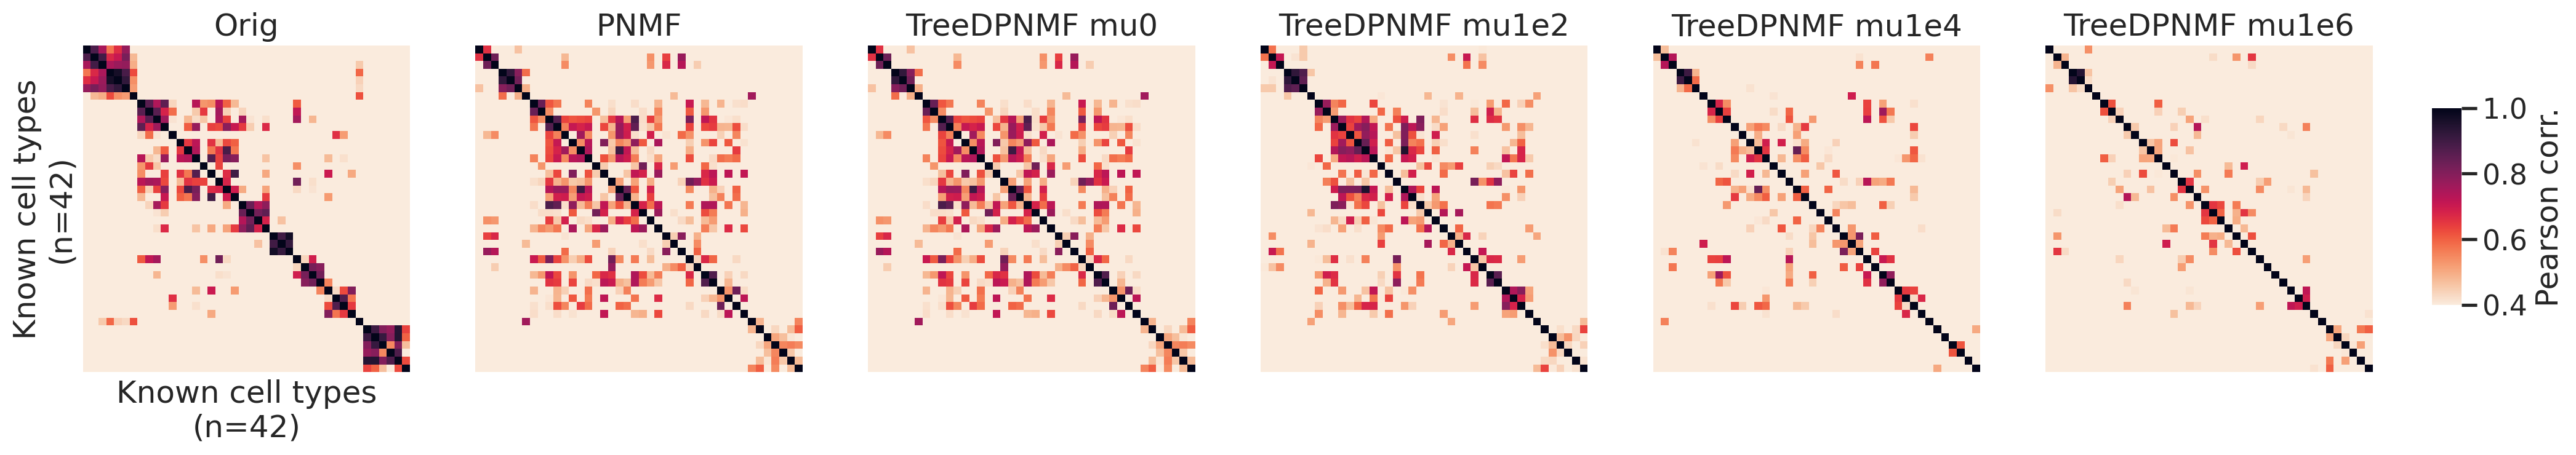

In [19]:
# DPNMF tree
n = len(res_all)
nx = min(n, 6)
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    ax = axs.flat[i]
    if i == 0: label = True
    else:      label = False
        
    designu.plot_heatcorr(
        res_pnmf.embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        vmin=0.4, 
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
    )

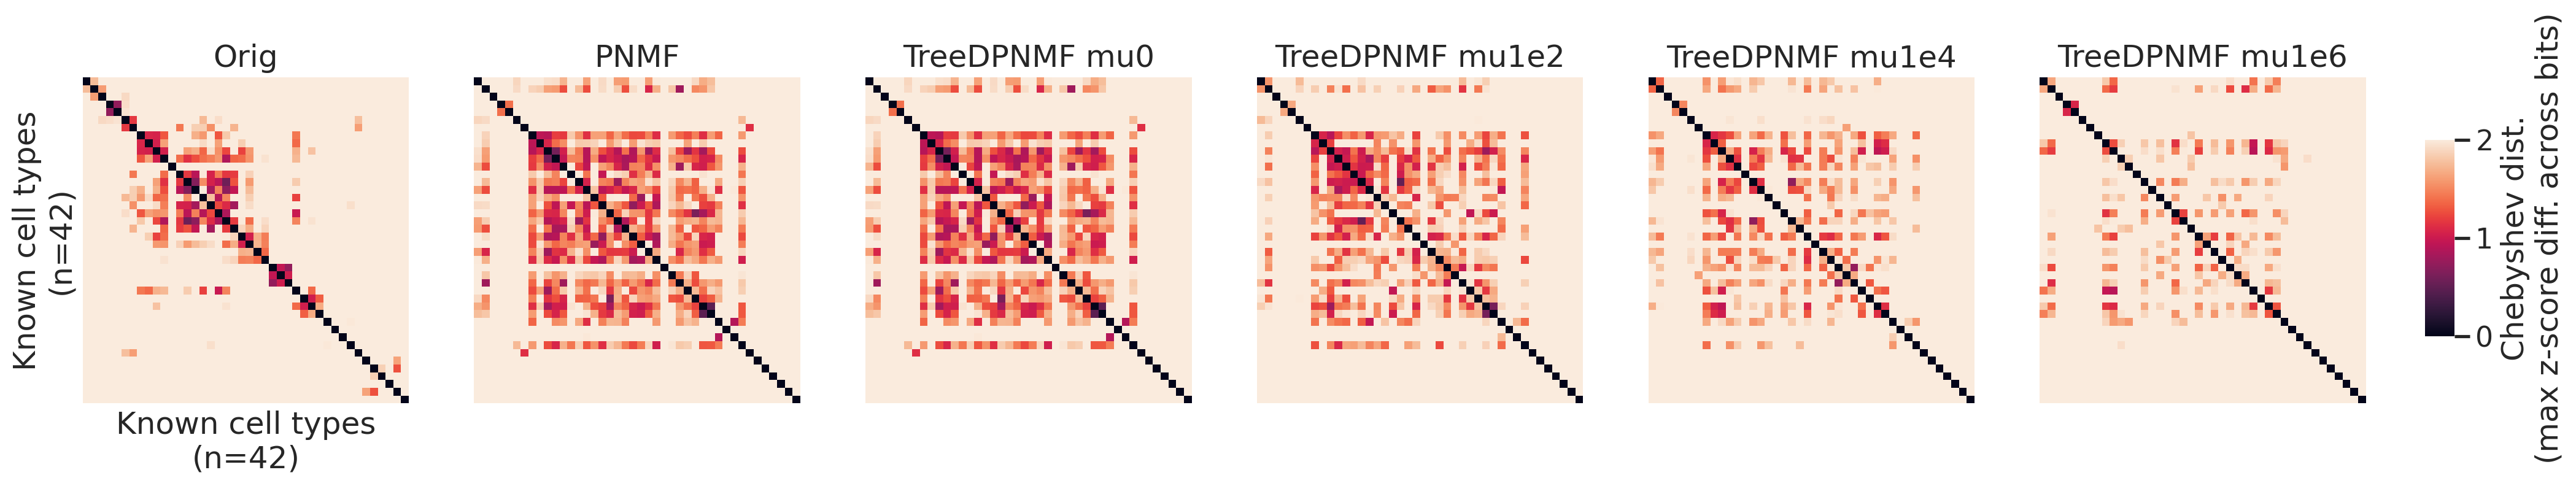

In [20]:
n = len(res_all)
nx = min(n, 6)
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    ax = axs.flat[i]
    if i == 0: label = True
    else:      label = False
    
    designu.plot_heatcorr(
        res_pnmf.dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts],
        vmin=0, 
        vmax=2,
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
        cmap='rocket',
        metric_label='Chebyshev dist.\n(max z-score diff. across bits)')

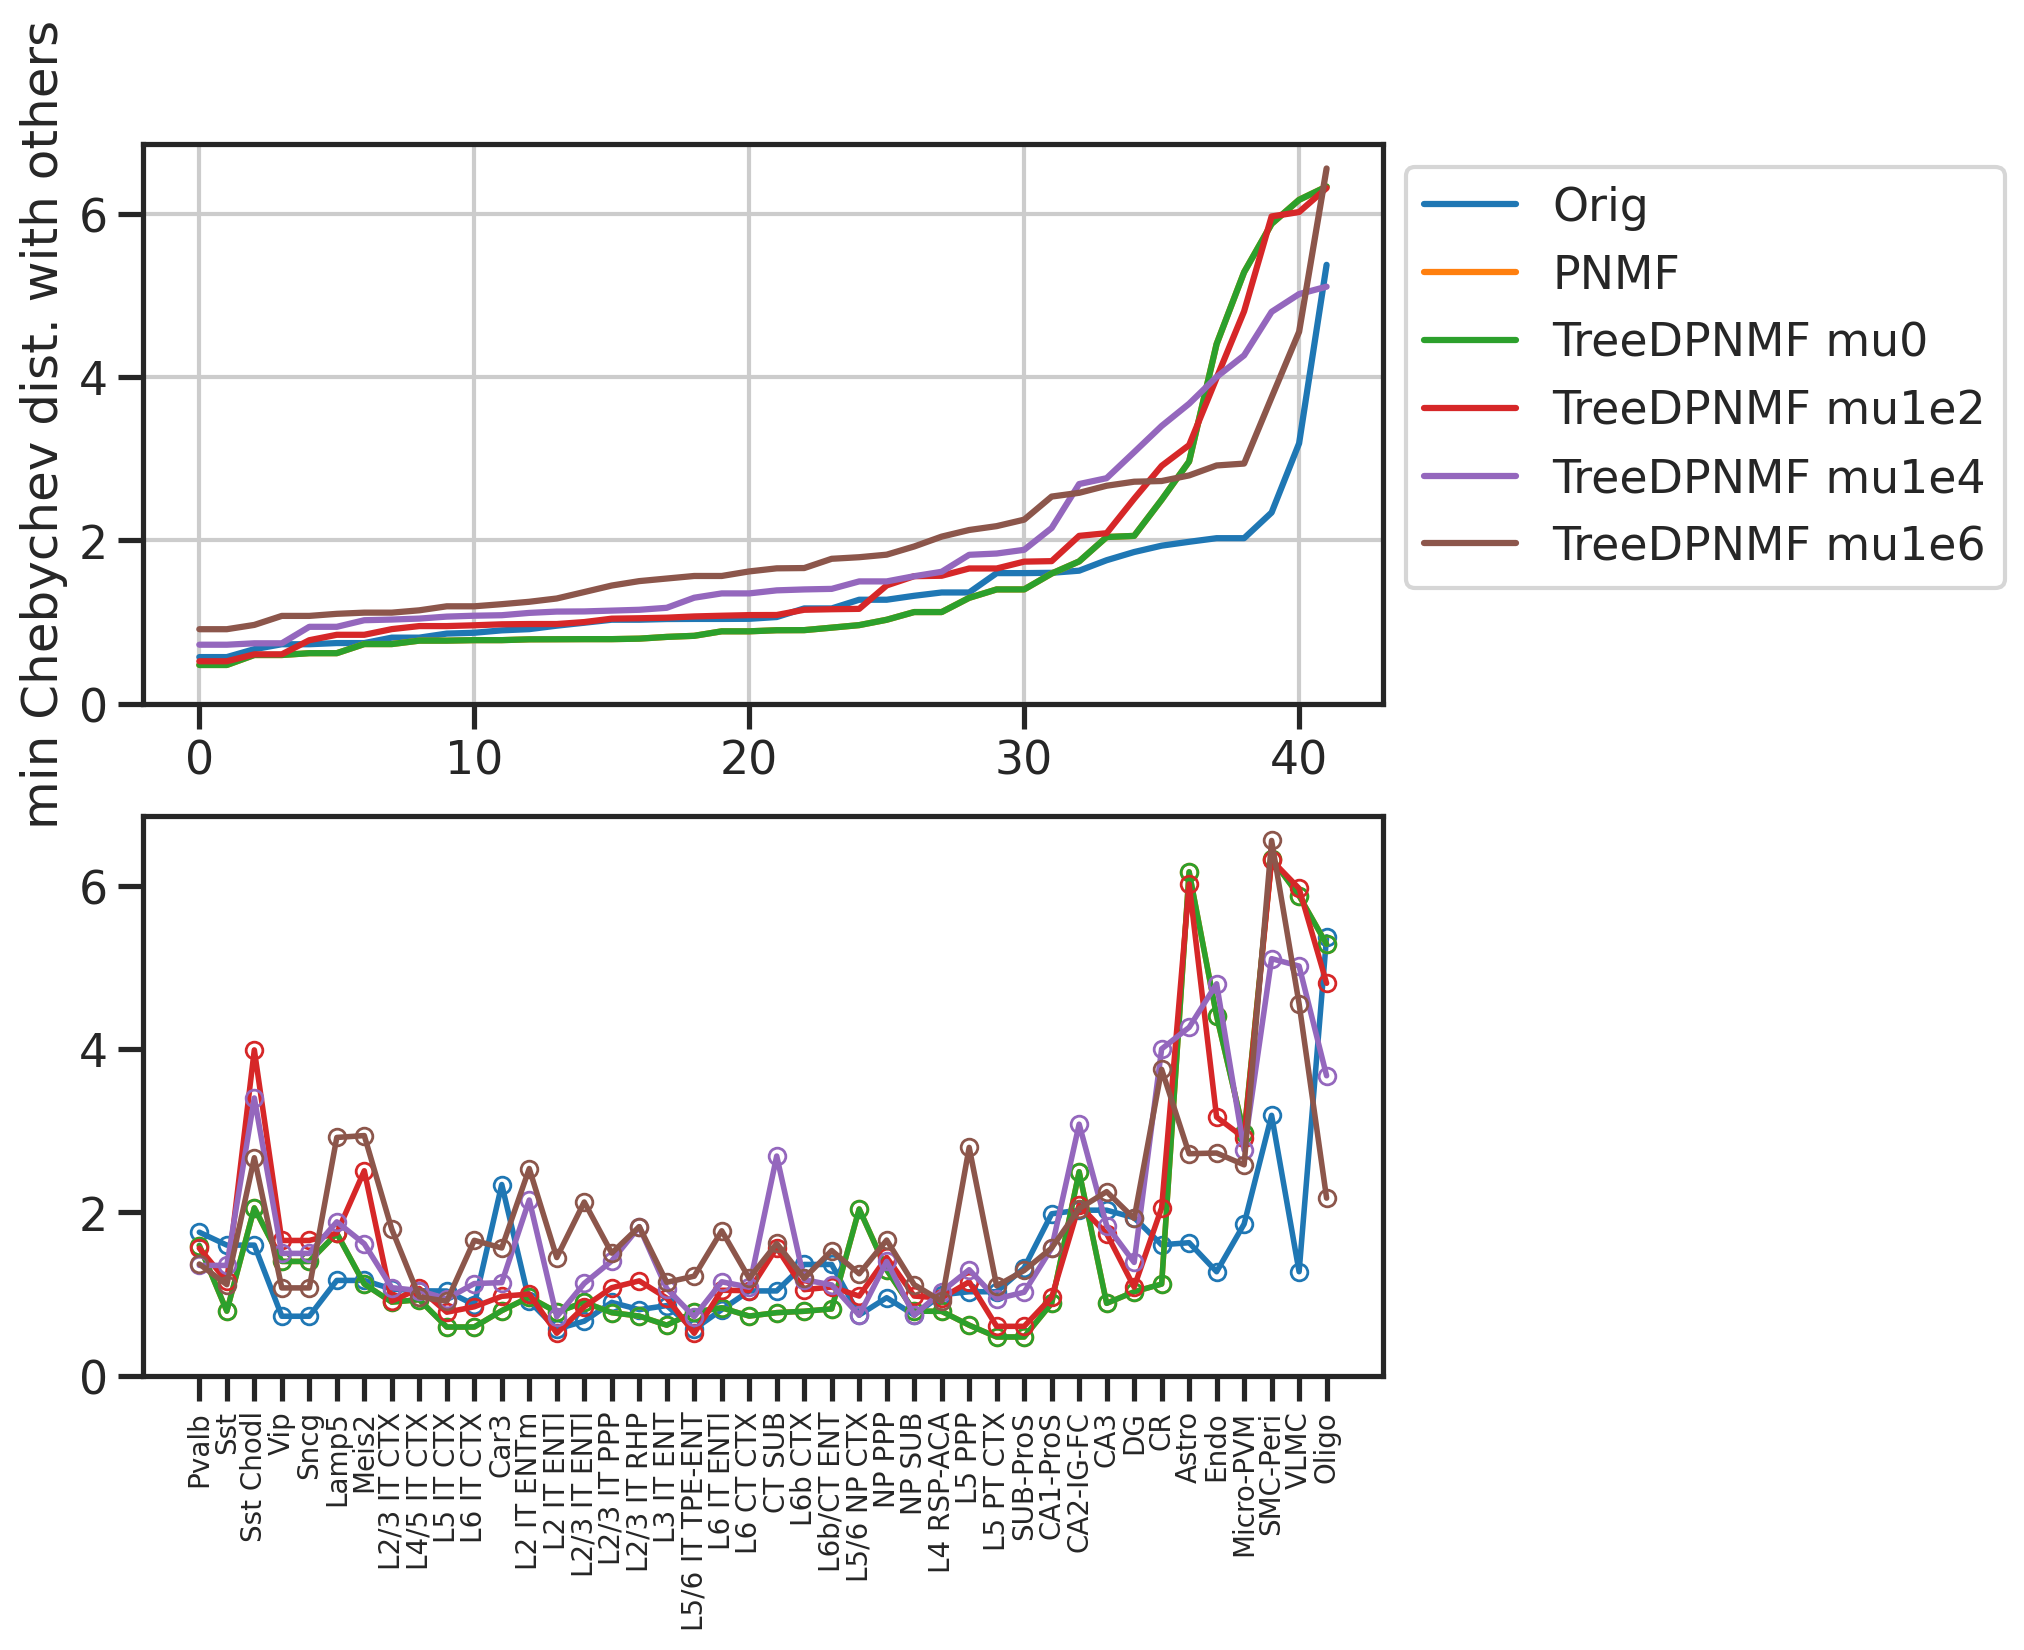

In [21]:
fig, axs = plt.subplots(2,1,figsize=(1*8,2*4))
for i, (meth, res_pnmf) in enumerate(res_all.items()):
    distmat = res_pnmf.dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts]
    color = res_pnmf.color
    
    # corr mat
    ax = axs[0]
    ax.plot(np.sort(np.sort(distmat, axis=0)[1]), label=meth, color=color)
    
    ax = axs[1]
    ax.plot(np.sort(distmat, axis=0)[1], '-o', label=meth, markersize=6, linewidth=2, fillstyle='none', color=color)
    ax.set_xticks(np.arange(len(distmat)))
    ax.set_xticklabels(l3clst_order, rotation=90, fontsize=10)
    ax.grid(False)
    
axs[0].set_ylim(ymin=0)
axs[1].set_ylim(ymin=0)
axs[0].legend(bbox_to_anchor=(1,1))
axs[0].set_ylabel('min Chebychev dist. with others')
plt.show()